# 📌 서론

본 연구에서는 시계열 및 랜드마크 기반 입력을 활용한 분류 모델의 성능을 극대화하기 위해 **단계적 최적화 절차**를 수행하였다.  
먼저 **LOSO 교차검증(Baseline)**으로 초기 성능을 확인한 뒤, 단일 폴드를 기준으로 다음과 같은 과정을 순차적으로 진행하였다.

1. **모델 아키텍처 변형** → GRU, BiGRU, GRU+Attention, CNN-GRU 등 비교  
2. **입력 특징 조합 탐색** → 얼굴/손 랜드마크, 시계열 파생 특징(velocity, acceleration, segment_stats)  
3. **Optuna 기반 하이퍼파라미터 탐색** → 성능과 학습 효율을 동시에 고려한 자동 최적화  
4. **최종 LOSO 교차검증 재실행** → 베이스라인 대비 성능 향상 검증  

추가적으로, 최고 성능 Fold 모델을 선별하여 단일 배포용으로 준비하고,  
모바일 환경 호환성을 위해 **TFLite 변환(unroll GRU 등 호환성 전략 포함)**을 적용하였다.  

이러한 체계적 절차는 **성능·효율성·배포 가능성**을 모두 고려한  
**실전형 최적화 파이프라인**으로서, 향후 유사 문제 해결에도 재사용 가능한 프레임워크를 제시한다.

---

![Figure 1. 최종 최적화 파이프라인 개요](./image.png)  
*Figure 1. 단계별 최적화 및 검증 과정을 요약한 전체 파이프라인 개요*

# # 실험 준비: 라이브러리 임포트 및 공통 함수

🔹 1. 기본 유틸

os, itertools, copy, time
→ 파일/디렉토리 관리, 반복 처리, 객체 복사, 실행 시간 측정 등 기본 기능 제공

🔹 2. 데이터 분석 & 시각화

pandas, numpy → 데이터 처리 및 수치 연산

seaborn, matplotlib.pyplot → 데이터 시각화 라이브러리

koreanize_matplotlib → matplotlib 그래프에 한글 폰트 적용

🔹 3. 머신러닝 / 딥러닝

scipy.stats → 통계적 분석 도구

sklearn.metrics.confusion_matrix, sklearn.model_selection.train_test_split
→ 평가 지표 및 데이터 분할

tensorflow → 딥러닝 모델 구현 및 학습

optuna → 하이퍼파라미터 최적화

🔹 4. 편의 기능

tqdm → 진행 상황 시각화 (progress bar)

IPython.display.Image, display → 노트북 내 이미지/객체 표시

🔹 5. 프로젝트 내부 모듈

config → 설정 파일

runner, pipeline → 실행 및 파이프라인 관리

feature_extraction, train, evaluate → 단계별 모듈
(특징 추출 → 학습 → 평가)

In [ ]:
import os
import itertools
import copy
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import optuna
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tqdm import tqdm  # 텍스트 진행바 (ipywidgets 불필요)

from IPython.display import Image, display  # 이미지를 노트북에 표시하기 위해 추가

import config
import run as runner
import main as pipeline
import m1_feature_extraction_answer as feature_extraction
import m2_train_answer as train
import m3_evaluate_answer as evaluate

# 시각화 한글 설정
try:
    import koreanize_matplotlib
except ImportError:
    print("koreanize-matplotlib이 설치되지 않았습니다. 그래프의 한글이 깨질 수 있습니다.")

print("준비 완료. 다음 셀부터 실험을 시작하세요.")


준비 완료. 다음 셀부터 실험을 시작하세요.


# # 단일 폴드 실행 함수 정의

🧪 단일 폴드 실행 함수: run_single_fold

지정한 fold 하나만 학습·검증·테스트하고 Macro F1를 반환합니다.
(학습 데이터 일부만 쓰고 싶다면 data_subset_fraction으로 비율을 지정)

⚙️ 시그니처
run_single_fold(config_dict, fold_id=1, data_subset_fraction=1.0)

🔢 매개변수

config_dict: 전체 파이프라인 설정 딕셔너리 (paths, settings 등 포함)

fold_id (int, default=1): 실행할 폴드 번호 (1-based)

data_subset_fraction (float, default=1.0): 학습 데이터 샘플링 비율 (예: 0.3 → 30%)

🧰 의존성

데이터/유틸: numpy as np, copy, os

스플릿: sklearn.model_selection.train_test_split

내부 모듈: runner, train, evaluate

설정 키:

cfg['settings']['VALIDATION_SPLIT_FROM_TRAIN']

cfg['settings'].get('SEED', 42)

cfg['paths']['OUTPUT_DIR']

🔁 동작 흐름

설정 복사: config_dict를 deepcopy하여 내부에서 안전하게 사용

피처 로딩/생성: runner.get_or_create_features(cfg) 결과(.npz)에서 X, y, groups, class_names 로드

폴드 분할: groups 기준으로 fold_id에 해당하는 그룹을 테스트, 나머지를 train pool

검증 분할: train pool에서 train/val 스플릿 (라벨 stratify)

옵션 샘플링: data_subset_fraction < 1.0이면 학습 집합만 비율 샘플링

학습: train.main(...)으로 모델 학습 및 best_model.h5 저장

평가: evaluate.main(...)으로 테스트 세트 성능 산출 → report_df['macro avg', 'f1-score']

반환: Macro F1 (float)

📤 반환값

Macro F1 (float): 테스트 세트의 macro-averaged F1-score

🧯 예외/엣지 케이스 팁

fold_id가 1 … len(unique_groups) 범위를 벗어나면 인덱싱 에러 가능

data_subset_fraction은 (0, 1] 범위를 권장 (너무 작으면 stratify 실패 가능)

runner.get_or_create_features가 실패하여 None/'' 반환 시 0.0 반환

▶️ 사용 예시
macro_f1 = run_single_fold(config, fold_id=2, data_subset_fraction=0.5)
print(f"Fold-2 Macro F1 = {macro_f1:.4f}")

In [ ]:
def run_single_fold(config_dict, fold_id: int = 1, data_subset_fraction: float = 1.0):
    """
    지정된 단일 폴드(fold_id)에 대해서만 학습 및 평가를 실행하고,
    테스트 세트의 Macro F1 Score를 반환하는 함수.
    
    Args:
        config_dict (dict): 실험 설정 딕셔너리
        fold_id (int): 실행할 폴드 번호 (1-based index)
        data_subset_fraction (float): 학습 데이터 샘플링 비율 (0 < fraction ≤ 1.0)

    Returns:
        float: 테스트 세트 Macro F1 Score
    """

    print(f"--- 단일 폴드(Fold-{fold_id}) 테스트 시작 "
          f"(데이터 샘플링: {data_subset_fraction*100:.1f}%) ---")

    # ✅ 설정 복사
    cfg = copy.deepcopy(config_dict)

    # ✅ 피처 로딩
    features_path = runner.get_or_create_features(cfg)
    if not features_path:
        return 0.0

    with np.load(features_path, allow_pickle=True) as data:
        X, y, groups = data['X'], data['y'], data['groups']
        class_names = data['class_names']

    # ✅ 그룹 기반 train/test 분리
    unique_groups = np.sort(np.unique(groups))
    test_group_id = unique_groups[fold_id - 1]
    test_indices = np.where(groups == test_group_id)[0]
    train_indices = np.where(groups != test_group_id)[0]

    # ✅ train/validation 분리
    tr_idx, va_idx = train_test_split(
        train_indices,
        test_size=cfg['settings']['VALIDATION_SPLIT_FROM_TRAIN'],
        random_state=cfg['settings'].get('SEED', 42),
        stratify=y[train_indices]
    )

    X_train, y_train = X[tr_idx], y[tr_idx]
    X_val, y_val = X[va_idx], y[va_idx]
    X_test, y_test = X[test_indices], y[test_indices]

    # ✅ 학습 데이터 샘플링 (옵션)
    if data_subset_fraction < 1.0:
        subset_indices, _ = train_test_split(
            np.arange(len(X_train)),
            train_size=data_subset_fraction,
            random_state=cfg['settings'].get('SEED', 42),
            stratify=y_train
        )
        X_train, y_train = X_train[subset_indices], y_train[subset_indices]
        print(f"학습 데이터가 {len(subset_indices)}개로 샘플링 되었습니다.")

    # ✅ 모델 저장 경로 설정
    output_dir = cfg['paths']['OUTPUT_DIR']
    fold_model_dir = os.path.join(output_dir, 'models', f'fold_{fold_id}')
    os.makedirs(fold_model_dir, exist_ok=True)
    model_save_path = os.path.join(fold_model_dir, 'best_model.h5')

    # ✅ 학습 및 평가
    train.main(
        X_train, y_train,
        X_val, y_val,
        len(class_names),
        model_save_path,
        cfg
    )

    report_df = evaluate.main(
        X_test, y_test,
        class_names,
        model_save_path,
        fold_model_dir,
        cfg
    )

    if report_df is None:
        return 0.0

    macro_f1 = report_df.loc['macro avg', 'f1-score']
    print(f"--- 단일 폴드(Fold-{fold_id}) 테스트 완료 | Macro F1: {macro_f1:.4f} ---")

    return macro_f1


# # 1단계: LOSO 교차 검증 성능 확인

🧪 LOSO 교차 검증 결과 재사용/실행 및 성능 시각화

이 셀은 LOSO 교차 검증 결과가 이미 있으면 재사용하고, 없으면 파이프라인을 실행하여 결과를 생성한 뒤
각 폴드의 Macro F1 Score를 통계 및 시각화로 확인합니다.

🔧 단계 요약

설정 복사 & 출력 경로 지정

config.MANUAL_CONFIG를 깊은 복사 후 OUTPUT_DIR만 실험 폴더로 교체

결과 재사용 여부 판단

final_loso_cv_report.csv가 있으면 재실행 생략

없으면 runner.get_or_create_features로 특징 생성 → pipeline.run_pipeline 실행

결과 로드 및 통계

macro avg 행에서 f1-score만 추출하여 기술통계 출력

시각화

boxplot + stripplot으로 폴드별 Macro F1 분포 확인

✅ 기존 LOSO 결과 파일('outputs/step1_loso_test\models\final_loso_cv_report.csv')을 찾았습니다. 재실행을 건너뛰고 결과를 재사용합니다.

[LOSO Macro F1 Score 통계]
count    26.000000
mean      0.770618
std       0.139499
min       0.473250
25%       0.710164
50%       0.768498
75%       0.862431
max       0.993389
Name: f1-score, dtype: float64


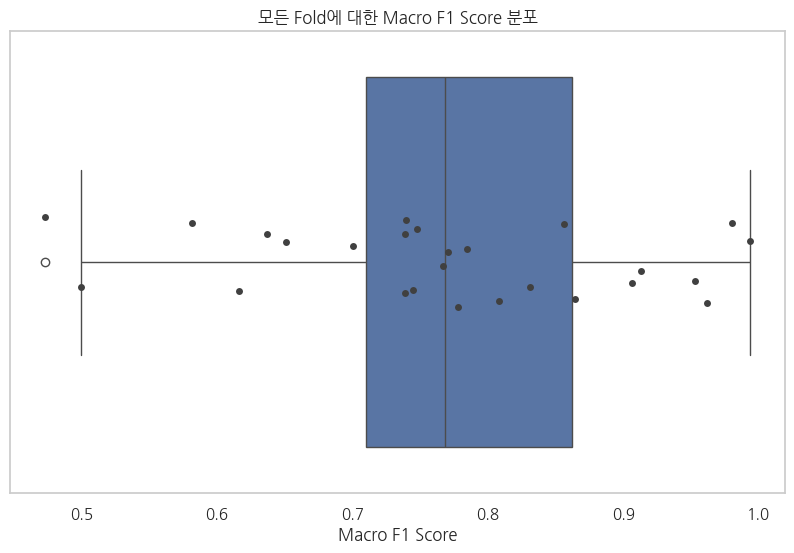

In [ ]:
# 1) 설정 및 경로 정의
manual_run_config = copy.deepcopy(config.MANUAL_CONFIG)
manual_run_config['paths']['OUTPUT_DIR'] = 'outputs/step1_loso_test'

report_path = os.path.join(
    manual_run_config['paths']['OUTPUT_DIR'],
    'models',
    'final_loso_cv_report.csv'
)

# 2) 기존 결과 확인 및 파이프라인 실행
if os.path.exists(report_path):
    print(f"✅ 기존 LOSO 결과 파일('{report_path}')을 찾았습니다. "
          f"재실행을 건너뛰고 결과를 재사용합니다.")
else:
    print("⏳ 기존 LOSO 결과가 없습니다. 전체 교차 검증을 새로 시작합니다. "
          "시간이 다소 소요될 수 있습니다...")

    # run.py와 동일하게 특징 파일 경로를 먼저 확보
    features_path = runner.get_or_create_features(manual_run_config)
    if not features_path:
        raise FileNotFoundError("특징 파일 생성에 실패하여 중단합니다.")

    manual_run_config['paths']['FEATURES_PATH'] = features_path

    # 파이프라인 실행
    pipeline.run_pipeline(manual_run_config)
    print("✅ LOSO 교차 검증 완료.")

# 3) 결과 파일 로드
loso_report_df = pd.read_csv(report_path)

# 4) Macro F1 Score 추출 및 통계 출력
macro_f1_scores_df = (
    loso_report_df
    [loso_report_df['Unnamed: 0'] == 'macro avg'][['fold', 'f1-score']]
    .set_index('fold')
)
print("\n[LOSO Macro F1 Score 통계]")
print(macro_f1_scores_df['f1-score'].describe())

# 5) 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x=macro_f1_scores_df['f1-score'], orient='h')
sns.stripplot(x=macro_f1_scores_df['f1-score'], color=".25", orient='h')
plt.title('모든 Fold에 대한 Macro F1 Score 분포')
plt.xlabel('Macro F1 Score')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


📊 Fold 대표성 검증 (부트스트랩 신뢰구간)

이 셀은 특정 Fold 성능이 전체 평균과 얼마나 일치하는지 검증합니다.
부트스트랩 방식으로 신뢰구간(95% CI)을 계산하여, 선택한 Fold가 대표성 있는 성능인지 확인합니다.

🔧 단계 요약

데이터 준비

tuning_fold_id: 대표성 여부를 확인할 기준 Fold

fold_score: 해당 Fold의 Macro F1

others: 나머지 Fold들의 성능

전체 평균 신뢰구간 (bootstrap)

전체 Fold 점수를 대상으로 n_boot = 10,000번 샘플링

평균 F1의 95% CI 계산 → 기준 Fold 점수가 포함되는지 확인

Fold vs Others 평균 차이 (bootstrap)

기준 Fold와 나머지 Fold 평균 차이를 반복 샘플링

95% CI에 0이 포함되면 유의한 차이 없음

포함되지 않으면 해당 Fold는 특이 Fold일 가능성 존재

📌 출력 예시

fold_7 점수: 0.8123

다른 Fold 평균: 0.8051

[전체 평균 F1 신뢰구간] 95% CI = [0.7901, 0.8234]

✅ fold_7 점수는 전체 평균의 95% 신뢰구간 안에 있음 → 대표성 있음

In [ ]:
# === 1. 데이터 준비 ===
scores = macro_f1_scores_df['f1-score'].values   # 전체 fold 점수
tuning_fold_id = "fold_7"                        # 기준 fold (예: fold_7)
fold_score = macro_f1_scores_df.loc[tuning_fold_id, 'f1-score']
others = macro_f1_scores_df.drop(tuning_fold_id)['f1-score'].values

print(f"{tuning_fold_id} 점수: {fold_score:.4f}")
print(f"다른 Fold 평균: {others.mean():.4f}")

# === 2. 전체 평균 신뢰구간 (bootstrap) ===
n_boot = 10000
boot_means = [
    np.mean(np.random.choice(scores, size=len(scores), replace=True))
    for _ in range(n_boot)
]

ci_lower, ci_upper = np.percentile(boot_means, [2.5, 97.5])
print(f"\n[전체 평균 F1 신뢰구간] 95% CI = [{ci_lower:.4f}, {ci_upper:.4f}]")

if ci_lower <= fold_score <= ci_upper:
    print(f"✅ {tuning_fold_id} 점수는 전체 평균의 95% 신뢰구간 안에 있음 → 대표성 있음")
else:
    print(f"⚠️ {tuning_fold_id} 점수는 평균 신뢰구간 밖에 있음 → 특이값일 수 있음")

# === 3. Fold vs 나머지 평균 차이 신뢰구간 (bootstrap) ===
diffs = []
for _ in range(n_boot):
    boot_others = np.mean(np.random.choice(others, size=len(others), replace=True))
    diffs.append(fold_score - boot_others)

ci_diff_lower, ci_diff_upper = np.percentile(diffs, [2.5, 97.5])
print(f"\n[{tuning_fold_id} vs Others 평균 차이 신뢰구간] "
      f"95% CI = [{ci_diff_lower:.4f}, {ci_diff_upper:.4f}]")

if ci_diff_lower <= 0 <= ci_diff_upper:
    print(f"✅ {tuning_fold_id}와 나머지 평균의 차이는 유의하지 않음 (p≈0.05 기준)")
else:
    print(f"⚠️ {tuning_fold_id}와 나머지 평균이 유의하게 다를 수 있음")


fold_7 점수: 0.7395
다른 Fold 평균: 0.7719

[전체 평균 F1 신뢰구간] 95% CI = [0.7165, 0.8222]
✅ fold_7 점수는 전체 평균의 95% 신뢰구간 안에 있음 → 대표성 있음

[fold_7 vs Others 평균 차이 신뢰구간] 95% CI = [-0.0854, 0.0214]
✅ fold_7와 나머지 평균의 차이는 유의하지 않음 (p≈0.05 기준)


🎯 튜닝 기준 Fold 설정

이후의 하이퍼파라미터 탐색 및 튜닝은 특정 Fold를 대표 Fold로 삼아 진행합니다.
여기서는 **fold_7**을 기준으로 고정하여, 해당 Fold의 성능을 튜닝 지표로 활용합니다.

In [ ]:
# 4. 튜닝 기준 Fold를 fold_7로 고정
tuning_fold_id = "fold_7"

print(f"\n선택 Fold: {tuning_fold_id} "
      f"(F1: {macro_f1_scores_df.loc[tuning_fold_id, 'f1-score']:.4f})")
print(f"이후 모든 튜닝은 {tuning_fold_id}를 기준으로 진행됩니다.")


선택 Fold: fold_7 (F1: 0.7395)
이후 모든 튜닝은 fold_7를 기준으로 진행됩니다.


# # 모델 아키텍처(`variant`) 성능 비교

🏗️ 아키텍처 후보 비교 (단일 Fold 튜닝 기준)

선택한 **튜닝 기준 Fold({tuning_fold_id})**에서, 지정한 아키텍처 후보들의 Macro F1을 비교합니다.
기존 결과가 있으면 재사용, 없으면 단일 폴드 평가를 새로 수행합니다.

🔧 단계 요약

결과 캐시 확인

경로: outputs/step2_arch_test/<variant>/models/{tuning_fold_id}/classification_report.csv

전부 있으면 로드, 하나라도 없으면 해당 변형(variant)을 재실행

단일 폴드 평가

run_single_fold(test_cfg, fold_id=<int>) 호출

test_cfg['model_arch']['variant']로 모델 변형 지정

시각화

barplot으로 아키텍처별 Macro F1 비교

최적 후보 출력

최고 성능 아키텍처와 점수 출력

✅ 기존 아키텍처 테스트 결과('outputs/step2_arch_test')를 찾았습니다. 결과를 재사용합니다.


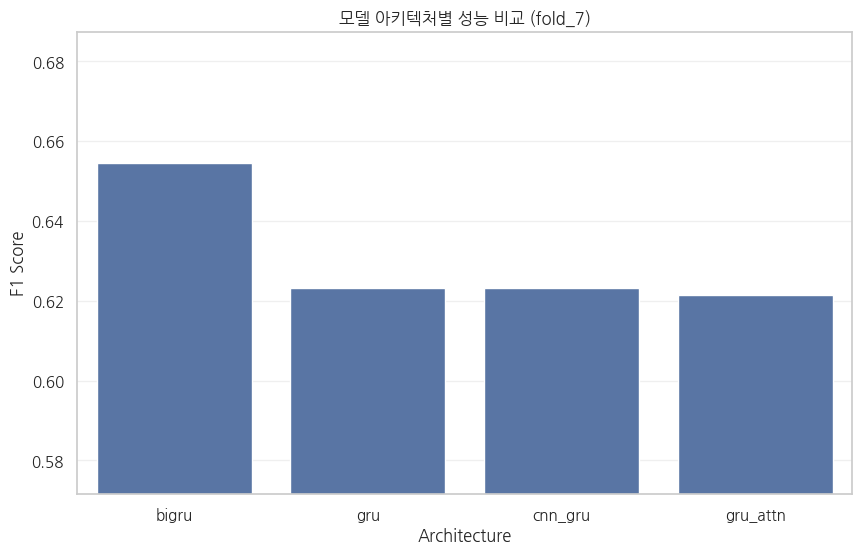


최고 F1 점수 아키텍처: bigru (F1: 0.6546)


In [ ]:
# === 아키텍처 후보 & 결과 컨테이너 ===
architectures_to_test = ['gru', 'bigru', 'gru_attn', 'cnn_gru']
results_arch = {}
arch_test_output_dir = 'outputs/step2_arch_test'


# === Fold ID 정규화 ===
def norm_fold_id(fid):
    """정수/문자 어떤 입력이 와도 'fold_X' 형식으로 통일."""
    if isinstance(fid, int) or (isinstance(fid, str) and fid.isdigit()):
        return f"fold_{int(fid)}"
    if isinstance(fid, str) and fid.startswith("fold_"):
        return fid
    raise ValueError(f"지원하지 않는 fold 형식: {fid!r}")


tuning_fold_id = norm_fold_id(tuning_fold_id)  # 예: 7 -> 'fold_7'


# === 1) 모든 아키텍처의 기존 결과 확인 ===
all_results_exist = True
missing = []

def _report_path(base_dir, variant, fold_id):
    return os.path.join(base_dir, variant, 'models', fold_id, 'classification_report.csv')

for variant in architectures_to_test:
    rp = _report_path(arch_test_output_dir, variant, tuning_fold_id)
    if not os.path.exists(rp):
        all_results_exist = False
        missing.append(rp)

# === 2) 결과 불러오기 또는 새로 실행 ===
if all_results_exist:
    print(f"✅ 기존 아키텍처 테스트 결과('{arch_test_output_dir}')를 찾았습니다. 결과를 재사용합니다.")
    for variant in architectures_to_test:
        rp = _report_path(arch_test_output_dir, variant, tuning_fold_id)
        report_df = pd.read_csv(rp, index_col=0)
        results_arch[variant] = float(report_df.loc['macro avg', 'f1-score'])
else:
    if missing:
        print("기존 아키텍처 테스트 결과가 없거나 불완전합니다. 새로 테스트를 시작합니다.")
        print("누락 파일 예시:", missing[0])

    for variant in architectures_to_test:
        print(f"\n===== 아키텍처 테스트: {variant} =====")
        test_cfg = copy.deepcopy(config.MANUAL_CONFIG)
        test_cfg['paths']['OUTPUT_DIR'] = os.path.join(arch_test_output_dir, variant)
        test_cfg['model_arch']['variant'] = variant

        # run_single_fold가 fold id를 정수로 받으므로 int로 변환
        fold_int = int(tuning_fold_id.split('_')[1])
        f1_score = run_single_fold(test_cfg, fold_id=fold_int)
        results_arch[variant] = f1_score

# === 3) 결과 시각화 ===
if not results_arch:
    raise RuntimeError("아키텍처 테스트 결과가 비어 있습니다. 상위 단계 실행을 확인하세요.")

results_df = (
    pd.DataFrame(list(results_arch.items()), columns=['Architecture', 'F1 Score'])
    .sort_values('F1 Score', ascending=False)
)

plt.figure(figsize=(10, 6))
sns.barplot(x='Architecture', y='F1 Score', data=results_df, order=results_df['Architecture'])
plt.title(f'모델 아키텍처별 성능 비교 ({tuning_fold_id})')
plt.ylim(bottom=max(0.0, results_df['F1 Score'].min() - 0.05))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# === 4) 최적 아키텍처 출력 ===
best_architecture = results_df.iloc[0]['Architecture']
best_score = results_df.iloc[0]['F1 Score']
print(f"\n최고 F1 점수 아키텍처: {best_architecture} (F1: {best_score:.4f})")



# # 모델 아키텍처별 추론 속도 비교

⚡ 아키텍처별 추론 속도 비교 (inference throughput)

동일한 입력(N_BENCH=2000 샘플)에 대해 각 아키텍처 모델의 **초당 처리 샘플 수(Samples/Sec)**를 측정하여
실행 속도 관점에서의 우열을 비교합니다.

🔧 절차

데이터 로드: 학습 때 생성한 특징 파일(.npz)에서 X만 로드 → 상위 2,000개 사용

모델 로드 & 워밍업: 각 아키텍처 모델을 로드한 뒤, 첫 추론은 워밍업으로 분리

속도 측정: batch_size=64로 전체 test_sample에 대해 predict 수행 시간 측정

정리/시각화: Samples/Sec 기준 내림차순 정렬 막대 그래프 출력 + 표 요약

📂 모델 경로 규칙

기본: outputs/step2_arch_test/<variant>/models/{tuning_fold_id}/best_model.keras

.keras가 없으면 자동으로 .h5 경로도 시도합니다.

추론 속도 측정을 위해 2000개의 샘플을 사용합니다.

===== 추론 속도 측정: gru =====
'gru' 모델 로드 성공.
처리 시간: 0.5167초, 초당 처리 샘플 수: 3870.87개

===== 추론 속도 측정: bigru =====
'bigru' 모델 로드 성공.
처리 시간: 0.8660초, 초당 처리 샘플 수: 2309.46개

===== 추론 속도 측정: gru_attn =====
'gru_attn' 모델 로드 성공.
처리 시간: 0.6032초, 초당 처리 샘플 수: 3315.76개

===== 추론 속도 측정: cnn_gru =====
'cnn_gru' 모델 로드 성공.
처리 시간: 0.4999초, 초당 처리 샘플 수: 4000.44개


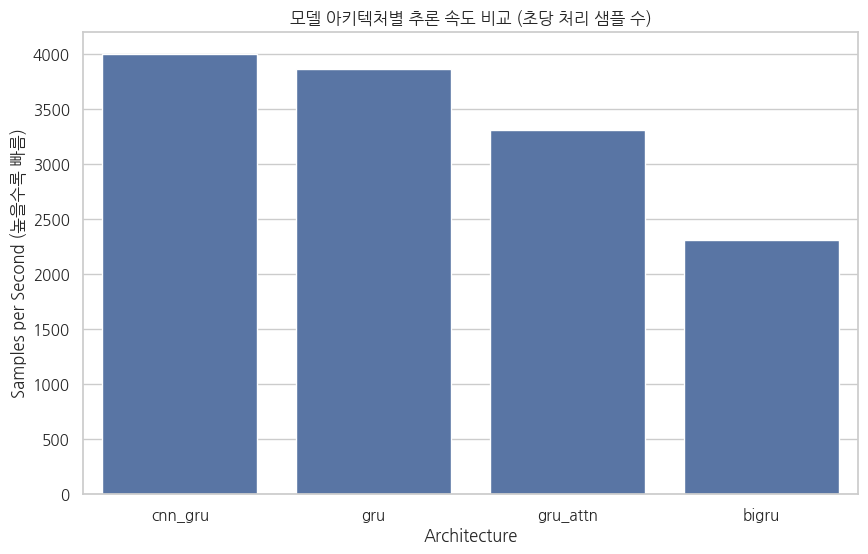


[추론 속도 비교 결과 (Samples/Sec)]
  Architecture  Samples/Sec
3      cnn_gru  4000.440646
0          gru  3870.871404
2     gru_attn  3315.758872
1        bigru  2309.457545


In [ ]:
# === 1) 테스트 데이터 로드 ===
# 학습에 사용했던 특징 데이터(.npz)에서 X만 로드
features_path = runner.get_or_create_features(config.MANUAL_CONFIG)
with np.load(features_path, allow_pickle=True) as data:
    X_data = data['X']

# 전체 중 앞부분 일부(예: 2,000개)로 속도 측정
N_BENCH = 2000
test_sample = X_data[:N_BENCH]
print(f"추론 속도 측정을 위해 {len(test_sample)}개의 샘플을 사용합니다.")


# === 2) 각 아키텍처 모델 추론 속도 측정 ===
results_speed = {}

def _resolve_model_path(variant: str, fold_id: str) -> str:
    """아키텍처/폴드별 모델 경로 결정 (.keras 우선, 없으면 .h5 시도)."""
    base = os.path.join('outputs', 'step2_arch_test', variant, 'models', fold_id, 'best_model')
    keras_path = base + '.keras'
    h5_path = base + '.h5'
    if os.path.exists(keras_path):
        return keras_path
    if os.path.exists(h5_path):
        return h5_path
    # 기본 경로(.keras) 반환해 로드 시 에러 메시지에 경로 노출
    return keras_path

for variant in architectures_to_test:
    print(f"\n===== 추론 속도 측정: {variant} =====")

    model_path = _resolve_model_path(variant, tuning_fold_id)
    try:
        # 모델 로드
        model = tf.keras.models.load_model(model_path)
        print(f"'{variant}' 모델 로드 성공: {model_path}")

        # 워밍업 (초기 그래프/커널 준비로 인한 첫 호출 지연 제외)
        _ = model.predict(test_sample[:1], verbose=0)

        # 실제 추론 시간 측정
        start_time = time.time()
        _ = model.predict(test_sample, batch_size=64, verbose=0)  # 로그 숨김
        duration = time.time() - start_time

        samples_per_second = len(test_sample) / max(duration, 1e-9)
        results_speed[variant] = samples_per_second

        print(f"처리 시간: {duration:.4f}초, 초당 처리 샘플 수: {samples_per_second:.2f}개")

    except Exception as e:
        print(f"⚠️ '{variant}' 모델 처리 중 오류: {e}")
        results_speed[variant] = 0.0


# === 3) 결과 시각화 ===
if not results_speed:
    raise RuntimeError("속도 측정 결과가 비어 있습니다. 상위 단계 실행을 확인하세요.")

speed_df = (
    pd.DataFrame(list(results_speed.items()), columns=['Architecture', 'Samples/Sec'])
    .sort_values('Samples/Sec', ascending=False)
)

plt.figure(figsize=(10, 6))
sns.barplot(x='Architecture', y='Samples/Sec', data=speed_df, order=speed_df['Architecture'])
plt.title('모델 아키텍처별 추론 속도 비교 (Samples/Sec)')
plt.ylabel('Samples per Second (높을수록 빠름)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


# === 4) 결과 요약 ===
print("\n[추론 속도 비교 결과 (Samples/Sec)]")
print(speed_df.to_string(index=False))


# # 랜드마크 특징(`FEATURE_CONFIG`) 조합 탐색

🧱 랜드마크 특징 조합 탐색 (단일 Fold, 고속 테스트)

고정 아키텍처({best_architecture})와 기준 폴드({tuning_fold_id})에서
얼굴 관련 특징 4개({', '.join(face_features)})의 사용/미사용 조합을 전수 탐색하여 Macro F1을 비교합니다.
모든 특징이 False면 Hand Only로 간주합니다.

🔧 절차

조합 생성: itertools.product로 2⁴=16개 플래그 조합 생성

캐시 확인: 각 조합별 classification_report.csv 존재 시 재사용, 없으면 재학습

학습 설정(고속): epochs=30, early_stopping_patience=5, data_subset_fraction=0.3

평가/정리: 각 조합의 Macro F1 수집 → 수평 막대그래프로 비교 → 최고 조합/설정 출력

📂 결과 경로 규칙
outputs/step3_1_feature_test/<Feature_Combo_Dir>/models/{tuning_fold_id}/classification_report.csv


<Feature_Combo_Dir>: 라벨의 “, ”를 “_”로 치환 (예: face_pitch_face_inner_eyes)

아키텍처를 'cnn_gru'로 고정하여 테스트를 진행합니다.
기존 특징 조합 테스트 결과가 없거나 불완전합니다. 새로 테스트를 시작합니다.



===== 특징 조합 테스트: face_roll_scale, face_pitch, face_mouth_corners, face_inner_eyes =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---







































































































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:35<00:00, 31.49it/s]






































































































































































































































































































학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.46433, saving model to outputs/step3_1_feature_test\face_roll_scale_face_pitch_face_mouth_corners_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 7s - 38ms/step - accuracy: 0.2738 - loss: 2.2114 - val_accuracy: 0.5357 - val_loss: 1.4643 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.46433 to 0.92075, saving model to outputs/step3_1_feature_test\face_roll_scale_face_pitch_face_mouth_corners_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 4s - 24ms/step - accuracy: 0.4959 - loss: 1.5486 - val_accuracy: 0.7449 - val_loss: 0.9207 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.92075 to 0.65391, saving model to outputs/step3_1_feature_test\face_roll_scale_face_pitch_face_mouth_corners_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 4s - 23ms/step - accuracy: 0.6295 - loss: 1.1584 - val_accuracy: 0.8098 - val_loss: 0.6539 - learning_rate: 3.0000e-04
Epoch 4/30

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6618 ---

===== 특징 조합 테스트: face_roll_scale, face_pitch, face_mouth_corners =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---




































































































































































































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:51<00:00, 21.65it/s]









































































































































































































학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.43163, saving model to outputs/step3_1_feature_test\face_roll_scale_face_pitch_face_mouth_corners\models\fold_7\best_model.keras
178/178 - 8s - 43ms/step - accuracy: 0.2891 - loss: 2.1980 - val_accuracy: 0.5412 - val_loss: 1.4316 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.43163 to 0.82791, saving model to outputs/step3_1_feature_test\face_roll_scale_face_pitch_face_mouth_corners\models\fold_7\best_model.keras
178/178 - 4s - 25ms/step - accuracy: 0.5185 - loss: 1.4920 - val_accuracy: 0.7524 - val_loss: 0.8279 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.82791 to 0.61240, saving model to outputs/step3_1_feature_test\face_roll_scale_face_pitch_face_mouth_corners\models\fold_7\best_model.keras
178/178 - 4s - 25ms/step - accuracy: 0.6632 - loss: 1.0863 - val_accuracy: 0.8132 - val_loss: 0.6124 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.61240 to 0.4

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.7086 ---

===== 특징 조합 테스트: face_roll_scale, face_pitch, face_inner_eyes =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---




























































































































































































































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:42<00:00, 25.85it/s]

















































































































































































학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.47056, saving model to outputs/step3_1_feature_test\face_roll_scale_face_pitch_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 7s - 39ms/step - accuracy: 0.2735 - loss: 2.2172 - val_accuracy: 0.5881 - val_loss: 1.4706 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.47056 to 0.90311, saving model to outputs/step3_1_feature_test\face_roll_scale_face_pitch_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 5s - 25ms/step - accuracy: 0.5067 - loss: 1.5211 - val_accuracy: 0.7087 - val_loss: 0.9031 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.90311 to 0.58065, saving model to outputs/step3_1_feature_test\face_roll_scale_face_pitch_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 5s - 25ms/step - accuracy: 0.6513 - loss: 1.0961 - val_accuracy: 0.8376 - val_loss: 0.5807 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.58065 to 0.45970, sav

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6310 ---

===== 특징 조합 테스트: face_roll_scale, face_pitch =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.41904, saving model to outputs/step3_1_feature_test\face_roll_scale_face_pitch\models\fold_7\best_model.keras
178/178 - 6s - 32ms/step - accuracy: 0.2855 - loss: 2.1853 - val_accuracy: 0.5469 - val_loss: 1.4190 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.41904 to 0.93885, saving model to outputs/step3_1_feature_test\face_roll_scale_face_pitch\models\fold_7\best_model.keras
178/178 - 3s - 18ms/step - accuracy: 0.5284 - loss: 1.4874 - val_accuracy: 0.6924 - val_loss: 0.9388 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.93885 to 0.58077, saving model to outputs/step3_1_feature_test\face_roll_scale_face_pitch\models\fold_7\best_model.keras
178/178 - 3s - 18ms/step - accuracy: 0.6612 - loss: 1.0912 - val_accuracy: 0.8461 - val_loss: 0.5808 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.58077 to 0.45549, saving model to outputs/step3_1_feature_test\face_r

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6162 ---

===== 특징 조합 테스트: face_roll_scale, face_mouth_corners, face_inner_eyes =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---



















































































































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:37<00:00, 29.96it/s]


























































































































































































































































































학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 2.37386, saving model to outputs/step3_1_feature_test\face_roll_scale_face_mouth_corners_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 7s - 37ms/step - accuracy: 0.1040 - loss: 2.6374 - val_accuracy: 0.2066 - val_loss: 2.3739 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 2.37386 to 2.17643, saving model to outputs/step3_1_feature_test\face_roll_scale_face_mouth_corners_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 4s - 22ms/step - accuracy: 0.1701 - loss: 2.4060 - val_accuracy: 0.2506 - val_loss: 2.1764 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 2.17643 to 1.91691, saving model to outputs/step3_1_feature_test\face_roll_scale_face_mouth_corners_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 4s - 22ms/step - accuracy: 0.2334 - loss: 2.2078 - val_accuracy: 0.3591 - val_loss: 1.9169 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5462 ---

===== 특징 조합 테스트: face_roll_scale, face_mouth_corners =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
























































































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:36<00:00, 30.17it/s]





















































































































































































































































































































학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 2.45079, saving model to outputs/step3_1_feature_test\face_roll_scale_face_mouth_corners\models\fold_7\best_model.keras
178/178 - 6s - 33ms/step - accuracy: 0.0864 - loss: 2.6442 - val_accuracy: 0.1717 - val_loss: 2.4508 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 2.45079 to 2.16858, saving model to outputs/step3_1_feature_test\face_roll_scale_face_mouth_corners\models\fold_7\best_model.keras
178/178 - 3s - 18ms/step - accuracy: 0.1610 - loss: 2.4093 - val_accuracy: 0.2506 - val_loss: 2.1686 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 2.16858 to 1.93188, saving model to outputs/step3_1_feature_test\face_roll_scale_face_mouth_corners\models\fold_7\best_model.keras
178/178 - 3s - 19ms/step - accuracy: 0.2236 - loss: 2.2365 - val_accuracy: 0.3419 - val_loss: 1.9319 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.93188 to 1.72662, saving model to outputs/ste

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6091 ---

===== 특징 조합 테스트: face_roll_scale, face_inner_eyes =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---





















































































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:37<00:00, 29.74it/s]
























































































































































































































































































































학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 2.46421, saving model to outputs/step3_1_feature_test\face_roll_scale_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 6s - 32ms/step - accuracy: 0.0865 - loss: 2.6416 - val_accuracy: 0.1738 - val_loss: 2.4642 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 2.46421 to 2.14933, saving model to outputs/step3_1_feature_test\face_roll_scale_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 3s - 18ms/step - accuracy: 0.1627 - loss: 2.4056 - val_accuracy: 0.2504 - val_loss: 2.1493 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 2.14933 to 1.94494, saving model to outputs/step3_1_feature_test\face_roll_scale_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 3s - 18ms/step - accuracy: 0.2190 - loss: 2.2091 - val_accuracy: 0.3438 - val_loss: 1.9449 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.94494 to 1.61388, saving model to outputs/step3_1_feat

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5248 ---

===== 특징 조합 테스트: face_roll_scale =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---



































































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:36<00:00, 30.37it/s]










































































































































































































































































































































학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 2.51143, saving model to outputs/step3_1_feature_test\face_roll_scale\models\fold_7\best_model.keras
178/178 - 6s - 31ms/step - accuracy: 0.0902 - loss: 2.6490 - val_accuracy: 0.1691 - val_loss: 2.5114 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 2.51143 to 2.13183, saving model to outputs/step3_1_feature_test\face_roll_scale\models\fold_7\best_model.keras
178/178 - 3s - 18ms/step - accuracy: 0.1618 - loss: 2.4261 - val_accuracy: 0.2112 - val_loss: 2.1318 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 2.13183 to 1.78510, saving model to outputs/step3_1_feature_test\face_roll_scale\models\fold_7\best_model.keras
178/178 - 3s - 18ms/step - accuracy: 0.2498 - loss: 2.1495 - val_accuracy: 0.4091 - val_loss: 1.7851 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.78510 to 1.77826, saving model to outputs/step3_1_feature_test\face_roll_scale\models\fold_7\best_mode

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5333 ---

===== 특징 조합 테스트: face_pitch, face_mouth_corners, face_inner_eyes =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---

















































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:35<00:00, 31.38it/s]




























































































































































































































































































































































학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.39020, saving model to outputs/step3_1_feature_test\face_pitch_face_mouth_corners_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 6s - 32ms/step - accuracy: 0.3020 - loss: 2.1421 - val_accuracy: 0.5727 - val_loss: 1.3902 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.39020 to 0.92708, saving model to outputs/step3_1_feature_test\face_pitch_face_mouth_corners_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 3s - 18ms/step - accuracy: 0.5088 - loss: 1.5120 - val_accuracy: 0.7105 - val_loss: 0.9271 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.92708 to 0.74924, saving model to outputs/step3_1_feature_test\face_pitch_face_mouth_corners_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 3s - 18ms/step - accuracy: 0.6278 - loss: 1.1812 - val_accuracy: 0.7683 - val_loss: 0.7492 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.74924 to 0.6

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5248 ---

===== 특징 조합 테스트: face_pitch, face_mouth_corners =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---











































































































































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:53<00:00, 20.78it/s]


































































































































































































































































학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.42052, saving model to outputs/step3_1_feature_test\face_pitch_face_mouth_corners\models\fold_7\best_model.keras
178/178 - 10s - 57ms/step - accuracy: 0.3035 - loss: 2.1397 - val_accuracy: 0.5423 - val_loss: 1.4205 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.42052 to 0.99745, saving model to outputs/step3_1_feature_test\face_pitch_face_mouth_corners\models\fold_7\best_model.keras
178/178 - 10s - 55ms/step - accuracy: 0.5058 - loss: 1.5399 - val_accuracy: 0.6941 - val_loss: 0.9975 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.99745 to 0.73432, saving model to outputs/step3_1_feature_test\face_pitch_face_mouth_corners\models\fold_7\best_model.keras
178/178 - 6s - 33ms/step - accuracy: 0.6087 - loss: 1.2226 - val_accuracy: 0.7867 - val_loss: 0.7343 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.73432 to 0.65004, saving model to outputs/step3_1_feature_

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6109 ---

===== 특징 조합 테스트: face_pitch, face_inner_eyes =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---










































































































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [01:00<00:00, 18.47it/s]



































































































































































































































































































학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.43762, saving model to outputs/step3_1_feature_test\face_pitch_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 6s - 35ms/step - accuracy: 0.2934 - loss: 2.1551 - val_accuracy: 0.5511 - val_loss: 1.4376 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.43762 to 0.99899, saving model to outputs/step3_1_feature_test\face_pitch_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 4s - 20ms/step - accuracy: 0.4970 - loss: 1.5542 - val_accuracy: 0.7162 - val_loss: 0.9990 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.99899 to 0.75677, saving model to outputs/step3_1_feature_test\face_pitch_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 4s - 20ms/step - accuracy: 0.6038 - loss: 1.2392 - val_accuracy: 0.7686 - val_loss: 0.7568 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.75677 to 0.62291, saving model to outputs/step3_1_feature_test\face_p

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5774 ---

===== 특징 조합 테스트: face_pitch =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---







































































































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:37<00:00, 29.26it/s]






































































































































































































































































































학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.45459, saving model to outputs/step3_1_feature_test\face_pitch\models\fold_7\best_model.keras
178/178 - 6s - 34ms/step - accuracy: 0.2739 - loss: 2.1839 - val_accuracy: 0.5403 - val_loss: 1.4546 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.45459 to 1.04527, saving model to outputs/step3_1_feature_test\face_pitch\models\fold_7\best_model.keras
178/178 - 3s - 19ms/step - accuracy: 0.4959 - loss: 1.5624 - val_accuracy: 0.6944 - val_loss: 1.0453 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.04527 to 0.82988, saving model to outputs/step3_1_feature_test\face_pitch\models\fold_7\best_model.keras
178/178 - 3s - 19ms/step - accuracy: 0.5949 - loss: 1.2790 - val_accuracy: 0.7595 - val_loss: 0.8299 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.82988 to 0.69534, saving model to outputs/step3_1_feature_test\face_pitch\models\fold_7\best_model.keras
178/178 - 3s

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5975 ---

===== 특징 조합 테스트: face_mouth_corners, face_inner_eyes =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---

























































































































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:40<00:00, 27.52it/s]




















































































































































































































































































학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 2.49724, saving model to outputs/step3_1_feature_test\face_mouth_corners_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 7s - 38ms/step - accuracy: 0.0829 - loss: 2.6491 - val_accuracy: 0.1265 - val_loss: 2.4972 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 2.49724 to 2.14861, saving model to outputs/step3_1_feature_test\face_mouth_corners_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 4s - 20ms/step - accuracy: 0.1603 - loss: 2.4030 - val_accuracy: 0.2274 - val_loss: 2.1486 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 2.14861 to 1.91378, saving model to outputs/step3_1_feature_test\face_mouth_corners_face_inner_eyes\models\fold_7\best_model.keras
178/178 - 4s - 20ms/step - accuracy: 0.2338 - loss: 2.2006 - val_accuracy: 0.3191 - val_loss: 1.9138 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.91378 to 1.57129, saving model to outputs/ste

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5564 ---

===== 특징 조합 테스트: face_mouth_corners =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---




































































































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:37<00:00, 29.43it/s]









































































































































































































































































































학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 2.42509, saving model to outputs/step3_1_feature_test\face_mouth_corners\models\fold_7\best_model.keras
178/178 - 6s - 36ms/step - accuracy: 0.0923 - loss: 2.6411 - val_accuracy: 0.2166 - val_loss: 2.4251 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 2.42509 to 2.00288, saving model to outputs/step3_1_feature_test\face_mouth_corners\models\fold_7\best_model.keras
178/178 - 4s - 20ms/step - accuracy: 0.1854 - loss: 2.3614 - val_accuracy: 0.2803 - val_loss: 2.0029 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 2.00288 to 1.66939, saving model to outputs/step3_1_feature_test\face_mouth_corners\models\fold_7\best_model.keras
178/178 - 3s - 19ms/step - accuracy: 0.2874 - loss: 2.0427 - val_accuracy: 0.4198 - val_loss: 1.6694 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.66939 to 1.50083, saving model to outputs/step3_1_feature_test\face_mouth_corners\models\fold

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5272 ---

===== 특징 조합 테스트: face_inner_eyes =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---































































































































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:40<00:00, 27.64it/s]














































































































































































































































































학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 2.54547, saving model to outputs/step3_1_feature_test\face_inner_eyes\models\fold_7\best_model.keras
178/178 - 8s - 44ms/step - accuracy: 0.0854 - loss: 2.6488 - val_accuracy: 0.1545 - val_loss: 2.5455 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 2.54547 to 2.08249, saving model to outputs/step3_1_feature_test\face_inner_eyes\models\fold_7\best_model.keras
178/178 - 4s - 22ms/step - accuracy: 0.1678 - loss: 2.4055 - val_accuracy: 0.3202 - val_loss: 2.0825 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 2.08249 to 1.80444, saving model to outputs/step3_1_feature_test\face_inner_eyes\models\fold_7\best_model.keras
178/178 - 4s - 20ms/step - accuracy: 0.2692 - loss: 2.0953 - val_accuracy: 0.3437 - val_loss: 1.8044 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.80444 to 1.47516, saving model to outputs/step3_1_feature_test\face_inner_eyes\models\fold_7\best_mode

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.4759 ---

===== 특징 조합 테스트: Hand Only =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---










































































































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:37<00:00, 29.49it/s]



































































































































































































































































































학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 2.59708, saving model to outputs/step3_1_feature_test\Hand Only\models\fold_7\best_model.keras
178/178 - 6s - 32ms/step - accuracy: 0.0805 - loss: 2.6682 - val_accuracy: 0.1506 - val_loss: 2.5971 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 2.59708 to 2.31051, saving model to outputs/step3_1_feature_test\Hand Only\models\fold_7\best_model.keras
178/178 - 3s - 18ms/step - accuracy: 0.1403 - loss: 2.5035 - val_accuracy: 0.1940 - val_loss: 2.3105 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 2.31051 to 1.76612, saving model to outputs/step3_1_feature_test\Hand Only\models\fold_7\best_model.keras
178/178 - 3s - 19ms/step - accuracy: 0.2560 - loss: 2.1761 - val_accuracy: 0.4052 - val_loss: 1.7661 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.76612 to 1.59174, saving model to outputs/step3_1_feature_test\Hand Only\models\fold_7\best_model.keras
178/178 - 3s - 1



특징 조합 탐색 진행률: 100%|██████████| 16/16 [58:44<00:00, 220.29s/it]

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5608 ---


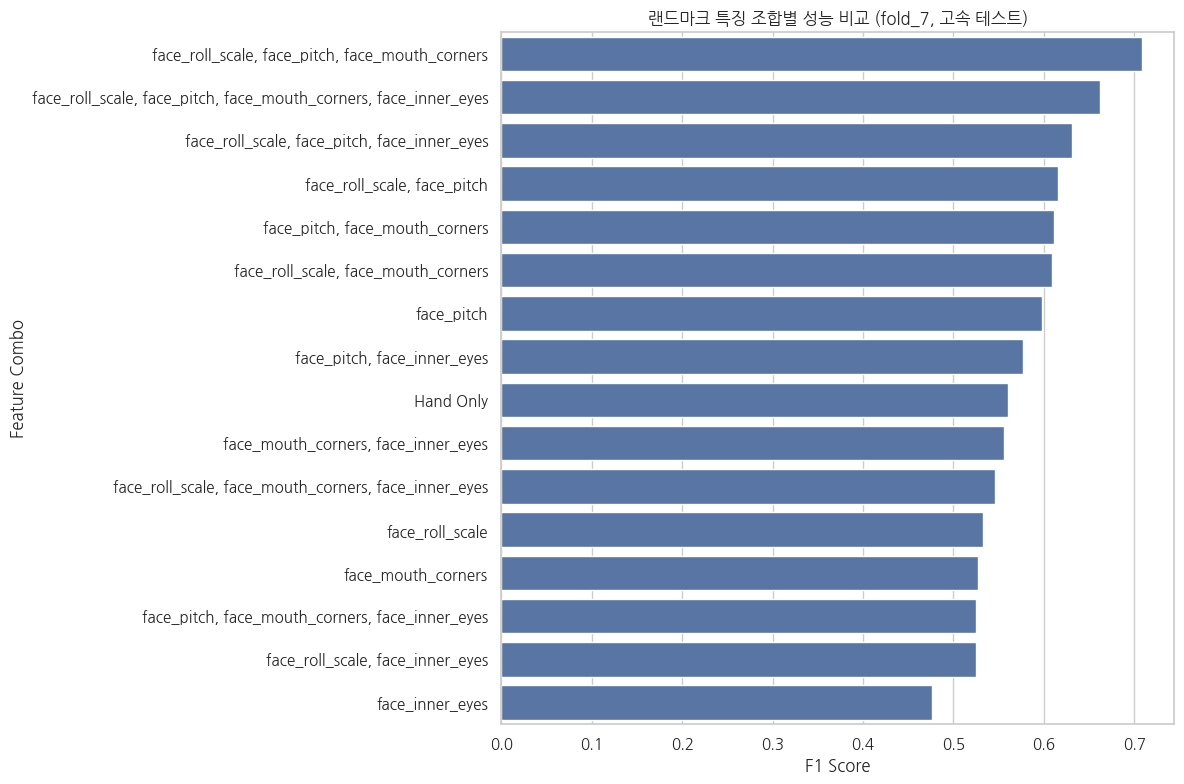


최적 특징 조합 (고속 테스트 기준): face_roll_scale, face_pitch, face_mouth_corners (F1: 0.7086)
{'hand_all': True, 'face_roll_scale': True, 'face_pitch': True, 'face_mouth_corners': True, 'face_inner_eyes': False}


In [ ]:
# === tqdm: 텍스트 기반으로 고정 (ipywidgets 불필요) ===
try:
    from tqdm import tqdm
except Exception:
    def tqdm(iterable=None, **kwargs):
        return iterable

# === Fold 유틸 ===
def norm_fold_id(fid):
    """정수/문자 어떤 입력이 와도 'fold_X'로 통일."""
    s = str(fid)
    return s if s.startswith("fold_") else f"fold_{int(s)}"

def fold_as_int(fid):
    """'fold_7' -> 7, 7 -> 7"""
    return int(str(fid).split('_')[-1])

# (이전 셀에서 tuning_fold_id가 정의되어 있다고 가정)
tuning_fold_id = norm_fold_id(tuning_fold_id)   # ex) 'fold_7'
tuning_fold_int = fold_as_int(tuning_fold_id)   # ex) 7

best_architecture = 'cnn_gru'
print(f"아키텍처를 '{best_architecture}'로 고정하여 테스트를 진행합니다.")

# === 특징 조합 설정 ===
face_features = ['face_roll_scale', 'face_pitch', 'face_mouth_corners', 'face_inner_eyes']
feature_combinations = list(itertools.product([True, False], repeat=len(face_features)))
feature_test_output_dir = 'outputs/step3_1_feature_test'
results_feature = {}

# === 경로/라벨 유틸 ===
def combo_label_from_flags(flags):
    """True인 특징만 라벨에 표시. 모두 False면 'Hand Only'."""
    names = [name for name, enabled in zip(face_features, flags) if enabled]
    return ", ".join(names) if names else "Hand Only"

def safe_dirname(label):
    """라벨을 디렉터리명으로 안전하게 변환."""
    return label.replace(", ", "_").replace("/", "-")

def report_path_for_combo(base_dir, label, fold_id):
    return os.path.join(base_dir, safe_dirname(label), 'models', fold_id, 'classification_report.csv')

# === 1) 모든 특징 조합 결과 존재 여부 확인 ===
all_results_exist = True
for combo in feature_combinations:
    label = combo_label_from_flags(combo)
    rp = report_path_for_combo(feature_test_output_dir, label, tuning_fold_id)
    if not os.path.exists(rp):
        all_results_exist = False
        break

# === 2) 결과 로드 또는 새로 실행 ===
if all_results_exist:
    print(f"✅ 기존 특징 조합 테스트 결과('{feature_test_output_dir}')를 찾았습니다. 결과를 재사용합니다.")
    for combo in tqdm(feature_combinations, desc="기존 결과 로드 중"):
        label = combo_label_from_flags(combo)
        rp = report_path_for_combo(feature_test_output_dir, label, tuning_fold_id)
        report_df = pd.read_csv(rp, index_col=0)
        results_feature[label] = float(report_df.loc['macro avg', 'f1-score'])
else:
    print("기존 특징 조합 테스트 결과가 없거나 불완전합니다. 새로 테스트를 시작합니다.")
    for combo in tqdm(feature_combinations, desc="특징 조합 탐색 진행률"):
        feature_dict = dict(zip(face_features, combo))
        feature_dict['hand_all'] = True

        label = combo_label_from_flags(combo)
        print(f"\n===== 특징 조합 테스트: {label} =====")

        test_cfg = copy.deepcopy(config.MANUAL_CONFIG)
        test_cfg['paths']['OUTPUT_DIR'] = os.path.join(feature_test_output_dir, safe_dirname(label))
        test_cfg['model_arch']['variant'] = best_architecture
        test_cfg['feature_extraction']['FEATURE_CONFIG'] = feature_dict

        # 고속 테스트 세팅
        test_cfg['training']['epochs'] = 30
        test_cfg['training']['early_stopping_patience'] = 5

        # run_single_fold는 정수 fold 사용
        f1 = run_single_fold(test_cfg, fold_id=tuning_fold_int, data_subset_fraction=0.3)
        results_feature[label] = f1

# === 3) 시각화 및 최적 조합 ===
if not results_feature:
    raise RuntimeError("특징 조합 결과가 비어 있습니다. 상위 단계 실행을 확인하세요.")

results_df = (
    pd.DataFrame(list(results_feature.items()), columns=['Feature Combo', 'F1 Score'])
    .sort_values('F1 Score', ascending=False)
)

plt.figure(figsize=(12, 8))
sns.barplot(x='F1 Score', y='Feature Combo', data=results_df, orient='h',
            order=results_df['Feature Combo'])
plt.title(f'랜드마크 특징 조합별 성능 비교 ({tuning_fold_id}, 고속 테스트)')
plt.xlabel('Macro F1 Score')
plt.ylabel('Feature Combination')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

best_feature_combo_name = results_df.iloc[0]['Feature Combo']
selected_features = [] if best_feature_combo_name == "Hand Only" else best_feature_combo_name.split(", ")
best_feature_config = {'hand_all': True, **{f: (f in selected_features) for f in face_features}}

print(f"\n최적 특징 조합 (고속 테스트 기준): {best_feature_combo_name} "
      f"(F1: {results_df.iloc[0]['F1 Score']:.4f})")
print(best_feature_config)


# # 시계열 특징(`TEMPORAL_FEATURES`) 조합

⏱️ 시계열 특징 조합 탐색 (단일 Fold, 고속 테스트)

기준 폴드({tuning_fold_id})와 고정 아키텍처({best_architecture})에서
velocity, acceleration, segment_stats의 사용/미사용 조합을 전수 탐색하여 Macro F1을 비교합니다.
모든 시계열 플래그가 False면 Position Only로 간주합니다.

🔧 절차

조합 생성: itertools.product로 2³=8개 조합 생성

캐시 확인: 각 조합의 classification_report.csv가 모두 존재하면 재사용, 아니면 재학습

학습(고속): epochs=30, early_stopping_patience=5, data_subset_fraction=0.3

정리/시각화: 수평 막대그래프로 성능 비교 → 최고 조합/설정 출력

📂 결과 경로 규칙
outputs/step3_2_temporal_test/<Temporal_Combo_Dir>/models/{tuning_fold_id}/classification_report.csv


<Temporal_Combo_Dir>: 라벨의 “, ”를 “_”로 치환 (예: velocity_segment_stats)

기존 시계열 특징 테스트 결과가 없거나 불완전합니다. 새로 테스트를 시작합니다.



===== 시계열 특징 조합 테스트: velocity, acceleration, segment_stats =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.43163, saving model to outputs/step3_2_temporal_test\velocity_acceleration_segment_stats\models\fold_7\best_model.keras
178/178 - 6s - 32ms/step - accuracy: 0.2891 - loss: 2.1980 - val_accuracy: 0.5412 - val_loss: 1.4316 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.43163 to 0.82791, saving model to outputs/step3_2_temporal_test\velocity_acceleration_segment_stats\models\fold_7\best_model.keras
178/178 - 3s - 17ms/step - accuracy: 0.5185 - loss: 1.4920 - val_accuracy: 0.7524 - val_loss: 0.8279 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.82791 to 0.61240, saving model to outputs/step3_2_temporal_test\velocity_acceleration_segment_stats\models\fold_7\best_model.keras
178/178 - 3s - 17ms/step - accuracy: 0.6632 - loss: 1.0863 - val_accuracy: 0.8132 - val_loss: 0.6124 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.61240 to 0.46441, saving model to outpu

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.7086 ---

===== 시계열 특징 조합 테스트: velocity, acceleration =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---





































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:33<00:00, 32.80it/s]








































































































































































































































































청크 병합: 100%|██████████| 1111/1111 [00:09<00:00, 113.67it/s]


학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.44878, saving model to outputs/step3_2_temporal_test\velocity_acceleration\models\fold_7\best_model.keras
178/178 - 6s - 36ms/step - accuracy: 0.2887 - loss: 2.1648 - val_accuracy: 0.5703 - val_loss: 1.4488 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.44878 to 1.05470, saving model to outputs/step3_2_temporal_test\velocity_acceleration\models\fold_7\best_model.keras
178/178 - 4s - 21ms/step - accuracy: 0.4782 - loss: 1.6044 - val_accuracy: 0.6997 - val_loss: 1.0547 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.05470 to 0.78936, saving model to outputs/step3_2_temporal_test\velocity_acceleration\models\fold_7\best_model.keras
178/178 - 4s - 21ms/step - accuracy: 0.5986 - loss: 1.2623 - val_accuracy: 0.7690 - val_loss: 0.7894 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.78936 to 0.57092, saving model to outputs/step3_2_temporal_test\velocity_accelera

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6237 ---

===== 시계열 특징 조합 테스트: velocity, segment_stats =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---











































































































































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:37<00:00, 29.78it/s]


































































































































































































































































학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.47835, saving model to outputs/step3_2_temporal_test\velocity_segment_stats\models\fold_7\best_model.keras
178/178 - 7s - 37ms/step - accuracy: 0.2710 - loss: 2.2121 - val_accuracy: 0.5068 - val_loss: 1.4783 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.47835 to 1.09747, saving model to outputs/step3_2_temporal_test\velocity_segment_stats\models\fold_7\best_model.keras
178/178 - 4s - 25ms/step - accuracy: 0.4648 - loss: 1.6287 - val_accuracy: 0.6593 - val_loss: 1.0975 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.09747 to 0.75777, saving model to outputs/step3_2_temporal_test\velocity_segment_stats\models\fold_7\best_model.keras
178/178 - 4s - 25ms/step - accuracy: 0.5839 - loss: 1.2889 - val_accuracy: 0.7804 - val_loss: 0.7578 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.75777 to 0.58929, saving model to outputs/step3_2_temporal_test\velocity_segme

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5589 ---

===== 시계열 특징 조합 테스트: velocity =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---











































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:34<00:00, 32.09it/s]































































































































































































































































청크 병합: 100%|██████████| 1111/1111 [00:09<00:00, 117.50it/s]


학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.69004, saving model to outputs/step3_2_temporal_test\velocity\models\fold_7\best_model.keras
178/178 - 6s - 34ms/step - accuracy: 0.2375 - loss: 2.3230 - val_accuracy: 0.4306 - val_loss: 1.6900 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.69004 to 1.30391, saving model to outputs/step3_2_temporal_test\velocity\models\fold_7\best_model.keras
178/178 - 3s - 20ms/step - accuracy: 0.4059 - loss: 1.7845 - val_accuracy: 0.5962 - val_loss: 1.3039 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.30391 to 0.97622, saving model to outputs/step3_2_temporal_test\velocity\models\fold_7\best_model.keras
178/178 - 3s - 19ms/step - accuracy: 0.5246 - loss: 1.4760 - val_accuracy: 0.6962 - val_loss: 0.9762 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.97622 to 0.75716, saving model to outputs/step3_2_temporal_test\velocity\models\fold_7\best_model.keras
178/178 - 4s - 2

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.7116 ---

===== 시계열 특징 조합 테스트: acceleration, segment_stats =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
















































































































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:37<00:00, 29.79it/s]





























































































































































































































































































학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.49822, saving model to outputs/step3_2_temporal_test\acceleration_segment_stats\models\fold_7\best_model.keras
178/178 - 6s - 36ms/step - accuracy: 0.2746 - loss: 2.2062 - val_accuracy: 0.5017 - val_loss: 1.4982 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.49822 to 1.11673, saving model to outputs/step3_2_temporal_test\acceleration_segment_stats\models\fold_7\best_model.keras
178/178 - 4s - 22ms/step - accuracy: 0.4634 - loss: 1.6246 - val_accuracy: 0.6484 - val_loss: 1.1167 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.11673 to 0.76039, saving model to outputs/step3_2_temporal_test\acceleration_segment_stats\models\fold_7\best_model.keras
178/178 - 4s - 22ms/step - accuracy: 0.5763 - loss: 1.2915 - val_accuracy: 0.7717 - val_loss: 0.7604 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.76039 to 0.61728, saving model to outputs/step3_2_temporal_test\ac

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6361 ---

===== 시계열 특징 조합 테스트: acceleration =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---














































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:34<00:00, 32.52it/s]

















































































































































































































































































청크 병합: 100%|██████████| 1111/1111 [00:10<00:00, 105.34it/s]


학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.70137, saving model to outputs/step3_2_temporal_test\acceleration\models\fold_7\best_model.keras
178/178 - 9s - 48ms/step - accuracy: 0.2430 - loss: 2.3228 - val_accuracy: 0.4381 - val_loss: 1.7014 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.70137 to 1.31558, saving model to outputs/step3_2_temporal_test\acceleration\models\fold_7\best_model.keras
178/178 - 4s - 22ms/step - accuracy: 0.4086 - loss: 1.7858 - val_accuracy: 0.6007 - val_loss: 1.3156 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.31558 to 1.00398, saving model to outputs/step3_2_temporal_test\acceleration\models\fold_7\best_model.keras
178/178 - 4s - 22ms/step - accuracy: 0.5153 - loss: 1.4850 - val_accuracy: 0.6782 - val_loss: 1.0040 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.00398 to 0.82154, saving model to outputs/step3_2_temporal_test\acceleration\models\fold_7\best_model.keras


--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6702 ---

===== 시계열 특징 조합 테스트: segment_stats =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---









































































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:34<00:00, 31.96it/s]

















































































































































































































































































청크 병합: 100%|██████████| 1111/1111 [00:10<00:00, 1

학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.52565, saving model to outputs/step3_2_temporal_test\segment_stats\models\fold_7\best_model.keras
178/178 - 7s - 38ms/step - accuracy: 0.2718 - loss: 2.2076 - val_accuracy: 0.5067 - val_loss: 1.5257 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.52565 to 1.14720, saving model to outputs/step3_2_temporal_test\segment_stats\models\fold_7\best_model.keras
178/178 - 4s - 24ms/step - accuracy: 0.4549 - loss: 1.6603 - val_accuracy: 0.6565 - val_loss: 1.1472 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.14720 to 0.95167, saving model to outputs/step3_2_temporal_test\segment_stats\models\fold_7\best_model.keras
178/178 - 4s - 24ms/step - accuracy: 0.5554 - loss: 1.3821 - val_accuracy: 0.7102 - val_loss: 0.9517 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.95167 to 0.80093, saving model to outputs/step3_2_temporal_test\segment_stats\models\fold_7\best_model.ke

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6961 ---

===== 시계열 특징 조합 테스트: Position Only =====
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---


























































































































































































































































































































































































































































































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:33<00:00, 33.09it/s]



























































































































































































































청크 병합: 100%|██████████| 1111/1111 [00:07<00:00, 139.20it/s]


학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.65252, saving model to outputs/step3_2_temporal_test\Position Only\models\fold_7\best_model.keras
178/178 - 6s - 35ms/step - accuracy: 0.2523 - loss: 2.2895 - val_accuracy: 0.4567 - val_loss: 1.6525 - learning_rate: 3.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.65252 to 1.18868, saving model to outputs/step3_2_temporal_test\Position Only\models\fold_7\best_model.keras
178/178 - 4s - 21ms/step - accuracy: 0.4335 - loss: 1.7277 - val_accuracy: 0.6469 - val_loss: 1.1887 - learning_rate: 3.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.18868 to 0.96975, saving model to outputs/step3_2_temporal_test\Position Only\models\fold_7\best_model.keras
178/178 - 4s - 21ms/step - accuracy: 0.5486 - loss: 1.4051 - val_accuracy: 0.6963 - val_loss: 0.9698 - learning_rate: 3.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.96975 to 0.82696, saving model to outputs/step3_2_temporal_test\Position Only\models\fold_7\best_model.ke



시계열 특징 조합 탐색: 100%|██████████| 8/8 [23:13<00:00, 174.16s/it]

--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5841 ---


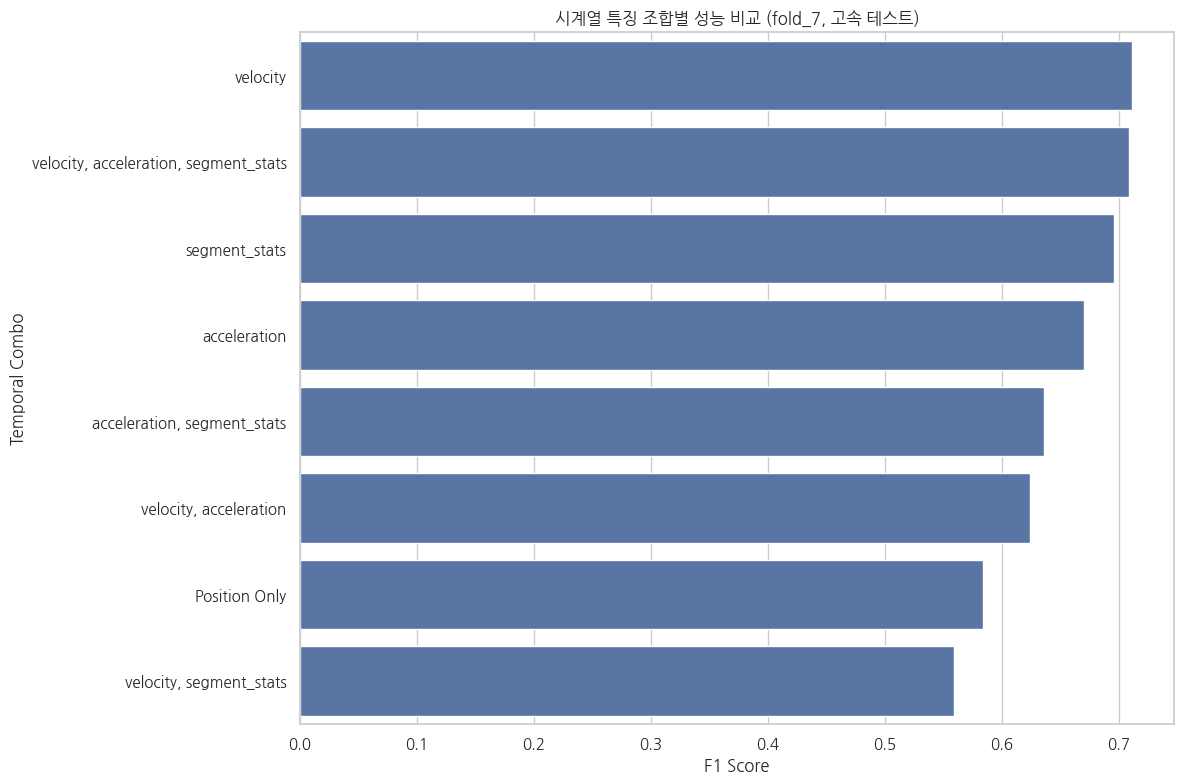


최적 시계열 특징 조합 (고속 테스트 기준): velocity (F1: 0.7116)
{'velocity': True, 'acceleration': False, 'segment_stats': False}


In [ ]:
# === tqdm: 텍스트 기반으로 고정 (ipywidgets 불필요) ===
try:
    from tqdm import tqdm
except Exception:
    def tqdm(iterable=None, **kwargs):
        return iterable

# === Fold 유틸 (앞에서 정의돼 있으면 생략 가능) ===
def norm_fold_id(fid):
    s = str(fid)
    return s if s.startswith("fold_") else f"fold_{int(s)}"

def fold_as_int(fid):
    return int(str(fid).split('_')[-1])

tuning_fold_id = norm_fold_id(tuning_fold_id)   # ex) 'fold_7'
tuning_fold_int = fold_as_int(tuning_fold_id)   # ex) 7

# === 시계열 특징 조합 설정 ===
temporal_features = ['velocity', 'acceleration', 'segment_stats']
temporal_combinations = list(itertools.product([True, False], repeat=len(temporal_features)))
temporal_test_output_dir = 'outputs/step3_2_temporal_test'
results_temporal = {}

# === 라벨/경로 유틸 ===
def combo_label_from_flags(names, flags, empty_label="Position Only"):
    chosen = [n for n, f in zip(names, flags) if f]
    return ", ".join(chosen) if chosen else empty_label

def safe_dirname(label: str) -> str:
    return label.replace(", ", "_").replace("/", "-")

def report_path(base_dir, label, fold_id):
    return os.path.join(base_dir, safe_dirname(label), 'models', fold_id, 'classification_report.csv')

# === 1) 모든 시계열 조합 결과 존재 여부 확인 ===
all_results_exist = True
for combo in temporal_combinations:
    label = combo_label_from_flags(temporal_features, combo)
    rp = report_path(temporal_test_output_dir, label, tuning_fold_id)
    if not os.path.exists(rp):
        all_results_exist = False
        break

# === 2) 결과 로드 또는 새로 실행 ===
if all_results_exist:
    print(f"✅ 기존 시계열 특징 테스트 결과('{temporal_test_output_dir}')를 찾았습니다. 결과를 재사용합니다.")
    for combo in tqdm(temporal_combinations, desc="기존 결과 로드 중"):
        label = combo_label_from_flags(temporal_features, combo)
        rp = report_path(temporal_test_output_dir, label, tuning_fold_id)
        report_df = pd.read_csv(rp, index_col=0)
        results_temporal[label] = float(report_df.loc['macro avg', 'f1-score'])
else:
    print("기존 시계열 특징 테스트 결과가 없거나 불완전합니다. 새로 테스트를 시작합니다.")
    for combo in tqdm(temporal_combinations, desc="시계열 특징 조합 탐색"):
        temporal_dict = dict(zip(temporal_features, combo))
        label = combo_label_from_flags(temporal_features, combo)
        print(f"\n===== 시계열 특징 조합 테스트: {label} =====")

        test_cfg = copy.deepcopy(config.MANUAL_CONFIG)
        test_cfg['paths']['OUTPUT_DIR'] = os.path.join(temporal_test_output_dir, safe_dirname(label))
        test_cfg['model_arch']['variant'] = best_architecture
        test_cfg['feature_extraction']['FEATURE_CONFIG'] = best_feature_config
        test_cfg['feature_extraction']['TEMPORAL_FEATURES'] = temporal_dict

        # 고속 테스트 세팅
        test_cfg['training']['epochs'] = 30
        test_cfg['training']['early_stopping_patience'] = 5

        # run_single_fold는 정수 fold 사용
        f1 = run_single_fold(test_cfg, fold_id=tuning_fold_int, data_subset_fraction=0.3)
        results_temporal[label] = f1

# === 3) 시각화 및 최적 조합 저장 ===
if not results_temporal:
    raise RuntimeError("시계열 특징 조합 결과가 비어 있습니다. 상위 단계 실행을 확인하세요.")

results_df = (
    pd.DataFrame(list(results_temporal.items()), columns=['Temporal Combo', 'F1 Score'])
    .sort_values('F1 Score', ascending=False)
)

plt.figure(figsize=(12, 8))
sns.barplot(x='F1 Score', y='Temporal Combo', data=results_df, orient='h',
            order=results_df['Temporal Combo'])
plt.title(f'시계열 특징 조합별 성능 비교 ({tuning_fold_id}, 고속 테스트)')
plt.xlabel('Macro F1 Score')
plt.ylabel('Temporal Combination')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

best_temporal_combo_name = results_df.iloc[0]['Temporal Combo']
selected_temporal = [] if best_temporal_combo_name == "Position Only" else best_temporal_combo_name.split(", ")
best_temporal_config = {f: (f in selected_temporal) for f in temporal_features}

print(f"\n최적 시계열 특징 조합 (고속 테스트 기준): {best_temporal_combo_name} "
      f"(F1: {results_df.iloc[0]['F1 Score']:.4f})")
print(best_temporal_config)



# # 최종 하이퍼파라미터 튜닝 (Optuna)

🔍 Optuna 기반 단일 Fold 하이퍼파라미터 탐색

이전 단계에서 고정한 아키텍처 / 특징 조합을 사용하고,
**기준 폴드({tuning_fold_id})**에서 데이터 30% 서브셋으로 빠르게 Optuna 탐색을 수행합니다.

⚙️ 구성

베이스 설정:

model_arch.variant = {best_architecture}

FEATURE_CONFIG = best_feature_config

TEMPORAL_FEATURES = best_temporal_config

탐색 대상: config.define_search_space(trial)에서 정의

실행 전략:

run_single_fold(cfg, fold_id={fold_as_int(tuning_fold_id)}, data_subset_fraction=0.3)

epochs=30, early_stopping_patience=5 (고속)

저장 위치:

각 Trial: outputs/step3_3_optuna/trial_<N>/

Study DB: outputs/optuna_study.db (SQLite)

In [ ]:

# === Fold 유틸 (앞 셀에서 정의되어 있으면 생략 가능) ===
def norm_fold_id(fid):
    s = str(fid)
    return s if s.startswith("fold_") else f"fold_{int(s)}"

def fold_as_int(fid):
    return int(str(fid).split('_')[-1])


# === 1) 이전 단계 최적값으로 베이스 설정 생성 ===
best_config_base = copy.deepcopy(config.MANUAL_CONFIG)
best_config_base['model_arch']['variant'] = best_architecture
best_config_base['feature_extraction']['FEATURE_CONFIG'] = best_feature_config
best_config_base['feature_extraction']['TEMPORAL_FEATURES'] = best_temporal_config

# Fold ID 안전 처리
tuning_fold_id = norm_fold_id(tuning_fold_id)     # ex) 'fold_7'
tuning_fold_int = fold_as_int(tuning_fold_id)     # ex) 7

# 출력 루트 보장
optuna_out_root = 'outputs/step3_3_optuna'
os.makedirs(optuna_out_root, exist_ok=True)


# === 2) Optuna 목적 함수 (단일 폴드, 30% 서브셋) ===
def objective_single_fold(trial: optuna.Trial) -> float:
    # 탐색 공간 정의(사용자 구현 함수)
    cfg = config.define_search_space(trial)

    # 고정 파라미터 적용
    cfg['paths']['OUTPUT_DIR'] = os.path.join(optuna_out_root, f"trial_{trial.number}")
    os.makedirs(cfg['paths']['OUTPUT_DIR'], exist_ok=True)

    cfg['model_arch']['variant'] = best_config_base['model_arch']['variant']
    cfg['feature_extraction']['FEATURE_CONFIG'] = best_config_base['feature_extraction']['FEATURE_CONFIG']
    cfg['feature_extraction']['TEMPORAL_FEATURES'] = best_config_base['feature_extraction']['TEMPORAL_FEATURES']

    # 고속 설정
    cfg['training']['epochs'] = 30
    cfg['training']['early_stopping_patience'] = 5

    # 단일 폴드 실행 (정수 fold 권장)
    score = run_single_fold(cfg, fold_id=tuning_fold_int, data_subset_fraction=0.3)

    # Optuna는 목적값이 float이어야 함
    return float(score)


# === 3) Study 생성 및 최적화 ===
study_db_path = "sqlite:///outputs/optuna_study.db"
os.makedirs("outputs", exist_ok=True)  # DB 경로 보장

study = optuna.create_study(
    direction='maximize',
    study_name='Single_Fold_HPO_v2',
    storage=study_db_path,
    load_if_exists=True,
)

n_trials = 50
done = len(study.trials)
remaining = max(0, n_trials - done)

with tqdm(total=remaining, desc="Optuna 하이퍼파라미터 탐색") as pbar:
    if remaining > 0:
        def _tqdm_cb(study_, trial_):
            pbar.update(1)
        study.optimize(objective_single_fold, n_trials=remaining, callbacks=[_tqdm_cb])

# === 4) 최적 결과 출력 ===
print("\n===== Optuna 최적화 완료 =====")
print(f"총 {len(study.trials)}개의 Trial 중 최고 성능 Macro F1: {study.best_value:.4f}")
print("최적 하이퍼파라미터:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")


[I 2025-09-08 18:05:12,866] A new study created in RDB with name: Single_Fold_HPO_v2




--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---

























































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:15<00:00, 69.93it/s] 








































































































































































































































































청크 병합: 100%|██████████| 1111/1111 [00:10<00:00, 110.68it/s]


학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.88404, saving model to outputs/step3_3_optuna\trial_0\models\fold_7\best_model.keras
78/78 - 7s - 91ms/step - accuracy: 0.2082 - loss: 2.4121 - val_accuracy: 0.4043 - val_loss: 1.8840 - learning_rate: 1.3818e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.88404 to 1.60561, saving model to outputs/step3_3_optuna\trial_0\models\fold_7\best_model.keras
78/78 - 5s - 61ms/step - accuracy: 0.3342 - loss: 2.0047 - val_accuracy: 0.4846 - val_loss: 1.6056 - learning_rate: 1.3818e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.60561 to 1.38413, saving model to outputs/step3_3_optuna\trial_0\models\fold_7\best_model.keras
78/78 - 5s - 62ms/step - accuracy: 0.4033 - loss: 1.7936 - val_accuracy: 0.5724 - val_loss: 1.3841 - learning_rate: 1.3818e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.38413 to 1.24104, saving model to outputs/step3_3_optuna\trial_0\models\fold_7\best_model.keras
78/78 - 5s - 62ms/step - accuracy: 0.4649 - loss: 1.64

[I 2025-09-08 18:08:53,071] Trial 0 finished with value: 0.4985587857039703 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 256, 'gru2_units': 64, 'dense_units': 32, 'dropout_rate': 0.34888210283451576, 'l2': 4.183005726872174e-05, 'cf_filters': 64, 'cf_kernel': 7, 'cf_pool': 2, 'cf_drop': 0.0, 'cf_l2': 9.358328862556192e-05, 'learning_rate': 0.00013817747664768122, 'batch_size': 128}. Best is trial 0 with value: 0.4985587857039703.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.4986 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---


















































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:30<00:00, 36.67it/s] 

















































































































































































































































































































































































청크 병합: 100%|██████████| 1111/1111 [00:13<00:00, 80.17it/s]


학습 데이터가 6924개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.45524, saving model to outputs/step3_3_optuna\trial_1\models\fold_7\best_model.keras
109/109 - 9s - 85ms/step - accuracy: 0.3018 - loss: 2.0755 - val_accuracy: 0.5604 - val_loss: 1.4552 - learning_rate: 6.5982e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.45524 to 0.93679, saving model to outputs/step3_3_optuna\trial_1\models\fold_7\best_model.keras
109/109 - 4s - 33ms/step - accuracy: 0.4896 - loss: 1.5354 - val_accuracy: 0.7280 - val_loss: 0.9368 - learning_rate: 6.5982e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.93679 to 0.69794, saving model to outputs/step3_3_optuna\trial_1\models\fold_7\best_model.keras
109/109 - 2s - 20ms/step - accuracy: 0.6083 - loss: 1.1942 - val_accuracy: 0.7833 - val_loss: 0.6979 - learning_rate: 6.5982e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.69794 to 0.59933, saving model to outputs/step3_3_optuna\trial_1\models\fold_7\best_model.keras
109/109 - 2s - 20ms/step - accuracy: 0.7039 - lo

[I 2025-09-08 18:11:09,882] Trial 1 finished with value: 0.5268810847635079 and parameters: {'WINDOW_SIZE': 30, 'STRIDE': 5, 'gru1_units': 160, 'gru2_units': 64, 'dense_units': 64, 'dropout_rate': 0.45845788468053517, 'l2': 1.3790211087895705e-05, 'cf_filters': 48, 'cf_kernel': 5, 'cf_pool': 2, 'cf_drop': 0.1, 'cf_l2': 0.00011241734941679379, 'learning_rate': 0.0006598191962716286, 'batch_size': 64}. Best is trial 1 with value: 0.5268810847635079.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5269 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---

















































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:19<00:00, 57.42it/s] 















































































































































































































































































































청크 병합: 100%|██████████| 1111/1111 [00:11<00:00, 97.00it/s]


학습 데이터가 29365개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 0.58684, saving model to outputs/step3_3_optuna\trial_2\models\fold_7\best_model.keras
306/306 - 6s - 20ms/step - accuracy: 0.4873 - loss: 1.5437 - val_accuracy: 0.8380 - val_loss: 0.5868 - learning_rate: 6.1373e-04
Epoch 2/30

Epoch 2: val_loss improved from 0.58684 to 0.28566, saving model to outputs/step3_3_optuna\trial_2\models\fold_7\best_model.keras
306/306 - 4s - 14ms/step - accuracy: 0.7662 - loss: 0.7184 - val_accuracy: 0.9090 - val_loss: 0.2857 - learning_rate: 6.1373e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.28566 to 0.19404, saving model to outputs/step3_3_optuna\trial_2\models\fold_7\best_model.keras
306/306 - 4s - 15ms/step - accuracy: 0.8546 - loss: 0.4591 - val_accuracy: 0.9378 - val_loss: 0.1940 - learning_rate: 6.1373e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.19404 to 0.13163, saving model to outputs/step3_3_optuna\trial_2\models\fold_7\best_model.keras
306/306 - 4s - 14ms/step - accuracy: 0.8937 - lo

[I 2025-09-08 18:14:10,421] Trial 2 finished with value: 0.6388116314073684 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 1, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 64, 'dropout_rate': 0.5177684114485722, 'l2': 1.877009946833477e-05, 'cf_filters': 64, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 3.564658329261417e-05, 'learning_rate': 0.0006137308080007238, 'batch_size': 96}. Best is trial 2 with value: 0.6388116314073684.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6388 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:19<00:00, 57.60it/s] 





















































































































































































































































































































청크 병합: 100%|██████████| 1111/1111 [00:12<00:00, 91.66it/s]


학습 데이터가 33515개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.20714, saving model to outputs/step3_3_optuna\trial_3\models\fold_7\best_model.keras
262/262 - 10s - 37ms/step - accuracy: 0.3780 - loss: 1.9536 - val_accuracy: 0.6288 - val_loss: 1.2071 - learning_rate: 1.9337e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.20714 to 0.72644, saving model to outputs/step3_3_optuna\trial_3\models\fold_7\best_model.keras
262/262 - 7s - 28ms/step - accuracy: 0.6091 - loss: 1.2681 - val_accuracy: 0.7908 - val_loss: 0.7264 - learning_rate: 1.9337e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.72644 to 0.50244, saving model to outputs/step3_3_optuna\trial_3\models\fold_7\best_model.keras
262/262 - 7s - 28ms/step - accuracy: 0.7398 - loss: 0.8856 - val_accuracy: 0.8683 - val_loss: 0.5024 - learning_rate: 1.9337e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.50244 to 0.39152, saving model to outputs/step3_3_optuna\trial_3\models\fold_7\best_model.keras
262/262 - 7s - 28ms/step - accuracy: 0.8089 - l

[I 2025-09-08 18:19:37,709] Trial 3 finished with value: 0.623058673891697 and parameters: {'WINDOW_SIZE': 30, 'STRIDE': 1, 'gru1_units': 128, 'gru2_units': 96, 'dense_units': 96, 'dropout_rate': 0.3927585481820283, 'l2': 0.00023295102242852417, 'cf_filters': 64, 'cf_kernel': 7, 'cf_pool': 2, 'cf_drop': 0.0, 'cf_l2': 5.531769709054302e-05, 'learning_rate': 0.00019337223835385302, 'batch_size': 128}. Best is trial 2 with value: 0.6388116314073684.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6231 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---




































































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:28<00:00, 38.62it/s] 

























































































































































































































































































































































청크 병합: 100%|██████████| 1111/1111 [00:13<00:00, 83.53it/s]


학습 데이터가 7754개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.93266, saving model to outputs/step3_3_optuna\trial_4\models\fold_7\best_model.keras
61/61 - 5s - 89ms/step - accuracy: 0.1729 - loss: 2.4829 - val_accuracy: 0.3751 - val_loss: 1.9327 - learning_rate: 2.5369e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.93266 to 1.66127, saving model to outputs/step3_3_optuna\trial_4\models\fold_7\best_model.keras
61/61 - 1s - 15ms/step - accuracy: 0.3053 - loss: 2.0770 - val_accuracy: 0.4393 - val_loss: 1.6613 - learning_rate: 2.5369e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.66127 to 1.47629, saving model to outputs/step3_3_optuna\trial_4\models\fold_7\best_model.keras
61/61 - 1s - 15ms/step - accuracy: 0.3732 - loss: 1.8443 - val_accuracy: 0.4816 - val_loss: 1.4763 - learning_rate: 2.5369e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.47629 to 1.33575, saving model to outputs/step3_3_optuna\trial_4\models\fold_7\best_model.keras
61/61 - 1s - 16ms/step - accuracy: 0.4391 - loss: 1.67

[I 2025-09-08 18:21:04,896] Trial 4 finished with value: 0.4616450669882331 and parameters: {'WINDOW_SIZE': 15, 'STRIDE': 5, 'gru1_units': 128, 'gru2_units': 64, 'dense_units': 64, 'dropout_rate': 0.3443101071099264, 'l2': 6.416495467205229e-05, 'cf_filters': 48, 'cf_kernel': 5, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 1.0616607937172173e-05, 'learning_rate': 0.00025369152225300246, 'batch_size': 128}. Best is trial 2 with value: 0.6388116314073684.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.4616 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---

























































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:18<00:00, 59.04it/s] 












































































































































































































































































































청크 병합: 100%|██████████| 1111/1111 [00:11<00:00, 97.52it/s]


학습 데이터가 6094개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 2.04575, saving model to outputs/step3_3_optuna\trial_5\models\fold_7\best_model.keras
48/48 - 6s - 121ms/step - accuracy: 0.1400 - loss: 2.5497 - val_accuracy: 0.3855 - val_loss: 2.0457 - learning_rate: 2.8060e-04
Epoch 2/30

Epoch 2: val_loss improved from 2.04575 to 1.66853, saving model to outputs/step3_3_optuna\trial_5\models\fold_7\best_model.keras
48/48 - 3s - 62ms/step - accuracy: 0.2873 - loss: 2.1195 - val_accuracy: 0.4544 - val_loss: 1.6685 - learning_rate: 2.8060e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.66853 to 1.39012, saving model to outputs/step3_3_optuna\trial_5\models\fold_7\best_model.keras
48/48 - 3s - 64ms/step - accuracy: 0.3814 - loss: 1.8299 - val_accuracy: 0.5696 - val_loss: 1.3901 - learning_rate: 2.8060e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.39012 to 1.13944, saving model to outputs/step3_3_optuna\trial_5\models\fold_7\best_model.keras
48/48 - 3s - 60ms/step - accuracy: 0.4769 - loss: 1.5

[I 2025-09-08 18:23:13,223] Trial 5 finished with value: 0.5572818211698163 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 5, 'gru1_units': 128, 'gru2_units': 64, 'dense_units': 96, 'dropout_rate': 0.3526428135581585, 'l2': 4.543083780465704e-05, 'cf_filters': 64, 'cf_kernel': 3, 'cf_pool': 2, 'cf_drop': 0.2, 'cf_l2': 1.0836138902170862e-05, 'learning_rate': 0.00028059556805022336, 'batch_size': 128}. Best is trial 2 with value: 0.6388116314073684.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5573 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---



























































































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:31<00:00, 35.12it/s] 















































































































































































































































































































































































































청크 병합: 100%|██████████| 1111/1111 [00:15<00:00, 71.45it/s]


학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 2.08959, saving model to outputs/step3_3_optuna\trial_6\models\fold_7\best_model.keras
89/89 - 9s - 97ms/step - accuracy: 0.1502 - loss: 2.6139 - val_accuracy: 0.3305 - val_loss: 2.0896 - learning_rate: 2.3273e-04
Epoch 2/30

Epoch 2: val_loss improved from 2.08959 to 1.81213, saving model to outputs/step3_3_optuna\trial_6\models\fold_7\best_model.keras
89/89 - 3s - 37ms/step - accuracy: 0.2711 - loss: 2.1811 - val_accuracy: 0.3916 - val_loss: 1.8121 - learning_rate: 2.3273e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.81213 to 1.65030, saving model to outputs/step3_3_optuna\trial_6\models\fold_7\best_model.keras
89/89 - 2s - 18ms/step - accuracy: 0.3366 - loss: 1.9884 - val_accuracy: 0.4441 - val_loss: 1.6503 - learning_rate: 2.3273e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.65030 to 1.51008, saving model to outputs/step3_3_optuna\trial_6\models\fold_7\best_model.keras
89/89 - 2s - 18ms/step - accuracy: 0.3827 - loss: 1.83

[I 2025-09-08 18:25:16,509] Trial 6 finished with value: 0.4923913029174484 and parameters: {'WINDOW_SIZE': 30, 'STRIDE': 3, 'gru1_units': 96, 'gru2_units': 64, 'dense_units': 64, 'dropout_rate': 0.5886597826800236, 'l2': 8.760278108778674e-05, 'cf_filters': 48, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.2, 'cf_l2': 1.547198903040639e-05, 'learning_rate': 0.00023272623593032413, 'batch_size': 128}. Best is trial 2 with value: 0.6388116314073684.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.4924 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 7754개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.45642, saving model to outputs/step3_3_optuna\trial_7\models\fold_7\best_model.keras
122/122 - 3s - 24ms/step - accuracy: 0.2975 - loss: 2.0712 - val_accuracy: 0.5723 - val_loss: 1.4564 - learning_rate: 4.3038e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.45642 to 0.93524, saving model to outputs/step3_3_optuna\trial_7\models\fold_7\best_model.keras
122/122 - 1s - 10ms/step - accuracy: 0.4981 - loss: 1.4899 - val_accuracy: 0.7177 - val_loss: 0.9352 - learning_rate: 4.3038e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.93524 to 0.71999, saving model to outputs/step3_3_optuna\trial_7\models\fold_7\best_model.keras
122/122 - 1s - 10ms/step - accuracy: 0.6145 - loss: 1.1624 - val_accuracy: 0.7826 - val_loss: 0.7200 - learning_rate: 4.3038e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.71999 to 0.60212, saving model to outputs/step3_3_optuna\trial_7\models\fold_7\best_model.keras
122/122 - 1s - 11ms/step - accuracy: 0.6780 - lo

[I 2025-09-08 18:26:00,817] Trial 7 finished with value: 0.5253191032365042 and parameters: {'WINDOW_SIZE': 15, 'STRIDE': 5, 'gru1_units': 256, 'gru2_units': 0, 'dense_units': 96, 'dropout_rate': 0.5312332843298708, 'l2': 1.2209603825784977e-05, 'cf_filters': 48, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.0, 'cf_l2': 1.2164449391497758e-05, 'learning_rate': 0.00043038316820811985, 'batch_size': 64}. Best is trial 2 with value: 0.6388116314073684.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5253 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---




























































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:18<00:00, 59.53it/s] 





















































































































































































































































































































청크 병합: 100%|██████████| 1111/1111 [00:11<00:00, 94.40it/s]


학습 데이터가 37665개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 0.73801, saving model to outputs/step3_3_optuna\trial_8\models\fold_7\best_model.keras
393/393 - 12s - 31ms/step - accuracy: 0.4911 - loss: 1.5941 - val_accuracy: 0.7742 - val_loss: 0.7380 - learning_rate: 5.8780e-04
Epoch 2/30

Epoch 2: val_loss improved from 0.73801 to 0.50356, saving model to outputs/step3_3_optuna\trial_8\models\fold_7\best_model.keras
393/393 - 6s - 16ms/step - accuracy: 0.7406 - loss: 0.8621 - val_accuracy: 0.8533 - val_loss: 0.5036 - learning_rate: 5.8780e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.50356 to 0.39741, saving model to outputs/step3_3_optuna\trial_8\models\fold_7\best_model.keras
393/393 - 10s - 27ms/step - accuracy: 0.8051 - loss: 0.6618 - val_accuracy: 0.8826 - val_loss: 0.3974 - learning_rate: 5.8780e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.39741 to 0.30263, saving model to outputs/step3_3_optuna\trial_8\models\fold_7\best_model.keras
393/393 - 10s - 26ms/step - accuracy: 0.8459 -

[I 2025-09-08 18:30:18,417] Trial 8 finished with value: 0.5725193124887816 and parameters: {'WINDOW_SIZE': 15, 'STRIDE': 1, 'gru1_units': 96, 'gru2_units': 96, 'dense_units': 96, 'dropout_rate': 0.48794670894222497, 'l2': 0.0002542689696416619, 'cf_filters': 64, 'cf_kernel': 5, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 3.3869845763928826e-05, 'learning_rate': 0.0005877986759124606, 'batch_size': 96}. Best is trial 2 with value: 0.6388116314073684.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5725 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 29365개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.22021, saving model to outputs/step3_3_optuna\trial_9\models\fold_7\best_model.keras
306/306 - 13s - 41ms/step - accuracy: 0.3181 - loss: 2.0496 - val_accuracy: 0.6186 - val_loss: 1.2202 - learning_rate: 1.4919e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.22021 to 0.71889, saving model to outputs/step3_3_optuna\trial_9\models\fold_7\best_model.keras
306/306 - 10s - 32ms/step - accuracy: 0.5729 - loss: 1.2958 - val_accuracy: 0.7910 - val_loss: 0.7189 - learning_rate: 1.4919e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.71889 to 0.48478, saving model to outputs/step3_3_optuna\trial_9\models\fold_7\best_model.keras
306/306 - 10s - 32ms/step - accuracy: 0.7030 - loss: 0.9292 - val_accuracy: 0.8535 - val_loss: 0.4848 - learning_rate: 1.4919e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.48478 to 0.35966, saving model to outputs/step3_3_optuna\trial_9\models\fold_7\best_model.keras
306/306 - 10s - 33ms/step - accuracy: 0.7703 

[I 2025-09-08 18:35:59,033] Trial 9 finished with value: 0.602674001513331 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 1, 'gru1_units': 128, 'gru2_units': 96, 'dense_units': 64, 'dropout_rate': 0.36259774217862506, 'l2': 4.432698905333786e-05, 'cf_filters': 48, 'cf_kernel': 7, 'cf_pool': 2, 'cf_drop': 0.2, 'cf_l2': 3.0500043702872043e-05, 'learning_rate': 0.0001491911283367546, 'batch_size': 96}. Best is trial 2 with value: 0.6388116314073684.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6027 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 29365개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.14480, saving model to outputs/step3_3_optuna\trial_10\models\fold_7\best_model.keras
306/306 - 6s - 21ms/step - accuracy: 0.3265 - loss: 1.9987 - val_accuracy: 0.7005 - val_loss: 1.1448 - learning_rate: 3.7157e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.14480 to 0.63412, saving model to outputs/step3_3_optuna\trial_10\models\fold_7\best_model.keras
306/306 - 5s - 16ms/step - accuracy: 0.5533 - loss: 1.3417 - val_accuracy: 0.8486 - val_loss: 0.6341 - learning_rate: 3.7157e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.63412 to 0.39703, saving model to outputs/step3_3_optuna\trial_10\models\fold_7\best_model.keras
306/306 - 5s - 16ms/step - accuracy: 0.6712 - loss: 0.9952 - val_accuracy: 0.9067 - val_loss: 0.3970 - learning_rate: 3.7157e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.39703 to 0.28573, saving model to outputs/step3_3_optuna\trial_10\models\fold_7\best_model.keras
306/306 - 5s - 16ms/step - accuracy: 0.7358 

[I 2025-09-08 18:39:06,883] Trial 10 finished with value: 0.6558324397414802 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 1, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.5857731553524049, 'l2': 2.17231270042126e-05, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 0.00026302923188389915, 'learning_rate': 0.0003715699443102406, 'batch_size': 96}. Best is trial 10 with value: 0.6558324397414802.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6558 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 29365개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.06809, saving model to outputs/step3_3_optuna\trial_11\models\fold_7\best_model.keras
306/306 - 12s - 38ms/step - accuracy: 0.3467 - loss: 1.9481 - val_accuracy: 0.7148 - val_loss: 1.0681 - learning_rate: 4.0775e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.06809 to 0.56735, saving model to outputs/step3_3_optuna\trial_11\models\fold_7\best_model.keras
306/306 - 10s - 31ms/step - accuracy: 0.5821 - loss: 1.2619 - val_accuracy: 0.8653 - val_loss: 0.5674 - learning_rate: 4.0775e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.56735 to 0.35230, saving model to outputs/step3_3_optuna\trial_11\models\fold_7\best_model.keras
306/306 - 11s - 37ms/step - accuracy: 0.7016 - loss: 0.9114 - val_accuracy: 0.9147 - val_loss: 0.3523 - learning_rate: 4.0775e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.35230 to 0.26244, saving model to outputs/step3_3_optuna\trial_11\models\fold_7\best_model.keras
306/306 - 8s - 25ms/step - accuracy: 0.76

[I 2025-09-08 18:44:06,641] Trial 11 finished with value: 0.6448798240963777 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 1, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.573466301602085, 'l2': 2.2221063164991225e-05, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 0.0002620585724485123, 'learning_rate': 0.0004077526018071077, 'batch_size': 96}. Best is trial 10 with value: 0.6558324397414802.


--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6449 ---


--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.87460, saving model to outputs/step3_3_optuna\trial_12\models\fold_7\best_model.keras
104/104 - 7s - 69ms/step - accuracy: 0.1885 - loss: 2.3789 - val_accuracy: 0.4426 - val_loss: 1.8746 - learning_rate: 3.8218e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.87460 to 1.46331, saving model to outputs/step3_3_optuna\trial_12\models\fold_7\best_model.keras
104/104 - 4s - 43ms/step - accuracy: 0.3320 - loss: 1.9794 - val_accuracy: 0.5735 - val_loss: 1.4633 - learning_rate: 3.8218e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.46331 to 1.08998, saving model to outputs/step3_3_optuna\trial_12\models\fold_7\best_model.keras
104/104 - 5s - 51ms/step - accuracy: 0.4338 - loss: 1.6805 - val_accuracy: 0.6912 - val_loss: 1.0900 - learning_rate: 3.8218e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.08998 to 0.89690, saving model to outputs/step3_3_optuna\trial_12\models\fold_7\best_model.keras
104/104 - 5s - 48ms/step - accuracy: 0.4968 

[I 2025-09-08 18:46:37,495] Trial 12 finished with value: 0.6176424717710046 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.5923024917085505, 'l2': 2.386639023859599e-05, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 0.00028566245253586317, 'learning_rate': 0.00038217564269368165, 'batch_size': 96}. Best is trial 10 with value: 0.6558324397414802.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6176 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 29365개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 0.99590, saving model to outputs/step3_3_optuna\trial_13\models\fold_7\best_model.keras
306/306 - 14s - 45ms/step - accuracy: 0.3587 - loss: 1.9126 - val_accuracy: 0.7193 - val_loss: 0.9959 - learning_rate: 4.0756e-04
Epoch 2/30

Epoch 2: val_loss improved from 0.99590 to 0.52105, saving model to outputs/step3_3_optuna\trial_13\models\fold_7\best_model.keras
306/306 - 9s - 28ms/step - accuracy: 0.6093 - loss: 1.1796 - val_accuracy: 0.8691 - val_loss: 0.5211 - learning_rate: 4.0756e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.52105 to 0.32343, saving model to outputs/step3_3_optuna\trial_13\models\fold_7\best_model.keras
306/306 - 10s - 34ms/step - accuracy: 0.7196 - loss: 0.8564 - val_accuracy: 0.9204 - val_loss: 0.3234 - learning_rate: 4.0756e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.32343 to 0.22399, saving model to outputs/step3_3_optuna\trial_13\models\fold_7\best_model.keras
306/306 - 11s - 37ms/step - accuracy: 0.77

[I 2025-09-08 18:51:41,950] Trial 13 finished with value: 0.6127454329353714 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 1, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.5544602679953237, 'l2': 2.3957218762154602e-05, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 0.0002254827586861925, 'learning_rate': 0.0004075554026066012, 'batch_size': 96}. Best is trial 10 with value: 0.6558324397414802.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6127 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 33515개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.22935, saving model to outputs/step3_3_optuna\trial_14\models\fold_7\best_model.keras
350/350 - 13s - 36ms/step - accuracy: 0.3293 - loss: 2.0039 - val_accuracy: 0.6553 - val_loss: 1.2293 - learning_rate: 3.1822e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.22935 to 0.75770, saving model to outputs/step3_3_optuna\trial_14\models\fold_7\best_model.keras
350/350 - 9s - 27ms/step - accuracy: 0.5234 - loss: 1.4120 - val_accuracy: 0.7720 - val_loss: 0.7577 - learning_rate: 3.1822e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.75770 to 0.45655, saving model to outputs/step3_3_optuna\trial_14\models\fold_7\best_model.keras
350/350 - 8s - 23ms/step - accuracy: 0.6460 - loss: 1.0680 - val_accuracy: 0.8779 - val_loss: 0.4566 - learning_rate: 3.1822e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.45655 to 0.28926, saving model to outputs/step3_3_optuna\trial_14\models\fold_7\best_model.keras
350/350 - 11s - 32ms/step - accuracy: 0.729

[I 2025-09-08 18:56:44,512] Trial 14 finished with value: 0.5521345770855248 and parameters: {'WINDOW_SIZE': 30, 'STRIDE': 1, 'gru1_units': 160, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.5567002257022075, 'l2': 3.0934168373081176e-05, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 0.0001514684517661583, 'learning_rate': 0.0003182226945569508, 'batch_size': 96}. Best is trial 10 with value: 0.6558324397414802.


--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5521 ---


--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.46809, saving model to outputs/step3_3_optuna\trial_15\models\fold_7\best_model.keras
104/104 - 6s - 59ms/step - accuracy: 0.2717 - loss: 2.1743 - val_accuracy: 0.5662 - val_loss: 1.4681 - learning_rate: 4.8287e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.46809 to 0.94516, saving model to outputs/step3_3_optuna\trial_15\models\fold_7\best_model.keras
104/104 - 5s - 47ms/step - accuracy: 0.4942 - loss: 1.5431 - val_accuracy: 0.7089 - val_loss: 0.9452 - learning_rate: 4.8287e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.94516 to 0.69728, saving model to outputs/step3_3_optuna\trial_15\models\fold_7\best_model.keras
104/104 - 5s - 48ms/step - accuracy: 0.6036 - loss: 1.2119 - val_accuracy: 0.8077 - val_loss: 0.6973 - learning_rate: 4.8287e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.69728 to 0.54401, saving model to outputs/step3_3_optuna\trial_15\models\fold_7\best_model.keras
104/104 - 3s - 25ms/step - accuracy: 0.6686 

[I 2025-09-08 18:58:19,476] Trial 15 finished with value: 0.6942727509197062 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.4263588477541502, 'l2': 1.1329840327518632e-05, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 0.00018797202596489932, 'learning_rate': 0.0004828676750191711, 'batch_size': 96}. Best is trial 15 with value: 0.6942727509197062.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6943 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.61999, saving model to outputs/step3_3_optuna\trial_16\models\fold_7\best_model.keras
119/119 - 10s - 81ms/step - accuracy: 0.2401 - loss: 2.2392 - val_accuracy: 0.5260 - val_loss: 1.6200 - learning_rate: 3.3441e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.61999 to 1.08481, saving model to outputs/step3_3_optuna\trial_16\models\fold_7\best_model.keras
119/119 - 5s - 38ms/step - accuracy: 0.4476 - loss: 1.6645 - val_accuracy: 0.6797 - val_loss: 1.0848 - learning_rate: 3.3441e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.08481 to 0.84604, saving model to outputs/step3_3_optuna\trial_16\models\fold_7\best_model.keras
119/119 - 2s - 20ms/step - accuracy: 0.5592 - loss: 1.3479 - val_accuracy: 0.7402 - val_loss: 0.8460 - learning_rate: 3.3441e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.84604 to 0.64217, saving model to outputs/step3_3_optuna\trial_16\models\fold_7\best_model.keras
119/119 - 3s - 21ms/step - accuracy: 0.6361

[I 2025-09-08 18:59:56,109] Trial 16 finished with value: 0.582387617700227 and parameters: {'WINDOW_SIZE': 30, 'STRIDE': 3, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.42013341366437545, 'l2': 1.035746951716247e-05, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 0.0001615775070330629, 'learning_rate': 0.00033441249879476696, 'batch_size': 96}. Best is trial 15 with value: 0.6942727509197062.


--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5824 ---


--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.09339, saving model to outputs/step3_3_optuna\trial_17\models\fold_7\best_model.keras
156/156 - 7s - 45ms/step - accuracy: 0.3548 - loss: 1.9579 - val_accuracy: 0.6816 - val_loss: 1.0934 - learning_rate: 5.2064e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.09339 to 0.67831, saving model to outputs/step3_3_optuna\trial_17\models\fold_7\best_model.keras
156/156 - 5s - 30ms/step - accuracy: 0.6104 - loss: 1.1976 - val_accuracy: 0.8074 - val_loss: 0.6783 - learning_rate: 5.2064e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.67831 to 0.49574, saving model to outputs/step3_3_optuna\trial_17\models\fold_7\best_model.keras
156/156 - 3s - 21ms/step - accuracy: 0.7231 - loss: 0.8696 - val_accuracy: 0.8565 - val_loss: 0.4957 - learning_rate: 5.2064e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.49574 to 0.39270, saving model to outputs/step3_3_optuna\trial_17\models\fold_7\best_model.keras
156/156 - 5s - 33ms/step - accuracy: 0.7821 

[I 2025-09-08 19:02:31,206] Trial 17 finished with value: 0.7097061527275369 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.3120723281148321, 'l2': 0.00011998609361862717, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 7.830972062877116e-05, 'learning_rate': 0.0005206367517536681, 'batch_size': 64}. Best is trial 17 with value: 0.7097061527275369.




--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.17297, saving model to outputs/step3_3_optuna\trial_18\models\fold_7\best_model.keras
178/178 - 9s - 51ms/step - accuracy: 0.3890 - loss: 1.8235 - val_accuracy: 0.6438 - val_loss: 1.1730 - learning_rate: 5.0439e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.17297 to 0.62600, saving model to outputs/step3_3_optuna\trial_18\models\fold_7\best_model.keras
178/178 - 5s - 31ms/step - accuracy: 0.6151 - loss: 1.2002 - val_accuracy: 0.8295 - val_loss: 0.6260 - learning_rate: 5.0439e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.62600 to 0.41037, saving model to outputs/step3_3_optuna\trial_18\models\fold_7\best_model.keras
178/178 - 10s - 57ms/step - accuracy: 0.7479 - loss: 0.8090 - val_accuracy: 0.8886 - val_loss: 0.4104 - learning_rate: 5.0439e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.41037 to 0.36800, saving model to outputs/step3_3_optuna\trial_18\models\fold_7\best_model.keras
178/178 - 11s - 59ms/step - accuracy: 0.820

[I 2025-09-08 19:07:14,918] Trial 18 finished with value: 0.6139599014777813 and parameters: {'WINDOW_SIZE': 30, 'STRIDE': 3, 'gru1_units': 256, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.3102336506831863, 'l2': 0.000124599621924529, 'cf_filters': 80, 'cf_kernel': 7, 'cf_pool': 3, 'cf_drop': 0.0, 'cf_l2': 7.041587923958417e-05, 'learning_rate': 0.0005043853866968061, 'batch_size': 64}. Best is trial 17 with value: 0.7097061527275369.




--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.13747, saving model to outputs/step3_3_optuna\trial_19\models\fold_7\best_model.keras
156/156 - 9s - 57ms/step - accuracy: 0.3805 - loss: 1.9393 - val_accuracy: 0.6606 - val_loss: 1.1375 - learning_rate: 5.1913e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.13747 to 0.64092, saving model to outputs/step3_3_optuna\trial_19\models\fold_7\best_model.keras
156/156 - 5s - 30ms/step - accuracy: 0.6127 - loss: 1.2119 - val_accuracy: 0.8272 - val_loss: 0.6409 - learning_rate: 5.1913e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.64092 to 0.48654, saving model to outputs/step3_3_optuna\trial_19\models\fold_7\best_model.keras
156/156 - 5s - 33ms/step - accuracy: 0.7268 - loss: 0.8682 - val_accuracy: 0.8619 - val_loss: 0.4865 - learning_rate: 5.1913e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.48654 to 0.35851, saving model to outputs/step3_3_optuna\trial_19\models\fold_7\best_model.keras
156/156 - 5s - 31ms/step - accuracy: 0.7859 

[I 2025-09-08 19:09:55,103] Trial 19 finished with value: 0.6342866742274119 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 160, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.3003399127841966, 'l2': 0.00015938621094136309, 'cf_filters': 80, 'cf_kernel': 5, 'cf_pool': 3, 'cf_drop': 0.2, 'cf_l2': 0.00014730691438657317, 'learning_rate': 0.0005191317434894338, 'batch_size': 64}. Best is trial 17 with value: 0.7097061527275369.




--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 2.30365, saving model to outputs/step3_3_optuna\trial_20\models\fold_7\best_model.keras
156/156 - 12s - 77ms/step - accuracy: 0.1297 - loss: 2.6286 - val_accuracy: 0.2775 - val_loss: 2.3036 - learning_rate: 1.0258e-04
Epoch 2/30

Epoch 2: val_loss improved from 2.30365 to 1.97158, saving model to outputs/step3_3_optuna\trial_20\models\fold_7\best_model.keras
156/156 - 10s - 62ms/step - accuracy: 0.2422 - loss: 2.3250 - val_accuracy: 0.3755 - val_loss: 1.9716 - learning_rate: 1.0258e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.97158 to 1.75641, saving model to outputs/step3_3_optuna\trial_20\models\fold_7\best_model.keras
156/156 - 5s - 31ms/step - accuracy: 0.3197 - loss: 2.1039 - val_accuracy: 0.4413 - val_loss: 1.7564 - learning_rate: 1.0258e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.75641 to 1.55785, saving model to outputs/step3_3_optuna\trial_20\models\fold_7\best_model.keras
156/156 - 5s - 33ms/step - accuracy: 0.372

[I 2025-09-08 19:13:12,445] Trial 20 finished with value: 0.5302422535791432 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 96, 'gru2_units': 96, 'dense_units': 32, 'dropout_rate': 0.426842888444458, 'l2': 9.16686758209201e-05, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 8.203411815031724e-05, 'learning_rate': 0.00010258169292126736, 'batch_size': 64}. Best is trial 17 with value: 0.7097061527275369.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5302 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.38524, saving model to outputs/step3_3_optuna\trial_21\models\fold_7\best_model.keras
156/156 - 7s - 47ms/step - accuracy: 0.2811 - loss: 2.1357 - val_accuracy: 0.5834 - val_loss: 1.3852 - learning_rate: 5.0349e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.38524 to 0.85423, saving model to outputs/step3_3_optuna\trial_21\models\fold_7\best_model.keras
156/156 - 5s - 29ms/step - accuracy: 0.5136 - loss: 1.4652 - val_accuracy: 0.7759 - val_loss: 0.8542 - learning_rate: 5.0349e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.85423 to 0.61094, saving model to outputs/step3_3_optuna\trial_21\models\fold_7\best_model.keras
156/156 - 5s - 33ms/step - accuracy: 0.6363 - loss: 1.1251 - val_accuracy: 0.8343 - val_loss: 0.6109 - learning_rate: 5.0349e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.61094 to 0.47359, saving model to outputs/step3_3_optuna\trial_21\models\fold_7\best_model.keras
156/156 - 5s - 33ms/step - accuracy: 0.6953 

[I 2025-09-08 19:15:38,235] Trial 21 finished with value: 0.6795939525008772 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.4705153500103331, 'l2': 1.5642058893595252e-05, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 0.00020166474415944335, 'learning_rate': 0.0005034919392354749, 'batch_size': 64}. Best is trial 17 with value: 0.7097061527275369.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6796 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.41259, saving model to outputs/step3_3_optuna\trial_22\models\fold_7\best_model.keras
156/156 - 7s - 48ms/step - accuracy: 0.2710 - loss: 2.1533 - val_accuracy: 0.5889 - val_loss: 1.4126 - learning_rate: 5.0438e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.41259 to 0.88018, saving model to outputs/step3_3_optuna\trial_22\models\fold_7\best_model.keras
156/156 - 5s - 30ms/step - accuracy: 0.4993 - loss: 1.4892 - val_accuracy: 0.7680 - val_loss: 0.8802 - learning_rate: 5.0438e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.88018 to 0.63384, saving model to outputs/step3_3_optuna\trial_22\models\fold_7\best_model.keras
156/156 - 5s - 34ms/step - accuracy: 0.6220 - loss: 1.1480 - val_accuracy: 0.8236 - val_loss: 0.6338 - learning_rate: 5.0438e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.63384 to 0.47818, saving model to outputs/step3_3_optuna\trial_22\models\fold_7\best_model.keras
156/156 - 5s - 34ms/step - accuracy: 0.6873 

[I 2025-09-08 19:18:13,217] Trial 22 finished with value: 0.7596586896056158 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.48251104946192314, 'l2': 1.56850614158258e-05, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 0.00019154698595805827, 'learning_rate': 0.0005043822289191313, 'batch_size': 64}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.7597 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.16213, saving model to outputs/step3_3_optuna\trial_23\models\fold_7\best_model.keras
156/156 - 7s - 48ms/step - accuracy: 0.3248 - loss: 1.9971 - val_accuracy: 0.6494 - val_loss: 1.1621 - learning_rate: 6.9016e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.16213 to 0.68527, saving model to outputs/step3_3_optuna\trial_23\models\fold_7\best_model.keras
156/156 - 5s - 29ms/step - accuracy: 0.5758 - loss: 1.2785 - val_accuracy: 0.7996 - val_loss: 0.6853 - learning_rate: 6.9016e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.68527 to 0.46932, saving model to outputs/step3_3_optuna\trial_23\models\fold_7\best_model.keras
156/156 - 5s - 32ms/step - accuracy: 0.6916 - loss: 0.9405 - val_accuracy: 0.8708 - val_loss: 0.4693 - learning_rate: 6.9016e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.46932 to 0.40483, saving model to outputs/step3_3_optuna\trial_23\models\fold_7\best_model.keras
156/156 - 5s - 33ms/step - accuracy: 0.7577 

[I 2025-09-08 19:20:11,527] Trial 23 finished with value: 0.6182480289778847 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.42929109767619794, 'l2': 1.0037915319602108e-05, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 0.00011703466268324364, 'learning_rate': 0.0006901596787193833, 'batch_size': 64}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.50148, saving model to outputs/step3_3_optuna\trial_24\models\fold_7\best_model.keras
156/156 - 7s - 47ms/step - accuracy: 0.2699 - loss: 2.1677 - val_accuracy: 0.5178 - val_loss: 1.5015 - learning_rate: 4.8275e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.50148 to 0.92929, saving model to outputs/step3_3_optuna\trial_24\models\fold_7\best_model.keras
156/156 - 3s - 18ms/step - accuracy: 0.4714 - loss: 1.5500 - val_accuracy: 0.7610 - val_loss: 0.9293 - learning_rate: 4.8275e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.92929 to 0.66392, saving model to outputs/step3_3_optuna\trial_24\models\fold_7\best_model.keras
156/156 - 5s - 33ms/step - accuracy: 0.6037 - loss: 1.1960 - val_accuracy: 0.8267 - val_loss: 0.6639 - learning_rate: 4.8275e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.66392 to 0.49242, saving model to outputs/step3_3_optuna\trial_24\models\fold_7\best_model.keras
156/156 - 5s - 33ms/step - accuracy: 0.6636 

[I 2025-09-08 19:22:43,647] Trial 24 finished with value: 0.7208248885087254 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.49696584345137185, 'l2': 3.269051459996175e-05, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 5.31996671454695e-05, 'learning_rate': 0.0004827485657710206, 'batch_size': 64}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.7208 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 6924개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.57442, saving model to outputs/step3_3_optuna\trial_25\models\fold_7\best_model.keras
109/109 - 6s - 54ms/step - accuracy: 0.2569 - loss: 2.2115 - val_accuracy: 0.5196 - val_loss: 1.5744 - learning_rate: 5.7665e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.57442 to 1.10971, saving model to outputs/step3_3_optuna\trial_25\models\fold_7\best_model.keras
109/109 - 2s - 19ms/step - accuracy: 0.4284 - loss: 1.6966 - val_accuracy: 0.6532 - val_loss: 1.1097 - learning_rate: 5.7665e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.10971 to 0.86418, saving model to outputs/step3_3_optuna\trial_25\models\fold_7\best_model.keras
109/109 - 3s - 24ms/step - accuracy: 0.5269 - loss: 1.4041 - val_accuracy: 0.7484 - val_loss: 0.8642 - learning_rate: 5.7665e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.86418 to 0.69467, saving model to outputs/step3_3_optuna\trial_25\models\fold_7\best_model.keras
109/109 - 3s - 24ms/step - accuracy: 0.5956 

[I 2025-09-08 19:24:07,172] Trial 25 finished with value: 0.6172319639356718 and parameters: {'WINDOW_SIZE': 30, 'STRIDE': 5, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.4980629683135822, 'l2': 6.469096665316209e-05, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 5.0287907055085035e-05, 'learning_rate': 0.0005766548851413582, 'batch_size': 64}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.48847, saving model to outputs/step3_3_optuna\trial_26\models\fold_7\best_model.keras
156/156 - 8s - 52ms/step - accuracy: 0.2576 - loss: 2.1803 - val_accuracy: 0.5325 - val_loss: 1.4885 - learning_rate: 4.6965e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.48847 to 0.96877, saving model to outputs/step3_3_optuna\trial_26\models\fold_7\best_model.keras
156/156 - 4s - 23ms/step - accuracy: 0.4637 - loss: 1.5721 - val_accuracy: 0.7529 - val_loss: 0.9688 - learning_rate: 4.6965e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.96877 to 0.67931, saving model to outputs/step3_3_optuna\trial_26\models\fold_7\best_model.keras
156/156 - 5s - 33ms/step - accuracy: 0.5933 - loss: 1.2212 - val_accuracy: 0.8175 - val_loss: 0.6793 - learning_rate: 4.6965e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.67931 to 0.51947, saving model to outputs/step3_3_optuna\trial_26\models\fold_7\best_model.keras
156/156 - 5s - 33ms/step - accuracy: 0.6566 

[I 2025-09-08 19:26:35,328] Trial 26 finished with value: 0.6093703330235563 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.5136385422079895, 'l2': 3.1221483636146964e-05, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 2, 'cf_drop': 0.1, 'cf_l2': 2.5529539572536972e-05, 'learning_rate': 0.0004696471440437873, 'batch_size': 64}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.70488, saving model to outputs/step3_3_optuna\trial_27\models\fold_7\best_model.keras
156/156 - 8s - 50ms/step - accuracy: 0.2608 - loss: 2.2313 - val_accuracy: 0.5107 - val_loss: 1.7049 - learning_rate: 3.2293e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.70488 to 1.30979, saving model to outputs/step3_3_optuna\trial_27\models\fold_7\best_model.keras
156/156 - 5s - 33ms/step - accuracy: 0.4051 - loss: 1.7983 - val_accuracy: 0.6175 - val_loss: 1.3098 - learning_rate: 3.2293e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.30979 to 0.97987, saving model to outputs/step3_3_optuna\trial_27\models\fold_7\best_model.keras
156/156 - 5s - 30ms/step - accuracy: 0.5050 - loss: 1.5063 - val_accuracy: 0.7164 - val_loss: 0.9799 - learning_rate: 3.2293e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.97987 to 0.67961, saving model to outputs/step3_3_optuna\trial_27\models\fold_7\best_model.keras
156/156 - 5s - 33ms/step - accuracy: 0.5883 

[I 2025-09-08 19:29:08,679] Trial 27 finished with value: 0.632202584810301 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 160, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.4762633756768084, 'l2': 0.0001418887645553152, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 4.928320607793579e-05, 'learning_rate': 0.00032293083586185426, 'batch_size': 64}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6322 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 6924개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.24138, saving model to outputs/step3_3_optuna\trial_28\models\fold_7\best_model.keras
109/109 - 10s - 92ms/step - accuracy: 0.3595 - loss: 1.9474 - val_accuracy: 0.5908 - val_loss: 1.2414 - learning_rate: 5.4886e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.24138 to 0.83971, saving model to outputs/step3_3_optuna\trial_28\models\fold_7\best_model.keras
109/109 - 4s - 40ms/step - accuracy: 0.5797 - loss: 1.3263 - val_accuracy: 0.7455 - val_loss: 0.8397 - learning_rate: 5.4886e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.83971 to 0.66061, saving model to outputs/step3_3_optuna\trial_28\models\fold_7\best_model.keras
109/109 - 5s - 42ms/step - accuracy: 0.6905 - loss: 1.0199 - val_accuracy: 0.7884 - val_loss: 0.6606 - learning_rate: 5.4886e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.66061 to 0.53523, saving model to outputs/step3_3_optuna\trial_28\models\fold_7\best_model.keras
109/109 - 5s - 48ms/step - accuracy: 0.7488

[I 2025-09-08 19:31:43,494] Trial 28 finished with value: 0.6341442123911322 and parameters: {'WINDOW_SIZE': 30, 'STRIDE': 5, 'gru1_units': 256, 'gru2_units': 96, 'dense_units': 96, 'dropout_rate': 0.3935107156172119, 'l2': 9.634947389379414e-05, 'cf_filters': 80, 'cf_kernel': 5, 'cf_pool': 3, 'cf_drop': 0.2, 'cf_l2': 6.552870067379184e-05, 'learning_rate': 0.0005488613241237499, 'batch_size': 64}. Best is trial 22 with value: 0.7596586896056158.





--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6341 ---


Optuna 하이퍼파라미터 탐색:  58%|█████▊    | 29/50 [1:26:30<51:08, 146.12s/it]

--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.67683, saving model to outputs/step3_3_optuna\trial_29\models\fold_7\best_model.keras
156/156 - 12s - 78ms/step - accuracy: 0.2541 - loss: 2.1998 - val_accuracy: 0.4276 - val_loss: 1.6768 - learning_rate: 1.9159e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.67683 to 1.46160, saving model to outputs/step3_3_optuna\trial_29\models\fold_7\best_model.keras
156/156 - 10s - 62ms/step - accuracy: 0.3489 - loss: 1.8806 - val_accuracy: 0.4922 - val_loss: 1.4616 - learning_rate: 1.9159e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.46160 to 1.29292, saving model to outputs/step3_3_optuna\trial_29\models\fold_7\best_model.keras
156/156 - 10s - 66ms/step - accuracy: 0.4163 - loss: 1.7022 - val_accuracy: 0.6213 - val_loss: 1.2929 - learning_rate: 1.9159e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.29292 to 1.02847, saving model to outputs/step3_3_optuna\trial_29\models\fold_7\best_model.keras
156/156 - 10s - 66ms/step - accuracy: 0.4

[I 2025-09-08 19:36:42,777] Trial 29 finished with value: 0.5474262757017179 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 256, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.5346923107549384, 'l2': 3.199308789722636e-05, 'cf_filters': 80, 'cf_kernel': 7, 'cf_pool': 2, 'cf_drop': 0.0, 'cf_l2': 0.00010124197117238488, 'learning_rate': 0.00019159261731588754, 'batch_size': 64}. Best is trial 22 with value: 0.7596586896056158.


--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5474 ---


--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.74786, saving model to outputs/step3_3_optuna\trial_30\models\fold_7\best_model.keras
156/156 - 11s - 70ms/step - accuracy: 0.2387 - loss: 2.2992 - val_accuracy: 0.4476 - val_loss: 1.7479 - learning_rate: 4.5367e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.74786 to 1.26626, saving model to outputs/step3_3_optuna\trial_30\models\fold_7\best_model.keras
156/156 - 5s - 32ms/step - accuracy: 0.4055 - loss: 1.8020 - val_accuracy: 0.6494 - val_loss: 1.2663 - learning_rate: 4.5367e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.26626 to 0.89322, saving model to outputs/step3_3_optuna\trial_30\models\fold_7\best_model.keras
156/156 - 4s - 27ms/step - accuracy: 0.5401 - loss: 1.4525 - val_accuracy: 0.7559 - val_loss: 0.8932 - learning_rate: 4.5367e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.89322 to 0.63863, saving model to outputs/step3_3_optuna\trial_30\models\fold_7\best_model.keras
156/156 - 5s - 34ms/step - accuracy: 0.6350

[I 2025-09-08 19:39:28,048] Trial 30 finished with value: 0.5159214128716096 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 96, 'gru2_units': 64, 'dense_units': 32, 'dropout_rate': 0.44443957082394014, 'l2': 0.00018461962207703037, 'cf_filters': 64, 'cf_kernel': 7, 'cf_pool': 3, 'cf_drop': 0.0, 'cf_l2': 7.939837057635317e-05, 'learning_rate': 0.00045367043929696397, 'batch_size': 64}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5159 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.32832, saving model to outputs/step3_3_optuna\trial_31\models\fold_7\best_model.keras
156/156 - 8s - 50ms/step - accuracy: 0.3029 - loss: 2.0843 - val_accuracy: 0.5979 - val_loss: 1.3283 - learning_rate: 4.5891e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.32832 to 0.83167, saving model to outputs/step3_3_optuna\trial_31\models\fold_7\best_model.keras
156/156 - 5s - 29ms/step - accuracy: 0.5353 - loss: 1.3957 - val_accuracy: 0.7663 - val_loss: 0.8317 - learning_rate: 4.5891e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.83167 to 0.59713, saving model to outputs/step3_3_optuna\trial_31\models\fold_7\best_model.keras
156/156 - 5s - 33ms/step - accuracy: 0.6594 - loss: 1.0493 - val_accuracy: 0.8336 - val_loss: 0.5971 - learning_rate: 4.5891e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.59713 to 0.46765, saving model to outputs/step3_3_optuna\trial_31\models\fold_7\best_model.keras
156/156 - 5s - 33ms/step - accuracy: 0.7293 

[I 2025-09-08 19:41:52,740] Trial 31 finished with value: 0.6856416206431308 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.3990766898966006, 'l2': 1.6539031218124743e-05, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 0.00019452543300741817, 'learning_rate': 0.0004589084865159149, 'batch_size': 64}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.18262, saving model to outputs/step3_3_optuna\trial_32\models\fold_7\best_model.keras
156/156 - 8s - 53ms/step - accuracy: 0.3083 - loss: 2.0389 - val_accuracy: 0.6767 - val_loss: 1.1826 - learning_rate: 6.8457e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.18262 to 0.71315, saving model to outputs/step3_3_optuna\trial_32\models\fold_7\best_model.keras
156/156 - 4s - 26ms/step - accuracy: 0.5608 - loss: 1.3076 - val_accuracy: 0.7907 - val_loss: 0.7131 - learning_rate: 6.8457e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.71315 to 0.52543, saving model to outputs/step3_3_optuna\trial_32\models\fold_7\best_model.keras
156/156 - 3s - 22ms/step - accuracy: 0.6769 - loss: 0.9891 - val_accuracy: 0.8428 - val_loss: 0.5254 - learning_rate: 6.8457e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.52543 to 0.38158, saving model to outputs/step3_3_optuna\trial_32\models\fold_7\best_model.keras
156/156 - 5s - 33ms/step - accuracy: 0.7419 

[I 2025-09-08 19:44:25,305] Trial 32 finished with value: 0.6071739841829576 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.4568201727612381, 'l2': 1.3752264597586139e-05, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 0.00012739538210850953, 'learning_rate': 0.0006845679373349242, 'batch_size': 64}. Best is trial 22 with value: 0.7596586896056158.





--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6072 ---


Optuna 하이퍼파라미터 탐색:  66%|██████▌   | 33/50 [1:39:12<47:07, 166.33s/it]

--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.03430, saving model to outputs/step3_3_optuna\trial_33\models\fold_7\best_model.keras
156/156 - 8s - 52ms/step - accuracy: 0.3594 - loss: 1.9057 - val_accuracy: 0.6828 - val_loss: 1.0343 - learning_rate: 6.2308e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.03430 to 0.60885, saving model to outputs/step3_3_optuna\trial_33\models\fold_7\best_model.keras
156/156 - 5s - 30ms/step - accuracy: 0.6213 - loss: 1.1405 - val_accuracy: 0.8202 - val_loss: 0.6088 - learning_rate: 6.2308e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.60885 to 0.46328, saving model to outputs/step3_3_optuna\trial_33\models\fold_7\best_model.keras
156/156 - 5s - 29ms/step - accuracy: 0.7361 - loss: 0.8160 - val_accuracy: 0.8587 - val_loss: 0.4633 - learning_rate: 6.2308e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.46328 to 0.35020, saving model to outputs/step3_3_optuna\trial_33\models\fold_7\best_model.keras
156/156 - 6s - 37ms/step - accuracy: 0.7921 

[I 2025-09-08 19:46:57,361] Trial 33 finished with value: 0.6722468109826013 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.3262469730351324, 'l2': 3.673467602351455e-05, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 2.2413343626240327e-05, 'learning_rate': 0.0006230788679665117, 'batch_size': 64}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6722 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.61393, saving model to outputs/step3_3_optuna\trial_34\models\fold_7\best_model.keras
78/78 - 7s - 96ms/step - accuracy: 0.2668 - loss: 2.2464 - val_accuracy: 0.4738 - val_loss: 1.6139 - learning_rate: 5.3760e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.61393 to 1.08628, saving model to outputs/step3_3_optuna\trial_34\models\fold_7\best_model.keras
78/78 - 5s - 67ms/step - accuracy: 0.4510 - loss: 1.6428 - val_accuracy: 0.6693 - val_loss: 1.0863 - learning_rate: 5.3760e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.08628 to 0.74908, saving model to outputs/step3_3_optuna\trial_34\models\fold_7\best_model.keras
78/78 - 5s - 58ms/step - accuracy: 0.5881 - loss: 1.2349 - val_accuracy: 0.7827 - val_loss: 0.7491 - learning_rate: 5.3760e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.74908 to 0.56887, saving model to outputs/step3_3_optuna\trial_34\models\fold_7\best_model.keras
78/78 - 5s - 66ms/step - accuracy: 0.6928 - loss: 

[I 2025-09-08 19:49:25,361] Trial 34 finished with value: 0.6351362377921409 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 64, 'dropout_rate': 0.49409151107570526, 'l2': 1.7985687592451012e-05, 'cf_filters': 80, 'cf_kernel': 3, 'cf_pool': 2, 'cf_drop': 0.1, 'cf_l2': 0.00018321836060834136, 'learning_rate': 0.0005376029327086378, 'batch_size': 128}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6351 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.50673, saving model to outputs/step3_3_optuna\trial_35\models\fold_7\best_model.keras
178/178 - 8s - 43ms/step - accuracy: 0.2992 - loss: 2.1159 - val_accuracy: 0.5001 - val_loss: 1.5067 - learning_rate: 3.5709e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.50673 to 1.01810, saving model to outputs/step3_3_optuna\trial_35\models\fold_7\best_model.keras
178/178 - 5s - 29ms/step - accuracy: 0.5018 - loss: 1.5163 - val_accuracy: 0.6822 - val_loss: 1.0181 - learning_rate: 3.5709e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.01810 to 0.73707, saving model to outputs/step3_3_optuna\trial_35\models\fold_7\best_model.keras
178/178 - 5s - 29ms/step - accuracy: 0.6103 - loss: 1.1796 - val_accuracy: 0.7726 - val_loss: 0.7371 - learning_rate: 3.5709e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.73707 to 0.55596, saving model to outputs/step3_3_optuna\trial_35\models\fold_7\best_model.keras
178/178 - 5s - 26ms/step - accuracy: 0.6870 

[I 2025-09-08 19:52:03,108] Trial 35 finished with value: 0.6980669169985 and parameters: {'WINDOW_SIZE': 30, 'STRIDE': 3, 'gru1_units': 160, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.3773318811198012, 'l2': 5.644968181559248e-05, 'cf_filters': 48, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 4.049909022771875e-05, 'learning_rate': 0.00035709329408003263, 'batch_size': 64}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6981 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 6924개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.87117, saving model to outputs/step3_3_optuna\trial_36\models\fold_7\best_model.keras
109/109 - 10s - 92ms/step - accuracy: 0.2250 - loss: 2.3695 - val_accuracy: 0.4021 - val_loss: 1.8712 - learning_rate: 3.5813e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.87117 to 1.62528, saving model to outputs/step3_3_optuna\trial_36\models\fold_7\best_model.keras
109/109 - 5s - 41ms/step - accuracy: 0.3744 - loss: 1.9503 - val_accuracy: 0.4590 - val_loss: 1.6253 - learning_rate: 3.5813e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.62528 to 1.42368, saving model to outputs/step3_3_optuna\trial_36\models\fold_7\best_model.keras
109/109 - 3s - 29ms/step - accuracy: 0.4321 - loss: 1.7590 - val_accuracy: 0.5707 - val_loss: 1.4237 - learning_rate: 3.5813e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.42368 to 1.26731, saving model to outputs/step3_3_optuna\trial_36\models\fold_7\best_model.keras
109/109 - 3s - 29ms/step - accuracy: 0.4806

[I 2025-09-08 19:54:32,256] Trial 36 finished with value: 0.5185254250125324 and parameters: {'WINDOW_SIZE': 30, 'STRIDE': 5, 'gru1_units': 160, 'gru2_units': 64, 'dense_units': 32, 'dropout_rate': 0.3700113960419861, 'l2': 5.701460131870217e-05, 'cf_filters': 48, 'cf_kernel': 5, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 5.699223156382538e-05, 'learning_rate': 0.00035812875495028613, 'batch_size': 64}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5185 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.28466, saving model to outputs/step3_3_optuna\trial_37\models\fold_7\best_model.keras
178/178 - 10s - 56ms/step - accuracy: 0.3440 - loss: 1.9965 - val_accuracy: 0.6125 - val_loss: 1.2847 - learning_rate: 2.7617e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.28466 to 0.83093, saving model to outputs/step3_3_optuna\trial_37\models\fold_7\best_model.keras
178/178 - 10s - 54ms/step - accuracy: 0.5797 - loss: 1.2891 - val_accuracy: 0.7358 - val_loss: 0.8309 - learning_rate: 2.7617e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.83093 to 0.60787, saving model to outputs/step3_3_optuna\trial_37\models\fold_7\best_model.keras
178/178 - 10s - 57ms/step - accuracy: 0.6896 - loss: 0.9646 - val_accuracy: 0.8163 - val_loss: 0.6079 - learning_rate: 2.7617e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.60787 to 0.51002, saving model to outputs/step3_3_optuna\trial_37\models\fold_7\best_model.keras
178/178 - 5s - 30ms/step - accuracy: 0.75

[I 2025-09-08 19:58:18,105] Trial 37 finished with value: 0.5664484069446366 and parameters: {'WINDOW_SIZE': 30, 'STRIDE': 3, 'gru1_units': 160, 'gru2_units': 0, 'dense_units': 64, 'dropout_rate': 0.32568437463204736, 'l2': 7.047822530417157e-05, 'cf_filters': 48, 'cf_kernel': 3, 'cf_pool': 2, 'cf_drop': 0.1, 'cf_l2': 4.334704764954793e-05, 'learning_rate': 0.0002761711857416344, 'batch_size': 64}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5664 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 6924개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.83175, saving model to outputs/step3_3_optuna\trial_38\models\fold_7\best_model.keras
55/55 - 8s - 144ms/step - accuracy: 0.2132 - loss: 2.4182 - val_accuracy: 0.3876 - val_loss: 1.8317 - learning_rate: 2.9814e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.83175 to 1.52506, saving model to outputs/step3_3_optuna\trial_38\models\fold_7\best_model.keras
55/55 - 3s - 47ms/step - accuracy: 0.3618 - loss: 1.9425 - val_accuracy: 0.4892 - val_loss: 1.5251 - learning_rate: 2.9814e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.52506 to 1.25287, saving model to outputs/step3_3_optuna\trial_38\models\fold_7\best_model.keras
55/55 - 3s - 48ms/step - accuracy: 0.4393 - loss: 1.6760 - val_accuracy: 0.6230 - val_loss: 1.2529 - learning_rate: 2.9814e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.25287 to 1.02204, saving model to outputs/step3_3_optuna\trial_38\models\fold_7\best_model.keras
55/55 - 3s - 49ms/step - accuracy: 0.5144 - loss:

[I 2025-09-08 19:59:47,990] Trial 38 finished with value: 0.4939170123344071 and parameters: {'WINDOW_SIZE': 30, 'STRIDE': 5, 'gru1_units': 160, 'gru2_units': 64, 'dense_units': 96, 'dropout_rate': 0.3405882878959645, 'l2': 5.2497392463711875e-05, 'cf_filters': 48, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.0, 'cf_l2': 4.161709571671153e-05, 'learning_rate': 0.0002981387166615917, 'batch_size': 128}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.4939 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---























































































































특징 추출(병렬): 100%|██████████| 1111/1111 [00:26<00:00, 42.55it/s] 














































































































































































































































































































































































청크 병합: 100%|██████████| 1111/1111 [00:16<00:00, 69.21it/s]


학습 데이터가 12739개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.76189, saving model to outputs/step3_3_optuna\trial_39\models\fold_7\best_model.keras
200/200 - 10s - 51ms/step - accuracy: 0.2533 - loss: 2.2977 - val_accuracy: 0.4161 - val_loss: 1.7619 - learning_rate: 2.2957e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.76189 to 1.38630, saving model to outputs/step3_3_optuna\trial_39\models\fold_7\best_model.keras
200/200 - 4s - 20ms/step - accuracy: 0.3902 - loss: 1.8664 - val_accuracy: 0.5817 - val_loss: 1.3863 - learning_rate: 2.2957e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.38630 to 1.11078, saving model to outputs/step3_3_optuna\trial_39\models\fold_7\best_model.keras
200/200 - 4s - 18ms/step - accuracy: 0.4708 - loss: 1.6198 - val_accuracy: 0.6723 - val_loss: 1.1108 - learning_rate: 2.2957e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.11078 to 0.93286, saving model to outputs/step3_3_optuna\trial_39\models\fold_7\best_model.keras
200/200 - 5s - 26ms/step - accuracy: 0.5345

[I 2025-09-08 20:03:07,082] Trial 39 finished with value: 0.5272027398302769 and parameters: {'WINDOW_SIZE': 15, 'STRIDE': 3, 'gru1_units': 128, 'gru2_units': 96, 'dense_units': 32, 'dropout_rate': 0.38008014618933206, 'l2': 0.00011399405558270368, 'cf_filters': 48, 'cf_kernel': 7, 'cf_pool': 3, 'cf_drop': 0.2, 'cf_l2': 1.8236880226343663e-05, 'learning_rate': 0.0002295707767739898, 'batch_size': 64}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5272 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.26760, saving model to outputs/step3_3_optuna\trial_40\models\fold_7\best_model.keras
178/178 - 7s - 38ms/step - accuracy: 0.3590 - loss: 1.9638 - val_accuracy: 0.6111 - val_loss: 1.2676 - learning_rate: 6.2198e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.26760 to 0.75760, saving model to outputs/step3_3_optuna\trial_40\models\fold_7\best_model.keras
178/178 - 5s - 27ms/step - accuracy: 0.5857 - loss: 1.2685 - val_accuracy: 0.7634 - val_loss: 0.7576 - learning_rate: 6.2198e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.75760 to 0.53592, saving model to outputs/step3_3_optuna\trial_40\models\fold_7\best_model.keras
178/178 - 5s - 29ms/step - accuracy: 0.7077 - loss: 0.9066 - val_accuracy: 0.8265 - val_loss: 0.5359 - learning_rate: 6.2198e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.53592 to 0.39104, saving model to outputs/step3_3_optuna\trial_40\models\fold_7\best_model.keras
178/178 - 5s - 29ms/step - accuracy: 0.7771 

[I 2025-09-08 20:05:29,360] Trial 40 finished with value: 0.598502240618093 and parameters: {'WINDOW_SIZE': 30, 'STRIDE': 3, 'gru1_units': 160, 'gru2_units': 0, 'dense_units': 64, 'dropout_rate': 0.5124968207944202, 'l2': 7.5901090588087e-05, 'cf_filters': 64, 'cf_kernel': 5, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 9.489405082034799e-05, 'learning_rate': 0.0006219760079491541, 'batch_size': 64}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5985 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.53134, saving model to outputs/step3_3_optuna\trial_41\models\fold_7\best_model.keras
156/156 - 6s - 39ms/step - accuracy: 0.2945 - loss: 2.1328 - val_accuracy: 0.5497 - val_loss: 1.5313 - learning_rate: 4.1838e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.53134 to 0.89086, saving model to outputs/step3_3_optuna\trial_41\models\fold_7\best_model.keras
156/156 - 5s - 31ms/step - accuracy: 0.4857 - loss: 1.5343 - val_accuracy: 0.7409 - val_loss: 0.8909 - learning_rate: 4.1838e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.89086 to 0.62099, saving model to outputs/step3_3_optuna\trial_41\models\fold_7\best_model.keras
156/156 - 5s - 33ms/step - accuracy: 0.6241 - loss: 1.1432 - val_accuracy: 0.8222 - val_loss: 0.6210 - learning_rate: 4.1838e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.62099 to 0.47261, saving model to outputs/step3_3_optuna\trial_41\models\fold_7\best_model.keras
156/156 - 5s - 33ms/step - accuracy: 0.6982 

[I 2025-09-08 20:07:54,125] Trial 41 finished with value: 0.5805801303163338 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 96, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.4056950233139288, 'l2': 1.2175458647607521e-05, 'cf_filters': 48, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 4.195668289601958e-05, 'learning_rate': 0.00041838198837947994, 'batch_size': 64}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5806 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.80377, saving model to outputs/step3_3_optuna\trial_42\models\fold_7\best_model.keras
78/78 - 6s - 82ms/step - accuracy: 0.2437 - loss: 2.2527 - val_accuracy: 0.3890 - val_loss: 1.8038 - learning_rate: 5.0379e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.80377 to 1.26614, saving model to outputs/step3_3_optuna\trial_42\models\fold_7\best_model.keras
78/78 - 5s - 61ms/step - accuracy: 0.3971 - loss: 1.8270 - val_accuracy: 0.6313 - val_loss: 1.2661 - learning_rate: 5.0379e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.26614 to 0.88523, saving model to outputs/step3_3_optuna\trial_42\models\fold_7\best_model.keras
78/78 - 5s - 66ms/step - accuracy: 0.5290 - loss: 1.4450 - val_accuracy: 0.7597 - val_loss: 0.8852 - learning_rate: 5.0379e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.88523 to 0.66082, saving model to outputs/step3_3_optuna\trial_42\models\fold_7\best_model.keras
78/78 - 5s - 66ms/step - accuracy: 0.6184 - loss: 

[I 2025-09-08 20:10:12,989] Trial 42 finished with value: 0.7232179449654358 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 128, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.43866237832286215, 'l2': 0.0002045540866865109, 'cf_filters': 64, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 3.090920394377462e-05, 'learning_rate': 0.0005037912641365128, 'batch_size': 128}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.7232 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.78378, saving model to outputs/step3_3_optuna\trial_43\models\fold_7\best_model.keras
78/78 - 7s - 92ms/step - accuracy: 0.2512 - loss: 2.2475 - val_accuracy: 0.4055 - val_loss: 1.7838 - learning_rate: 5.7459e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.78378 to 1.19248, saving model to outputs/step3_3_optuna\trial_43\models\fold_7\best_model.keras
78/78 - 3s - 42ms/step - accuracy: 0.4250 - loss: 1.7768 - val_accuracy: 0.6617 - val_loss: 1.1925 - learning_rate: 5.7459e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.19248 to 0.81580, saving model to outputs/step3_3_optuna\trial_43\models\fold_7\best_model.keras
78/78 - 3s - 43ms/step - accuracy: 0.5506 - loss: 1.3831 - val_accuracy: 0.7878 - val_loss: 0.8158 - learning_rate: 5.7459e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.81580 to 0.61514, saving model to outputs/step3_3_optuna\trial_43\models\fold_7\best_model.keras
78/78 - 5s - 66ms/step - accuracy: 0.6401 - loss: 

[I 2025-09-08 20:12:32,854] Trial 43 finished with value: 0.6305686274310994 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 128, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.4409926126753842, 'l2': 0.0002787030844481602, 'cf_filters': 64, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 2.874499634661287e-05, 'learning_rate': 0.0005745910944082187, 'batch_size': 128}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6306 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 12739개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.49423, saving model to outputs/step3_3_optuna\trial_44\models\fold_7\best_model.keras
100/100 - 5s - 54ms/step - accuracy: 0.2840 - loss: 2.1892 - val_accuracy: 0.5348 - val_loss: 1.4942 - learning_rate: 3.7740e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.49423 to 0.99967, saving model to outputs/step3_3_optuna\trial_44\models\fold_7\best_model.keras
100/100 - 2s - 18ms/step - accuracy: 0.4861 - loss: 1.5481 - val_accuracy: 0.6964 - val_loss: 0.9997 - learning_rate: 3.7740e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.99967 to 0.74630, saving model to outputs/step3_3_optuna\trial_44\models\fold_7\best_model.keras
100/100 - 3s - 30ms/step - accuracy: 0.6123 - loss: 1.1968 - val_accuracy: 0.7724 - val_loss: 0.7463 - learning_rate: 3.7740e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.74630 to 0.60457, saving model to outputs/step3_3_optuna\trial_44\models\fold_7\best_model.keras
100/100 - 3s - 25ms/step - accuracy: 0.6931 

[I 2025-09-08 20:13:55,187] Trial 44 finished with value: 0.57295206864187 and parameters: {'WINDOW_SIZE': 15, 'STRIDE': 3, 'gru1_units': 128, 'gru2_units': 0, 'dense_units': 96, 'dropout_rate': 0.46979506845881347, 'l2': 0.0001807687116492271, 'cf_filters': 64, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 3.7588642727386714e-05, 'learning_rate': 0.00037739768793710547, 'batch_size': 128}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5730 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 11356개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.76008, saving model to outputs/step3_3_optuna\trial_45\models\fold_7\best_model.keras
89/89 - 7s - 77ms/step - accuracy: 0.2570 - loss: 2.2266 - val_accuracy: 0.4619 - val_loss: 1.7601 - learning_rate: 4.4321e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.76008 to 1.28482, saving model to outputs/step3_3_optuna\trial_45\models\fold_7\best_model.keras
89/89 - 5s - 52ms/step - accuracy: 0.4205 - loss: 1.7638 - val_accuracy: 0.6563 - val_loss: 1.2848 - learning_rate: 4.4321e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.28482 to 0.91905, saving model to outputs/step3_3_optuna\trial_45\models\fold_7\best_model.keras
89/89 - 3s - 32ms/step - accuracy: 0.5501 - loss: 1.4163 - val_accuracy: 0.7411 - val_loss: 0.9190 - learning_rate: 4.4321e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.91905 to 0.68796, saving model to outputs/step3_3_optuna\trial_45\models\fold_7\best_model.keras
89/89 - 5s - 56ms/step - accuracy: 0.6337 - loss: 

[I 2025-09-08 20:16:18,658] Trial 45 finished with value: 0.5943821884120717 and parameters: {'WINDOW_SIZE': 30, 'STRIDE': 3, 'gru1_units': 128, 'gru2_units': 0, 'dense_units': 32, 'dropout_rate': 0.38029651337428383, 'l2': 0.00022612794647508772, 'cf_filters': 64, 'cf_kernel': 3, 'cf_pool': 3, 'cf_drop': 0.1, 'cf_l2': 2.168065565077696e-05, 'learning_rate': 0.0004432127940311679, 'batch_size': 128}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5944 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.92970, saving model to outputs/step3_3_optuna\trial_46\models\fold_7\best_model.keras
78/78 - 14s - 185ms/step - accuracy: 0.2282 - loss: 2.3800 - val_accuracy: 0.3864 - val_loss: 1.9297 - learning_rate: 6.3494e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.92970 to 1.63272, saving model to outputs/step3_3_optuna\trial_46\models\fold_7\best_model.keras
78/78 - 9s - 120ms/step - accuracy: 0.3687 - loss: 1.9853 - val_accuracy: 0.5026 - val_loss: 1.6327 - learning_rate: 6.3494e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.63272 to 1.22802, saving model to outputs/step3_3_optuna\trial_46\models\fold_7\best_model.keras
78/78 - 10s - 133ms/step - accuracy: 0.4561 - loss: 1.7053 - val_accuracy: 0.6651 - val_loss: 1.2280 - learning_rate: 6.3494e-04
Epoch 4/30

Epoch 4: val_loss improved from 1.22802 to 0.82063, saving model to outputs/step3_3_optuna\trial_46\models\fold_7\best_model.keras
78/78 - 8s - 105ms/step - accuracy: 0.5618 - 

[I 2025-09-08 20:21:20,569] Trial 46 finished with value: 0.6985520256557898 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 128, 'gru2_units': 64, 'dense_units': 32, 'dropout_rate': 0.4089854930458906, 'l2': 0.00022604201431993638, 'cf_filters': 64, 'cf_kernel': 3, 'cf_pool': 2, 'cf_drop': 0.1, 'cf_l2': 3.274480148893964e-05, 'learning_rate': 0.0006349431543019826, 'batch_size': 128}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6986 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 29365개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.77294, saving model to outputs/step3_3_optuna\trial_47\models\fold_7\best_model.keras
230/230 - 26s - 113ms/step - accuracy: 0.2875 - loss: 2.1972 - val_accuracy: 0.4373 - val_loss: 1.7729 - learning_rate: 6.3069e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.77294 to 1.01284, saving model to outputs/step3_3_optuna\trial_47\models\fold_7\best_model.keras
230/230 - 40s - 175ms/step - accuracy: 0.4731 - loss: 1.6610 - val_accuracy: 0.7300 - val_loss: 1.0128 - learning_rate: 6.3069e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.01284 to 0.51535, saving model to outputs/step3_3_optuna\trial_47\models\fold_7\best_model.keras
230/230 - 21s - 89ms/step - accuracy: 0.6505 - loss: 1.0999 - val_accuracy: 0.8708 - val_loss: 0.5154 - learning_rate: 6.3069e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.51535 to 0.37343, saving model to outputs/step3_3_optuna\trial_47\models\fold_7\best_model.keras
230/230 - 22s - 94ms/step - accuracy: 0

[I 2025-09-08 20:37:44,931] Trial 47 finished with value: 0.5460158726785411 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 1, 'gru1_units': 128, 'gru2_units': 64, 'dense_units': 32, 'dropout_rate': 0.5270832282594669, 'l2': 0.00022068349582754366, 'cf_filters': 64, 'cf_kernel': 3, 'cf_pool': 2, 'cf_drop': 0.2, 'cf_l2': 3.2064686208198625e-05, 'learning_rate': 0.0006306937665536319, 'batch_size': 128}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.5460 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 9972개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 1.74872, saving model to outputs/step3_3_optuna\trial_48\models\fold_7\best_model.keras
78/78 - 14s - 178ms/step - accuracy: 0.2446 - loss: 2.3667 - val_accuracy: 0.4474 - val_loss: 1.7487 - learning_rate: 5.5432e-04
Epoch 2/30

Epoch 2: val_loss improved from 1.74872 to 1.34197, saving model to outputs/step3_3_optuna\trial_48\models\fold_7\best_model.keras
78/78 - 8s - 108ms/step - accuracy: 0.4171 - loss: 1.8113 - val_accuracy: 0.6056 - val_loss: 1.3420 - learning_rate: 5.5432e-04
Epoch 3/30

Epoch 3: val_loss improved from 1.34197 to 0.87696, saving model to outputs/step3_3_optuna\trial_48\models\fold_7\best_model.keras
78/78 - 10s - 132ms/step - accuracy: 0.5532 - loss: 1.4337 - val_accuracy: 0.7708 - val_loss: 0.8770 - learning_rate: 5.5432e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.87696 to 0.66493, saving model to outputs/step3_3_optuna\trial_48\models\fold_7\best_model.keras
78/78 - 10s - 132ms/step - accuracy: 0.6665 -

[I 2025-09-08 20:42:39,208] Trial 48 finished with value: 0.6573949673674435 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 3, 'gru1_units': 128, 'gru2_units': 64, 'dense_units': 64, 'dropout_rate': 0.4833518906864834, 'l2': 0.00029583666447782357, 'cf_filters': 64, 'cf_kernel': 3, 'cf_pool': 2, 'cf_drop': 0.1, 'cf_l2': 1.4123989638501852e-05, 'learning_rate': 0.0005543178488606362, 'batch_size': 128}. Best is trial 22 with value: 0.7596586896056158.




--- 단일 폴드(Fold-7) 테스트 완료 | Macro F1: 0.6574 ---
--- 단일 폴드(Fold-7) 테스트 시작 (데이터 샘플링: 30.0%) ---
학습 데이터가 29365개로 샘플링 되었습니다.


Epoch 1/30

Epoch 1: val_loss improved from None to 0.80175, saving model to outputs/step3_3_optuna\trial_49\models\fold_7\best_model.keras
230/230 - 30s - 132ms/step - accuracy: 0.4401 - loss: 1.7211 - val_accuracy: 0.7710 - val_loss: 0.8017 - learning_rate: 6.3117e-04
Epoch 2/30

Epoch 2: val_loss improved from 0.80175 to 0.40188, saving model to outputs/step3_3_optuna\trial_49\models\fold_7\best_model.keras
230/230 - 40s - 175ms/step - accuracy: 0.7564 - loss: 0.8125 - val_accuracy: 0.8976 - val_loss: 0.4019 - learning_rate: 6.3117e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.40188 to 0.28229, saving model to outputs/step3_3_optuna\trial_49\models\fold_7\best_model.keras
230/230 - 41s - 179ms/step - accuracy: 0.8488 - loss: 0.5344 - val_accuracy: 0.9287 - val_loss: 0.2823 - learning_rate: 6.3117e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.28229 to 0.22283, saving model to outputs/step3_3_optuna\trial_49\models\fold_7\best_model.keras
230/230 - 41s - 178ms/step - accuracy:

[I 2025-09-08 21:01:21,858] Trial 49 finished with value: 0.6421367149213076 and parameters: {'WINDOW_SIZE': 45, 'STRIDE': 1, 'gru1_units': 128, 'gru2_units': 64, 'dense_units': 96, 'dropout_rate': 0.4632455793434988, 'l2': 0.0001945363957443319, 'cf_filters': 64, 'cf_kernel': 3, 'cf_pool': 2, 'cf_drop': 0.1, 'cf_l2': 6.0801645708310533e-05, 'learning_rate': 0.0006311694939990189, 'batch_size': 128}. Best is trial 22 with value: 0.7596586896056158.


Optuna 하이퍼파라미터 탐색: 100%|██████████| 50/50 [2:56:09<00:00, 211.38s/it]


===== Optuna 최적화 완료 =====
총 50개의 Trial 중 최고 성능 Macro F1: 0.7597
최적 하이퍼파라미터:
  - WINDOW_SIZE: 45
  - STRIDE: 3
  - gru1_units: 96
  - gru2_units: 0
  - dense_units: 32
  - dropout_rate: 0.48251104946192314
  - l2: 1.56850614158258e-05
  - cf_filters: 80
  - cf_kernel: 3
  - cf_pool: 3
  - cf_drop: 0.1
  - cf_l2: 0.00019154698595805827
  - learning_rate: 0.0005043822289191313
  - batch_size: 64


📊 Optuna 탐색 결과 정리 및 저장

Optuna 스터디({study_name})의 모든 Trial 기록을 DataFrame으로 변환하고,
완료된 Trial만 정리하여 성능 순위, 실행 시간(duration) 등을 확인합니다.
최종적으로 CSV로 저장합니다.

🔧 단계 요약

스터디 로드

DB: outputs/optuna_study.db

이름: Single_Fold_HPO_v2

DataFrame 변환

주요 속성: trial 번호, 값(value), 상태(state), 파라미터(params), 실행 시간 등

정리

state == COMPLETE만 필터링

실행 시간(datetime_complete - datetime_start) 계산

성능 기준(value) 내림차순 정렬 후 rank 부여

결과 확인 및 저장

Jupyter display()로 전체 trial 상세 확인

CSV 저장 경로: outputs/step3_3_optuna/all_trials.csv

In [ ]:
import pandas as pd
import optuna

# === 1) 스터디 로드 ===
study_name = "Single_Fold_HPO_v2"
storage = "sqlite:///outputs/optuna_study.db"
study = optuna.load_study(study_name=study_name, storage=storage)

# === 2) DataFrame 변환 ===
df = study.trials_dataframe(
    attrs=(
        "number",
        "value",
        "state",
        "params",
        "user_attrs",
        "system_attrs",
        "datetime_start",
        "datetime_complete",
    )
)

# 완료된 trial만 필터링
df = df[df["state"] == "COMPLETE"].copy()

# 실행 시간(duration) 계산
df["duration"] = (
    pd.to_datetime(df["datetime_complete"]) - pd.to_datetime(df["datetime_start"])
)

# === 3) 성능 기준 정렬 + rank 부여 ===
df_sorted = df.sort_values("value", ascending=False).reset_index(drop=True)
df_sorted.insert(0, "rank", range(1, len(df_sorted) + 1))

# === 4) 전체 trial 확인 ===
pd.set_option("display.max_columns", None)  # 모든 컬럼 보이기
display(df_sorted)

# === 5) CSV로 저장 ===
out_csv = "outputs/step3_3_optuna/all_trials.csv"
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df_sorted.to_csv(out_csv, index=False)

print(f"\n[저장 완료] 전체 {len(df_sorted)}개 trial 결과: {out_csv}")


,rank,number,value,state,params_STRIDE,params_WINDOW_SIZE,params_batch_size,params_cf_drop,params_cf_filters,params_cf_kernel,params_cf_l2,params_cf_pool,params_dense_units,params_dropout_rate,params_gru1_units,params_gru2_units,params_l2,params_learning_rate,datetime_start,datetime_complete,duration
0,1,22,0.759659,COMPLETE,3,45,64,0.1,80,3,0.000192,3,32,0.482511,96,0,0.000016,0.000504,2025-09-08 19:15:38.255708,2025-09-08 19:18:13.073147,0 days 00:02:34.817439
1,2,42,0.723218,COMPLETE,3,45,128,0.1,64,3,0.000031,3,32,0.438662,128,0,0.000205,0.000504,2025-09-08 20:07:54.125792,2025-09-08 20:10:12.865495,0 days 00:02:18.739703
2,3,24,0.720825,COMPLETE,3,45,64,0.1,80,3,0.000053,3,32,0.496966,96,0,0.000033,0.000483,2025-09-08 19:20:11.569881,2025-09-08 19:22:43.492777,0 days 00:02:31.922896
3,4,17,0.709706,COMPLETE,3,45,64,0.1,80,3,0.000078,3,32,0.312072,96,0,0.000120,0.000521,2025-09-08 18:59:56.126156,2025-09-08 19:02:31.038868,0 days 00:02:34.912712
4,5,46,0.698552,COMPLETE,3,45,128,0.1,64,3,0.000033,2,32,0.408985,128,64,0.000226,0.000635,2025-09-08 20:16:18.690515,2025-09-08 20:21:20.429025,0 days 00:05:01.738510
5,6,35,0.698067,COMPLETE,3,30,64,0.1,48,3,0.000040,3,32,0.377332,160,0,0.000056,0.000357,2025-09-08 19:49:25.395184,2025-09-08 19:52:02.975094,0 days 00:02:37.579910
6,7,15,0.694273,COMPLETE,3,45,96,0.1,80,3,0.000188,3,32,0.426359,96,0,0.000011,0.000483,2025-09-08 18:56:44.549255,2025-09-08 18:58:19.326397,0 days 00:01:34.777142
7,8,31,0.685642,COMPLETE,3,45,64,0.1,80,3,0.000195,3,32,0.399077,96,0,0.000017,0.000459,2025-09-08 19:39:28.064393,2025-09-08 19:41:52.547400,0 days 00:02:24.483007
8,9,21,0.679594,COMPLETE,3,45,64,0.1,80,3,0.000202,3,32,0.470515,96,0,0.000016,0.000503,2025-09-08 19:13:12.462137,2025-09-08 19:15:38.092828,0 days 00:02:25.630691
9,10,33,0.672247,COMPLETE,3,45,64,0.1,80,3,0.000022,3,32,0.326247,96,0,0.000037,0.000623,2025-09-08 19:44:25.352580,2025-09-08 19:46:57.229236,0 days 00:02:31.876656



[저장 완료] 전체 50개 trial 결과: outputs/step3_3_optuna/all_trials.csv


In [32]:
import numpy as np
from scipy.stats import pearsonr

# df_sorted = Optuna 결과 전체 (앞 단계에서 만든 DataFrame)
param_cols = [c for c in df_sorted.columns if c.startswith("params_")]

corr_results = []
for col in param_cols:
    x = df_sorted[col].astype(float).values
    y = df_sorted["value"].astype(float).values
    r, p = pearsonr(x, y)
    corr_results.append((col, r, p))

# 표로 정리
corr_df = pd.DataFrame(corr_results, columns=["Parameter", "Pearson_r", "p_value"])
corr_df["abs_r"] = corr_df["Pearson_r"].abs()
corr_df = corr_df.sort_values("abs_r", ascending=False)

display(corr_df)

# CSV 저장
corr_df.to_csv("outputs/step3_3_optuna/param_value_correlations.csv", index=False)
print("상관계수 결과 저장 완료.")

,Parameter,Pearson_r,p_value,abs_r
4,params_cf_filters,0.512632,0.000141,0.512632
1,params_WINDOW_SIZE,0.494015,0.000266,0.494015
13,params_learning_rate,0.458581,0.000810,0.458581
11,params_gru2_units,-0.455226,0.000895,0.455226
5,params_cf_kernel,-0.379555,0.006557,0.379555
10,params_gru1_units,-0.313976,0.026387,0.313976
6,params_cf_l2,0.296045,0.036847,0.296045
8,params_dense_units,-0.289057,0.041757,0.289057
0,params_STRIDE,-0.266335,0.061545,0.266335
2,params_batch_size,-0.146984,0.308396,0.146984


상관계수 결과 저장 완료.



| Parameter            | Value    |
|-----------------------|---------:|
| STRIDE               | 3        |
| WINDOW_SIZE          | 30       |
| batch_size           | 64       |
| cf_drop              | 0.1      |
| cf_filters           | 48       |
| cf_kernel            | 3        |
| cf_l2                | 0.000040 |
| cf_pool              | 3        |
| dense_units          | 32       |
| dropout_rate         | 0.377332 |
| gru1_units           | 160      |
| gru2_units           | 0        |
| l2                   | 0.000056 |
| learning_rate        | 0.000357 |

🎯 성능

Macro F1 = 0.698

전체 50개 중 5위 → 상위권 조합

⚙️ 모델 구조 및 크기

GRU 1층만 사용 (gru2_units = 0) → 모델 가볍고 단순

Dense 층 = 32 유닛 → 매우 작은 Fully Connected 구조

Conv 블록: 필터 48개, 커널 3 → 계산량 크지 않음

🛡️ Regularization

Dropout = 0.38
→ 다소 높지만, regularization 효과로 성능 안정성 기여 가능

⏱️ Latency & 효율성

Window Size = 30, Stride = 3

윈도우가 짧아 지연(latency) 적음

Stride가 짧아 데이터 중복 활용 ↑

(실시간 적용 시 Latency vs. Redundancy 트레이드오프 고려 필요)

⚡ 리소스 사용

추론 속도: GRU 1층 160 유닛 + Conv 48필터 → 상위권 조합 중 성능 대비 가벼움

학습 시간: 약 2분 37초 → 다른 Trial 대비 짧은 편

👉 가벼운 모델 구조 + 안정적 regularization + 효율적 Conv/GRU

📈 Optuna 탐색 결과 – 하이퍼파라미터와 성능(F1) 간 상관 분석
1. 강한 / 유의한 양(+)의 상관

params_cf_filters (r = 0.51, p < 0.001)
→ Conv 필터 개수가 많을수록 F1 성능이 유의하게 증가하는 경향.

params_WINDOW_SIZE (r = 0.49, p < 0.001)
→ 입력 윈도우 길이가 길수록 성능이 향상되는 경향.

params_learning_rate (r = 0.46, p < 0.001)
→ 비교적 큰 학습률이 오히려 좋은 성능을 보였음.
(단, 지나치게 크면 학습 불안정 위험 존재)

2. 강한 / 유의한 음(–)의 상관

params_gru2_units (r = –0.46, p < 0.001)
→ 두 번째 GRU 층의 유닛 수가 많을수록 성능이 감소하는 경향.

params_cf_kernel (r = –0.38, p = 0.006)
→ Conv 커널 크기가 커질수록 성능이 하락.
(→ 짧은 kernel이 더 적합)

params_gru1_units (r = –0.31, p = 0.026)
→ 첫 번째 GRU 층 유닛 수가 많아도 성능이 저하되는 경향.

params_dense_units (r = –0.29, p = 0.041)
→ Dense 층 유닛 수가 많을수록 오히려 성능이 감소.

3. 약하거나 통계적으로 유의하지 않은 상관

params_STRIDE (r = –0.26, p ≈ 0.06)
→ 약한 음의 관계, 통계적으로는 경계선 수준.

그 외(batch_size, dropout_rate, l2, cf_drop, cf_pool)
→ p > 0.05 → 통계적으로 유의하지 않음, 뚜렷한 상관관계 없음.

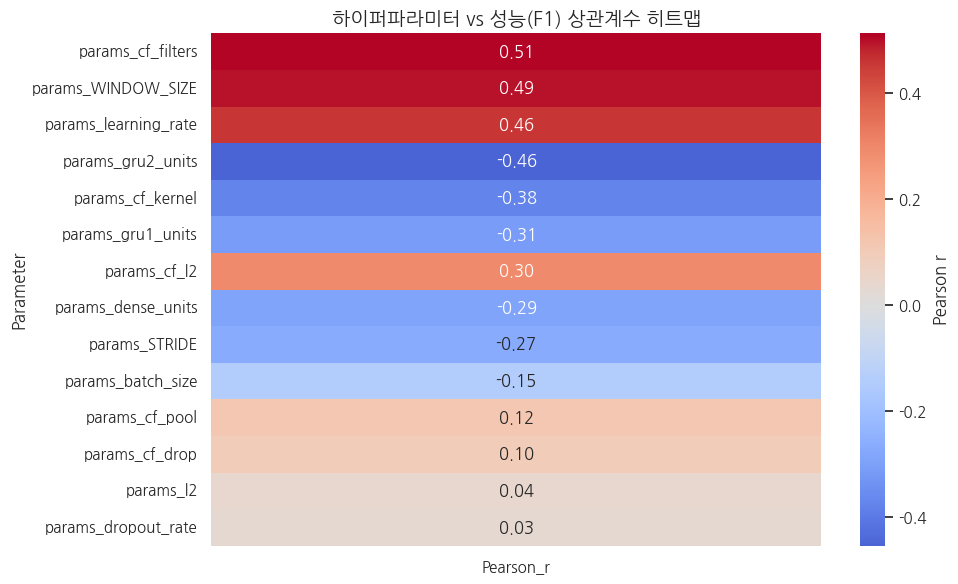

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# corr_df는 이미 만들어진 상태 (Parameter, Pearson_r, p_value, abs_r)
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_df.set_index("Parameter")[["Pearson_r"]],
    annot=True, fmt=".2f", cmap="coolwarm", center=0, cbar_kws={"label": "Pearson r"}
)
plt.title("하이퍼파라미터 vs 성능(F1) 상관계수 히트맵", fontsize=14)
plt.ylabel("Parameter")
plt.tight_layout()
plt.show()

# # 최종 검증 및 분석 (학습 곡선 포함)

🚀 최종 모델 성능 평가 및 베이스라인 비교
1️⃣ 최적화된 설정 반영

Optuna 탐색 결과에서 선택된 Trial 파라미터를 반영해 최종 config 구성

안전 조치:

paths.FEATURES_PATH 자동 보정

출력 디렉토리 outputs/step4_final_loso 생성 및 저장

pipeline.run_pipeline() 실행으로 전체 Fold LOSO 교차 검증 수행

2️⃣ 성능 비교 (Baseline vs Optimized)

평가 지표: Macro F1

Fold별 점수를 추출 후 페어링하여 통계 검정 수행:

대응표본 t-test

Wilcoxon signed-rank test

효과 크기: Cohen’s dz

부트스트랩 95% 신뢰구간 계산 (평균 차이)

3️⃣ 주요 출력

평균 F1 점수: Baseline vs Optimized

통계 검정 결과

t, p-value

Wilcoxon W, p-value (가능할 경우)

효과 크기(Cohen’s dz)

평균 차이 및 CI

4️⃣ 시각화

📦 Boxplot + Stripplot: 두 모델 분포 비교

🔗 폴드별 연결 플롯: Baseline → Optimized 변화 추세 확인

🔲 혼동 행렬 비교: 전체 Fold raw_predictions 합산 후, Heatmap으로 시각화

📈 학습 곡선: aggregated_training_history.png 표시 (모든 Fold 평균)

5️⃣ 결론

p-value < 0.05라면 → 최적화 모델이 베이스라인 대비 유의미하게 향상됨 ✅

p-value ≥ 0.05라면 → 성능 차이는 있으나 통계적으로 유의하지 않음 ➖

📌 참고

결과 파일 경로

Baseline: outputs/step1_loso_test/models/final_loso_cv_report.csv

Optimized: outputs/step4_final_loso/models/final_loso_cv_report.csv

혼동 행렬: 각 Fold별 raw_predictions.npz를 찾아 합산

✅ 선택된 트라이얼 파라미터로 진행합니다.
   SELECT_BY = rank | trial number = 35 | rank = 6
   F1(value) = 0.6980669169985
최종 최적화된 설정으로 전체 LOSO 교차 검증을 시작합니다. 시간이 많이 소요됩니다...


Epoch 1/100

Epoch 1: val_loss improved from None to 0.89943, saving model to outputs/step4_final_loso\models\fold_1\best_model.keras
571/571 - 11s - 20ms/step - accuracy: 0.4709 - loss: 1.6065 - val_accuracy: 0.7577 - val_loss: 0.8994 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.89943 to 0.58816, saving model to outputs/step4_final_loso\models\fold_1\best_model.keras
571/571 - 10s - 17ms/step - accuracy: 0.7366 - loss: 0.8137 - val_accuracy: 0.8436 - val_loss: 0.5882 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.58816 to 0.46924, saving model to outputs/step4_final_loso\models\fold_1\best_model.keras
571/571 - 10s - 17ms/step - accuracy: 0.8193 - loss: 0.5690 - val_accuracy: 0.8934 - val_loss: 0.4692 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.46924 to 0.41333, saving model to outputs/step4_final_loso\models\fold_1\best_model.keras
571/571 - 10s - 17ms/step - accuracy: 0.8606 - loss: 0.4403 - val

Epoch 1/100

Epoch 1: val_loss improved from None to 0.84215, saving model to outputs/step4_final_loso\models\fold_2\best_model.keras
571/571 - 11s - 20ms/step - accuracy: 0.4746 - loss: 1.5905 - val_accuracy: 0.7581 - val_loss: 0.8421 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.84215 to 0.57063, saving model to outputs/step4_final_loso\models\fold_2\best_model.keras
571/571 - 10s - 17ms/step - accuracy: 0.7400 - loss: 0.8024 - val_accuracy: 0.8582 - val_loss: 0.5706 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.57063 to 0.45458, saving model to outputs/step4_final_loso\models\fold_2\best_model.keras
571/571 - 10s - 17ms/step - accuracy: 0.8233 - loss: 0.5559 - val_accuracy: 0.8976 - val_loss: 0.4546 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.45458 to 0.44547, saving model to outputs/step4_final_loso\models\fold_2\best_model.keras
571/571 - 10s - 17ms/step - accuracy: 0.8667 - loss: 0.4272 - val

Epoch 1/100

Epoch 1: val_loss improved from None to 0.72026, saving model to outputs/step4_final_loso\models\fold_3\best_model.keras
584/584 - 12s - 21ms/step - accuracy: 0.4827 - loss: 1.5916 - val_accuracy: 0.7744 - val_loss: 0.7203 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.72026 to 0.48188, saving model to outputs/step4_final_loso\models\fold_3\best_model.keras
584/584 - 11s - 18ms/step - accuracy: 0.7411 - loss: 0.8168 - val_accuracy: 0.8323 - val_loss: 0.4819 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.48188 to 0.43518, saving model to outputs/step4_final_loso\models\fold_3\best_model.keras
584/584 - 11s - 19ms/step - accuracy: 0.8262 - loss: 0.5524 - val_accuracy: 0.8727 - val_loss: 0.4352 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.43518 to 0.35972, saving model to outputs/step4_final_loso\models\fold_3\best_model.keras
584/584 - 11s - 18ms/step - accuracy: 0.8666 - loss: 0.4348 - val

Epoch 1/100

Epoch 1: val_loss improved from None to 0.79095, saving model to outputs/step4_final_loso\models\fold_4\best_model.keras
591/591 - 13s - 21ms/step - accuracy: 0.4947 - loss: 1.5475 - val_accuracy: 0.7809 - val_loss: 0.7910 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.79095 to 0.51211, saving model to outputs/step4_final_loso\models\fold_4\best_model.keras
591/591 - 11s - 19ms/step - accuracy: 0.7654 - loss: 0.7480 - val_accuracy: 0.8302 - val_loss: 0.5121 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.51211 to 0.48414, saving model to outputs/step4_final_loso\models\fold_4\best_model.keras
591/591 - 11s - 18ms/step - accuracy: 0.8457 - loss: 0.5042 - val_accuracy: 0.8515 - val_loss: 0.4841 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.48414 to 0.36929, saving model to outputs/step4_final_loso\models\fold_4\best_model.keras
591/591 - 11s - 19ms/step - accuracy: 0.8832 - loss: 0.3898 - val

Epoch 1/100

Epoch 1: val_loss improved from None to 0.83198, saving model to outputs/step4_final_loso\models\fold_5\best_model.keras
591/591 - 14s - 23ms/step - accuracy: 0.4945 - loss: 1.5477 - val_accuracy: 0.7401 - val_loss: 0.8320 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.83198 to 0.57316, saving model to outputs/step4_final_loso\models\fold_5\best_model.keras
591/591 - 11s - 18ms/step - accuracy: 0.7612 - loss: 0.7551 - val_accuracy: 0.8109 - val_loss: 0.5732 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.57316 to 0.54627, saving model to outputs/step4_final_loso\models\fold_5\best_model.keras
591/591 - 11s - 18ms/step - accuracy: 0.8459 - loss: 0.5029 - val_accuracy: 0.8338 - val_loss: 0.5463 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.54627 to 0.41240, saving model to outputs/step4_final_loso\models\fold_5\best_model.keras
591/591 - 12s - 20ms/step - accuracy: 0.8839 - loss: 0.3906 - val

Epoch 1/100

Epoch 1: val_loss improved from None to 0.76701, saving model to outputs/step4_final_loso\models\fold_6\best_model.keras
591/591 - 11s - 19ms/step - accuracy: 0.4932 - loss: 1.5519 - val_accuracy: 0.7567 - val_loss: 0.7670 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.76701 to 0.53760, saving model to outputs/step4_final_loso\models\fold_6\best_model.keras
591/591 - 11s - 18ms/step - accuracy: 0.7650 - loss: 0.7478 - val_accuracy: 0.8169 - val_loss: 0.5376 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.53760 to 0.49523, saving model to outputs/step4_final_loso\models\fold_6\best_model.keras
591/591 - 11s - 19ms/step - accuracy: 0.8457 - loss: 0.5069 - val_accuracy: 0.8390 - val_loss: 0.4952 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.49523 to 0.35385, saving model to outputs/step4_final_loso\models\fold_6\best_model.keras
591/591 - 10s - 17ms/step - accuracy: 0.8798 - loss: 0.3979 - val

Epoch 1/100

Epoch 1: val_loss improved from None to 0.79609, saving model to outputs/step4_final_loso\models\fold_7\best_model.keras
591/591 - 11s - 19ms/step - accuracy: 0.5009 - loss: 1.5319 - val_accuracy: 0.7539 - val_loss: 0.7961 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.79609 to 0.47971, saving model to outputs/step4_final_loso\models\fold_7\best_model.keras
591/591 - 10s - 17ms/step - accuracy: 0.7707 - loss: 0.7280 - val_accuracy: 0.8470 - val_loss: 0.4797 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.47971 to 0.46751, saving model to outputs/step4_final_loso\models\fold_7\best_model.keras
591/591 - 10s - 17ms/step - accuracy: 0.8496 - loss: 0.4909 - val_accuracy: 0.8547 - val_loss: 0.4675 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.46751 to 0.33638, saving model to outputs/step4_final_loso\models\fold_7\best_model.keras
591/591 - 10s - 16ms/step - accuracy: 0.8846 - loss: 0.3850 - val

Epoch 1/100

Epoch 1: val_loss improved from None to 0.79651, saving model to outputs/step4_final_loso\models\fold_8\best_model.keras
591/591 - 13s - 22ms/step - accuracy: 0.4959 - loss: 1.5449 - val_accuracy: 0.7468 - val_loss: 0.7965 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.79651 to 0.49467, saving model to outputs/step4_final_loso\models\fold_8\best_model.keras
591/591 - 11s - 18ms/step - accuracy: 0.7691 - loss: 0.7370 - val_accuracy: 0.8298 - val_loss: 0.4947 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.49467 to 0.39945, saving model to outputs/step4_final_loso\models\fold_8\best_model.keras
591/591 - 10s - 17ms/step - accuracy: 0.8491 - loss: 0.4915 - val_accuracy: 0.8672 - val_loss: 0.3994 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.39945 to 0.33727, saving model to outputs/step4_final_loso\models\fold_8\best_model.keras
591/591 - 10s - 17ms/step - accuracy: 0.8837 - loss: 0.3893 - val

Epoch 1/100

Epoch 1: val_loss improved from None to 0.77863, saving model to outputs/step4_final_loso\models\fold_9\best_model.keras
591/591 - 12s - 20ms/step - accuracy: 0.4944 - loss: 1.5483 - val_accuracy: 0.7582 - val_loss: 0.7786 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.77863 to 0.49674, saving model to outputs/step4_final_loso\models\fold_9\best_model.keras
591/591 - 10s - 17ms/step - accuracy: 0.7650 - loss: 0.7395 - val_accuracy: 0.8340 - val_loss: 0.4967 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.49674 to 0.45682, saving model to outputs/step4_final_loso\models\fold_9\best_model.keras
591/591 - 10s - 17ms/step - accuracy: 0.8435 - loss: 0.5042 - val_accuracy: 0.8533 - val_loss: 0.4568 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.45682 to 0.35304, saving model to outputs/step4_final_loso\models\fold_9\best_model.keras
591/591 - 10s - 17ms/step - accuracy: 0.8834 - loss: 0.3883 - val

Epoch 1/100

Epoch 1: val_loss improved from None to 0.78632, saving model to outputs/step4_final_loso\models\fold_10\best_model.keras
591/591 - 12s - 20ms/step - accuracy: 0.4979 - loss: 1.5446 - val_accuracy: 0.7478 - val_loss: 0.7863 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.78632 to 0.49410, saving model to outputs/step4_final_loso\models\fold_10\best_model.keras
591/591 - 10s - 17ms/step - accuracy: 0.7654 - loss: 0.7461 - val_accuracy: 0.8291 - val_loss: 0.4941 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.49410 to 0.44648, saving model to outputs/step4_final_loso\models\fold_10\best_model.keras
591/591 - 10s - 17ms/step - accuracy: 0.8413 - loss: 0.5153 - val_accuracy: 0.8589 - val_loss: 0.4465 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.44648 to 0.39038, saving model to outputs/step4_final_loso\models\fold_10\best_model.keras
591/591 - 10s - 17ms/step - accuracy: 0.8788 - loss: 0.4040 -

Epoch 1/100

Epoch 1: val_loss improved from None to 0.78140, saving model to outputs/step4_final_loso\models\fold_11\best_model.keras
591/591 - 12s - 20ms/step - accuracy: 0.4960 - loss: 1.5371 - val_accuracy: 0.7555 - val_loss: 0.7814 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.78140 to 0.51502, saving model to outputs/step4_final_loso\models\fold_11\best_model.keras
591/591 - 11s - 18ms/step - accuracy: 0.7649 - loss: 0.7389 - val_accuracy: 0.8234 - val_loss: 0.5150 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.51502 to 0.45166, saving model to outputs/step4_final_loso\models\fold_11\best_model.keras
591/591 - 10s - 17ms/step - accuracy: 0.8446 - loss: 0.4994 - val_accuracy: 0.8570 - val_loss: 0.4517 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.45166 to 0.38110, saving model to outputs/step4_final_loso\models\fold_11\best_model.keras
591/591 - 11s - 18ms/step - accuracy: 0.8816 - loss: 0.3921 -

Epoch 1/100

Epoch 1: val_loss improved from None to 0.86580, saving model to outputs/step4_final_loso\models\fold_12\best_model.keras
592/592 - 11s - 19ms/step - accuracy: 0.4820 - loss: 1.5827 - val_accuracy: 0.7275 - val_loss: 0.8658 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.86580 to 0.57010, saving model to outputs/step4_final_loso\models\fold_12\best_model.keras
592/592 - 10s - 17ms/step - accuracy: 0.7534 - loss: 0.7734 - val_accuracy: 0.8342 - val_loss: 0.5701 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.57010 to 0.51580, saving model to outputs/step4_final_loso\models\fold_12\best_model.keras
592/592 - 10s - 17ms/step - accuracy: 0.8443 - loss: 0.5118 - val_accuracy: 0.8500 - val_loss: 0.5158 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.51580 to 0.39778, saving model to outputs/step4_final_loso\models\fold_12\best_model.keras
592/592 - 10s - 16ms/step - accuracy: 0.8833 - loss: 0.4009 -

Epoch 1/100

Epoch 1: val_loss improved from None to 0.75775, saving model to outputs/step4_final_loso\models\fold_13\best_model.keras
593/593 - 13s - 21ms/step - accuracy: 0.4957 - loss: 1.5369 - val_accuracy: 0.7678 - val_loss: 0.7578 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.75775 to 0.51131, saving model to outputs/step4_final_loso\models\fold_13\best_model.keras
593/593 - 11s - 19ms/step - accuracy: 0.7607 - loss: 0.7535 - val_accuracy: 0.8285 - val_loss: 0.5113 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.51131 to 0.41515, saving model to outputs/step4_final_loso\models\fold_13\best_model.keras
593/593 - 11s - 18ms/step - accuracy: 0.8436 - loss: 0.5120 - val_accuracy: 0.8791 - val_loss: 0.4152 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.41515 to 0.39606, saving model to outputs/step4_final_loso\models\fold_13\best_model.keras
593/593 - 11s - 18ms/step - accuracy: 0.8793 - loss: 0.4046 -

Epoch 1/100

Epoch 1: val_loss improved from None to 0.80456, saving model to outputs/step4_final_loso\models\fold_14\best_model.keras
592/592 - 11s - 18ms/step - accuracy: 0.4946 - loss: 1.5535 - val_accuracy: 0.7588 - val_loss: 0.8046 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.80456 to 0.50421, saving model to outputs/step4_final_loso\models\fold_14\best_model.keras
592/592 - 9s - 16ms/step - accuracy: 0.7540 - loss: 0.7604 - val_accuracy: 0.8329 - val_loss: 0.5042 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.50421 to 0.41332, saving model to outputs/step4_final_loso\models\fold_14\best_model.keras
592/592 - 9s - 16ms/step - accuracy: 0.8370 - loss: 0.5229 - val_accuracy: 0.8652 - val_loss: 0.4133 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.41332 to 0.38027, saving model to outputs/step4_final_loso\models\fold_14\best_model.keras
592/592 - 9s - 16ms/step - accuracy: 0.8732 - loss: 0.4195 - va

Epoch 1/100

Epoch 1: val_loss improved from None to 0.77946, saving model to outputs/step4_final_loso\models\fold_15\best_model.keras
591/591 - 12s - 20ms/step - accuracy: 0.5012 - loss: 1.5251 - val_accuracy: 0.7656 - val_loss: 0.7795 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.77946 to 0.52315, saving model to outputs/step4_final_loso\models\fold_15\best_model.keras
591/591 - 10s - 17ms/step - accuracy: 0.7688 - loss: 0.7364 - val_accuracy: 0.8378 - val_loss: 0.5231 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.52315 to 0.43064, saving model to outputs/step4_final_loso\models\fold_15\best_model.keras
591/591 - 11s - 18ms/step - accuracy: 0.8452 - loss: 0.5029 - val_accuracy: 0.8660 - val_loss: 0.4306 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.43064 to 0.35062, saving model to outputs/step4_final_loso\models\fold_15\best_model.keras
591/591 - 10s - 17ms/step - accuracy: 0.8836 - loss: 0.3865 -

Epoch 1/100

Epoch 1: val_loss improved from None to 0.75143, saving model to outputs/step4_final_loso\models\fold_16\best_model.keras
591/591 - 12s - 20ms/step - accuracy: 0.5007 - loss: 1.5283 - val_accuracy: 0.7739 - val_loss: 0.7514 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.75143 to 0.48449, saving model to outputs/step4_final_loso\models\fold_16\best_model.keras
591/591 - 11s - 18ms/step - accuracy: 0.7665 - loss: 0.7379 - val_accuracy: 0.8528 - val_loss: 0.4845 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.48449 to 0.43304, saving model to outputs/step4_final_loso\models\fold_16\best_model.keras
591/591 - 10s - 16ms/step - accuracy: 0.8520 - loss: 0.4868 - val_accuracy: 0.8742 - val_loss: 0.4330 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.43304 to 0.35054, saving model to outputs/step4_final_loso\models\fold_16\best_model.keras
591/591 - 11s - 19ms/step - accuracy: 0.8889 - loss: 0.3772 -

Epoch 1/100

Epoch 1: val_loss improved from None to 0.74393, saving model to outputs/step4_final_loso\models\fold_17\best_model.keras
591/591 - 12s - 20ms/step - accuracy: 0.5006 - loss: 1.5276 - val_accuracy: 0.7613 - val_loss: 0.7439 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.74393 to 0.48081, saving model to outputs/step4_final_loso\models\fold_17\best_model.keras
591/591 - 9s - 16ms/step - accuracy: 0.7739 - loss: 0.7123 - val_accuracy: 0.8432 - val_loss: 0.4808 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.48081 to 0.41668, saving model to outputs/step4_final_loso\models\fold_17\best_model.keras
591/591 - 9s - 16ms/step - accuracy: 0.8555 - loss: 0.4738 - val_accuracy: 0.8760 - val_loss: 0.4167 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.41668 to 0.35735, saving model to outputs/step4_final_loso\models\fold_17\best_model.keras
591/591 - 9s - 16ms/step - accuracy: 0.8913 - loss: 0.3629 - va

Epoch 1/100

Epoch 1: val_loss improved from None to 0.76481, saving model to outputs/step4_final_loso\models\fold_18\best_model.keras
591/591 - 11s - 18ms/step - accuracy: 0.4927 - loss: 1.5529 - val_accuracy: 0.7616 - val_loss: 0.7648 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.76481 to 0.47006, saving model to outputs/step4_final_loso\models\fold_18\best_model.keras
591/591 - 9s - 16ms/step - accuracy: 0.7600 - loss: 0.7575 - val_accuracy: 0.8442 - val_loss: 0.4701 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.47006 to 0.40295, saving model to outputs/step4_final_loso\models\fold_18\best_model.keras
591/591 - 9s - 16ms/step - accuracy: 0.8461 - loss: 0.5047 - val_accuracy: 0.8699 - val_loss: 0.4029 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.40295 to 0.33569, saving model to outputs/step4_final_loso\models\fold_18\best_model.keras
591/591 - 9s - 16ms/step - accuracy: 0.8846 - loss: 0.3881 - va

Epoch 1/100

Epoch 1: val_loss improved from None to 0.74955, saving model to outputs/step4_final_loso\models\fold_19\best_model.keras
591/591 - 17s - 30ms/step - accuracy: 0.4976 - loss: 1.5428 - val_accuracy: 0.7597 - val_loss: 0.7495 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.74955 to 0.50686, saving model to outputs/step4_final_loso\models\fold_19\best_model.keras
591/591 - 20s - 34ms/step - accuracy: 0.7688 - loss: 0.7378 - val_accuracy: 0.8302 - val_loss: 0.5069 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.50686 to 0.44036, saving model to outputs/step4_final_loso\models\fold_19\best_model.keras
591/591 - 15s - 25ms/step - accuracy: 0.8509 - loss: 0.4856 - val_accuracy: 0.8608 - val_loss: 0.4404 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.44036 to 0.33821, saving model to outputs/step4_final_loso\models\fold_19\best_model.keras
591/591 - 15s - 25ms/step - accuracy: 0.8858 - loss: 0.3836 -

Epoch 1/100

Epoch 1: val_loss improved from None to 0.75576, saving model to outputs/step4_final_loso\models\fold_20\best_model.keras
591/591 - 19s - 32ms/step - accuracy: 0.4937 - loss: 1.5514 - val_accuracy: 0.7500 - val_loss: 0.7558 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.75576 to 0.49678, saving model to outputs/step4_final_loso\models\fold_20\best_model.keras
591/591 - 19s - 33ms/step - accuracy: 0.7614 - loss: 0.7489 - val_accuracy: 0.8310 - val_loss: 0.4968 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.49678 to 0.44008, saving model to outputs/step4_final_loso\models\fold_20\best_model.keras
591/591 - 21s - 35ms/step - accuracy: 0.8485 - loss: 0.4976 - val_accuracy: 0.8503 - val_loss: 0.4401 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.44008 to 0.34712, saving model to outputs/step4_final_loso\models\fold_20\best_model.keras
591/591 - 20s - 34ms/step - accuracy: 0.8854 - loss: 0.3836 -

Epoch 1/100

Epoch 1: val_loss improved from None to 0.75923, saving model to outputs/step4_final_loso\models\fold_21\best_model.keras
591/591 - 18s - 31ms/step - accuracy: 0.5001 - loss: 1.5359 - val_accuracy: 0.7558 - val_loss: 0.7592 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.75923 to 0.48978, saving model to outputs/step4_final_loso\models\fold_21\best_model.keras
591/591 - 20s - 33ms/step - accuracy: 0.7612 - loss: 0.7625 - val_accuracy: 0.8455 - val_loss: 0.4898 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.48978 to 0.45986, saving model to outputs/step4_final_loso\models\fold_21\best_model.keras
591/591 - 21s - 35ms/step - accuracy: 0.8434 - loss: 0.5100 - val_accuracy: 0.8500 - val_loss: 0.4599 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.45986 to 0.35479, saving model to outputs/step4_final_loso\models\fold_21\best_model.keras
591/591 - 17s - 28ms/step - accuracy: 0.8814 - loss: 0.3974 -

Epoch 1/100

Epoch 1: val_loss improved from None to 0.92062, saving model to outputs/step4_final_loso\models\fold_22\best_model.keras
592/592 - 12s - 21ms/step - accuracy: 0.4797 - loss: 1.5890 - val_accuracy: 0.7040 - val_loss: 0.9206 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.92062 to 0.48657, saving model to outputs/step4_final_loso\models\fold_22\best_model.keras
592/592 - 11s - 18ms/step - accuracy: 0.7549 - loss: 0.7763 - val_accuracy: 0.8426 - val_loss: 0.4866 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.48657 to 0.40843, saving model to outputs/step4_final_loso\models\fold_22\best_model.keras
592/592 - 11s - 18ms/step - accuracy: 0.8434 - loss: 0.5154 - val_accuracy: 0.8727 - val_loss: 0.4084 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss did not improve from 0.40843
592/592 - 11s - 18ms/step - accuracy: 0.8852 - loss: 0.3962 - val_accuracy: 0.8606 - val_loss: 0.4620 - learning_rate: 3.5709e-04
Epoch 5/1

Epoch 1/100

Epoch 1: val_loss improved from None to 0.99920, saving model to outputs/step4_final_loso\models\fold_23\best_model.keras
534/534 - 9s - 18ms/step - accuracy: 0.4564 - loss: 1.6609 - val_accuracy: 0.7120 - val_loss: 0.9992 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.99920 to 0.67149, saving model to outputs/step4_final_loso\models\fold_23\best_model.keras
534/534 - 10s - 19ms/step - accuracy: 0.7122 - loss: 0.8680 - val_accuracy: 0.8470 - val_loss: 0.6715 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.67149 to 0.60817, saving model to outputs/step4_final_loso\models\fold_23\best_model.keras
534/534 - 8s - 15ms/step - accuracy: 0.8081 - loss: 0.5888 - val_accuracy: 0.8605 - val_loss: 0.6082 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.60817 to 0.56892, saving model to outputs/step4_final_loso\models\fold_23\best_model.keras
534/534 - 8s - 14ms/step - accuracy: 0.8544 - loss: 0.4631 - va

Epoch 1/100

Epoch 1: val_loss improved from None to 0.74717, saving model to outputs/step4_final_loso\models\fold_24\best_model.keras
532/532 - 9s - 17ms/step - accuracy: 0.4624 - loss: 1.6383 - val_accuracy: 0.7737 - val_loss: 0.7472 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.74717 to 0.40365, saving model to outputs/step4_final_loso\models\fold_24\best_model.keras
532/532 - 7s - 14ms/step - accuracy: 0.7203 - loss: 0.8429 - val_accuracy: 0.8648 - val_loss: 0.4037 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.40365 to 0.29031, saving model to outputs/step4_final_loso\models\fold_24\best_model.keras
532/532 - 7s - 14ms/step - accuracy: 0.8097 - loss: 0.5887 - val_accuracy: 0.9044 - val_loss: 0.2903 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.29031 to 0.27331, saving model to outputs/step4_final_loso\models\fold_24\best_model.keras
532/532 - 7s - 14ms/step - accuracy: 0.8565 - loss: 0.4564 - val

Epoch 1/100

Epoch 1: val_loss improved from None to 0.81637, saving model to outputs/step4_final_loso\models\fold_25\best_model.keras
534/534 - 12s - 22ms/step - accuracy: 0.4507 - loss: 1.6760 - val_accuracy: 0.7657 - val_loss: 0.8164 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.81637 to 0.47956, saving model to outputs/step4_final_loso\models\fold_25\best_model.keras
534/534 - 10s - 18ms/step - accuracy: 0.7200 - loss: 0.8806 - val_accuracy: 0.8545 - val_loss: 0.4796 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.47956 to 0.38970, saving model to outputs/step4_final_loso\models\fold_25\best_model.keras
534/534 - 7s - 14ms/step - accuracy: 0.8172 - loss: 0.5925 - val_accuracy: 0.8649 - val_loss: 0.3897 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.38970 to 0.31643, saving model to outputs/step4_final_loso\models\fold_25\best_model.keras
534/534 - 7s - 13ms/step - accuracy: 0.8617 - loss: 0.4527 - v

Epoch 1/100

Epoch 1: val_loss improved from None to 0.84556, saving model to outputs/step4_final_loso\models\fold_26\best_model.keras
574/574 - 9s - 16ms/step - accuracy: 0.4680 - loss: 1.6048 - val_accuracy: 0.7202 - val_loss: 0.8456 - learning_rate: 3.5709e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.84556 to 0.46452, saving model to outputs/step4_final_loso\models\fold_26\best_model.keras
574/574 - 8s - 13ms/step - accuracy: 0.7397 - loss: 0.8022 - val_accuracy: 0.8508 - val_loss: 0.4645 - learning_rate: 3.5709e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.46452 to 0.32821, saving model to outputs/step4_final_loso\models\fold_26\best_model.keras
574/574 - 8s - 13ms/step - accuracy: 0.8367 - loss: 0.5151 - val_accuracy: 0.8936 - val_loss: 0.3282 - learning_rate: 3.5709e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.32821 to 0.26594, saving model to outputs/step4_final_loso\models\fold_26\best_model.keras
574/574 - 8s - 13ms/step - accuracy: 0.8757 - loss: 0.4042 - val

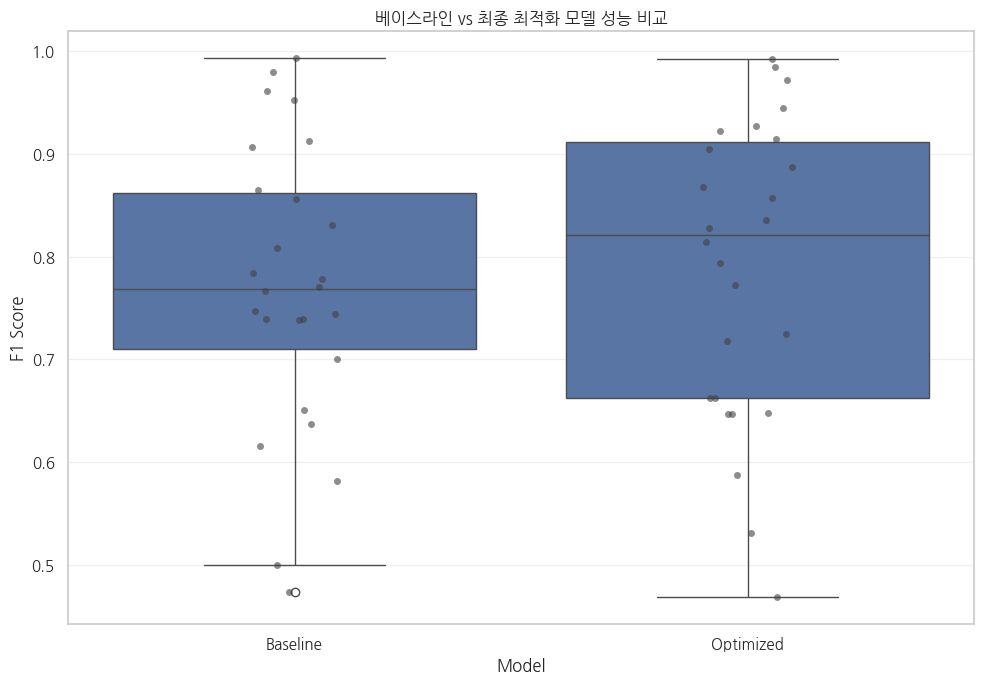

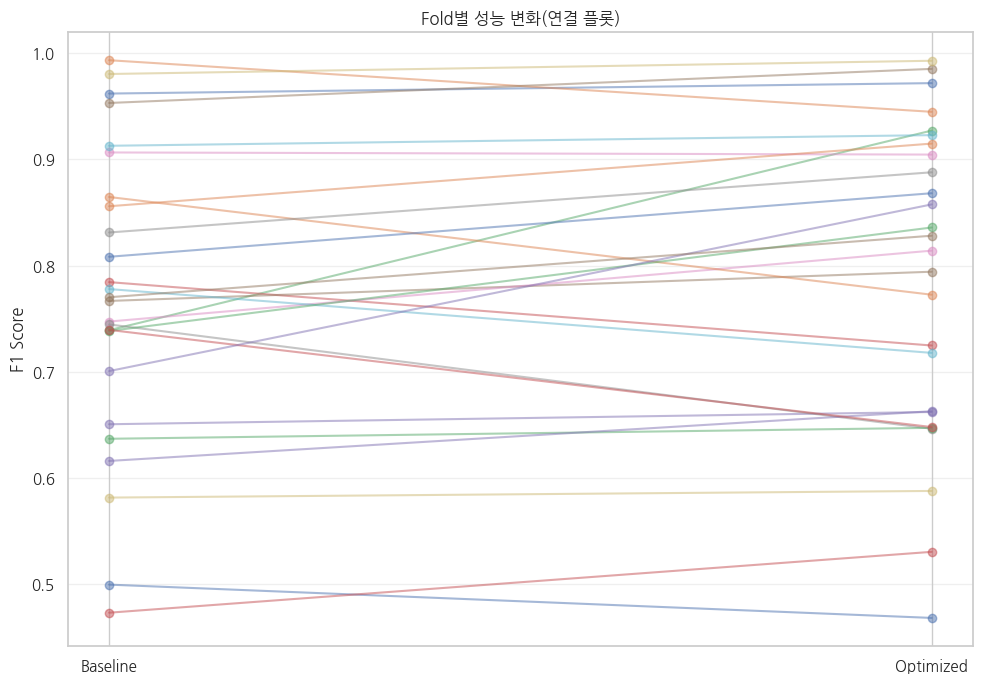

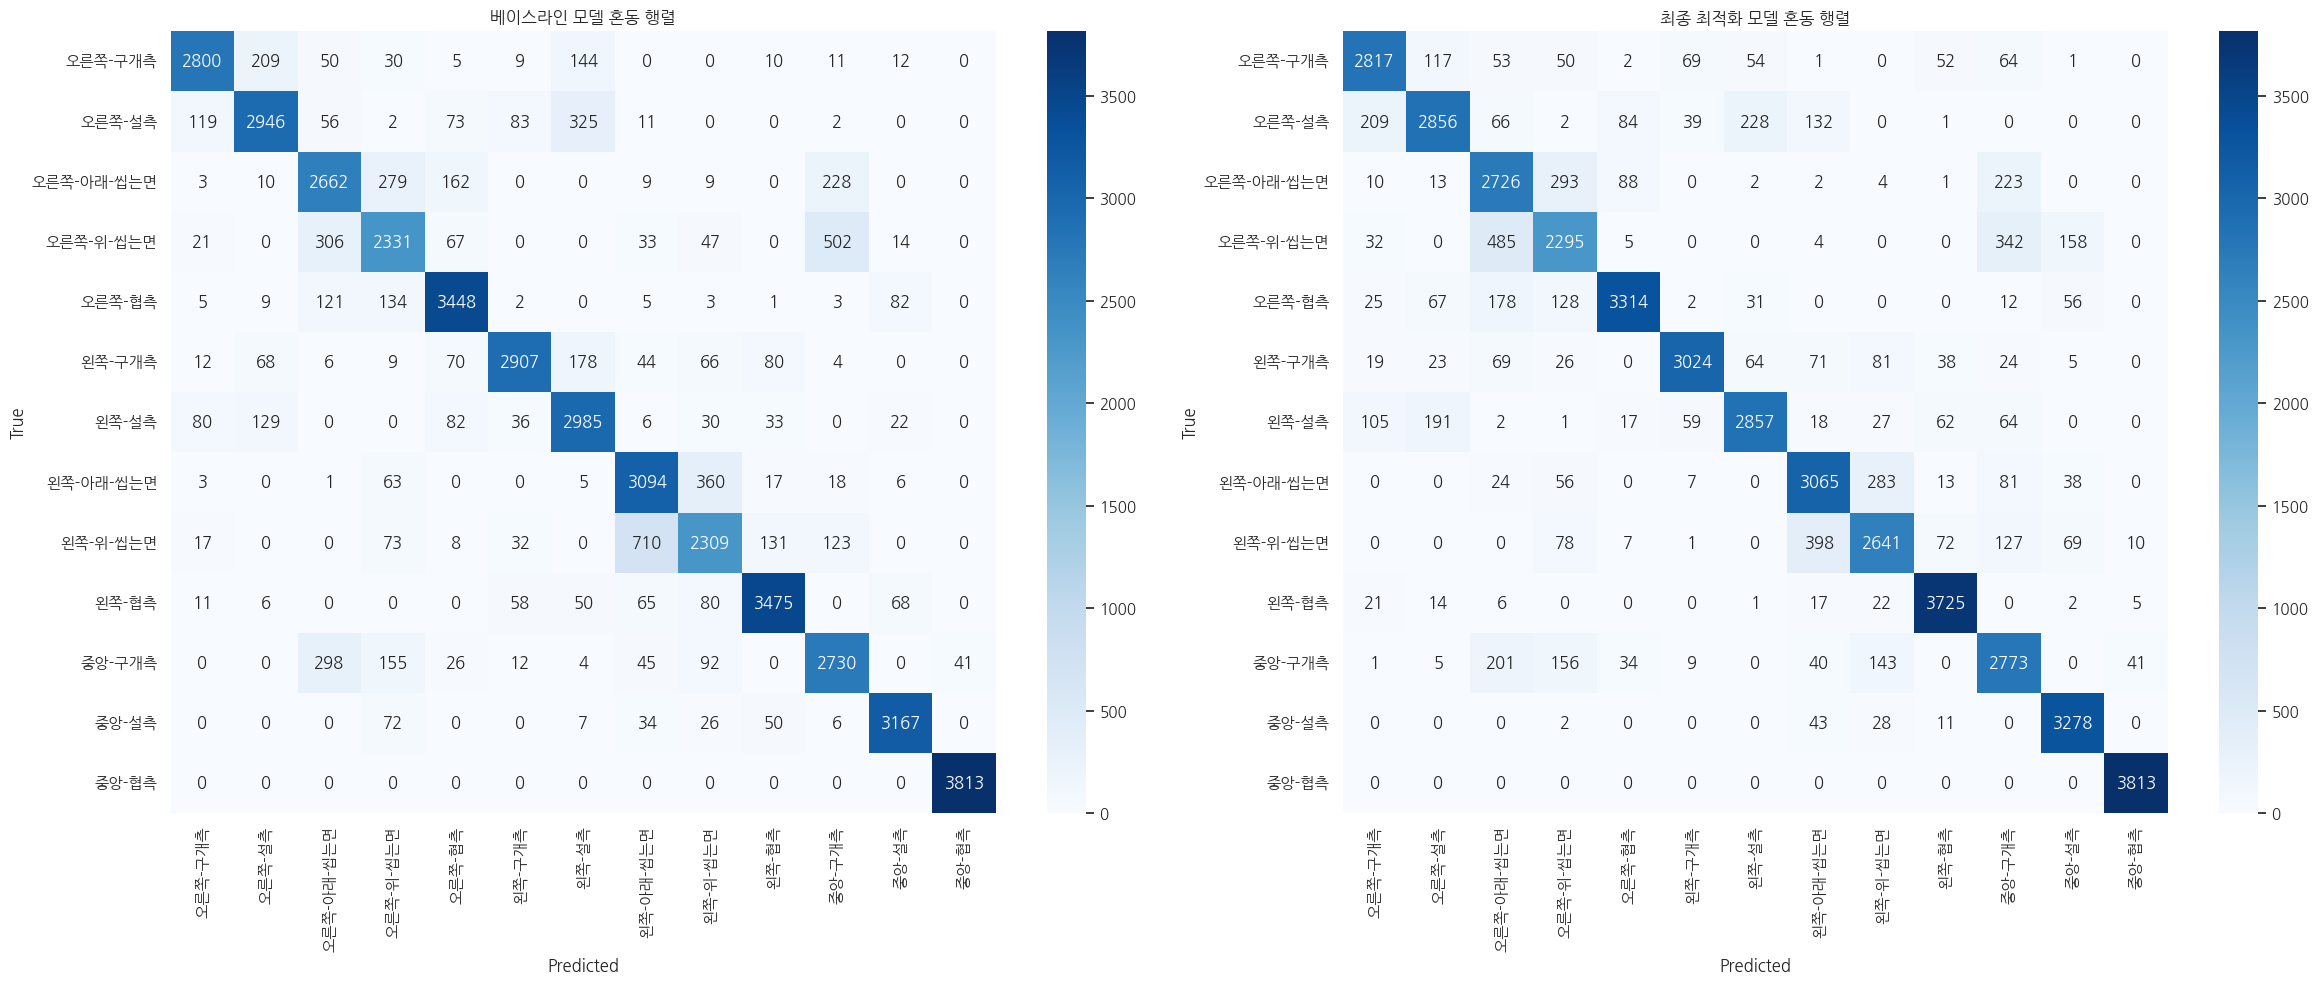


===== 최종 모델 종합 학습 곡선 (모든 Fold 평균) =====


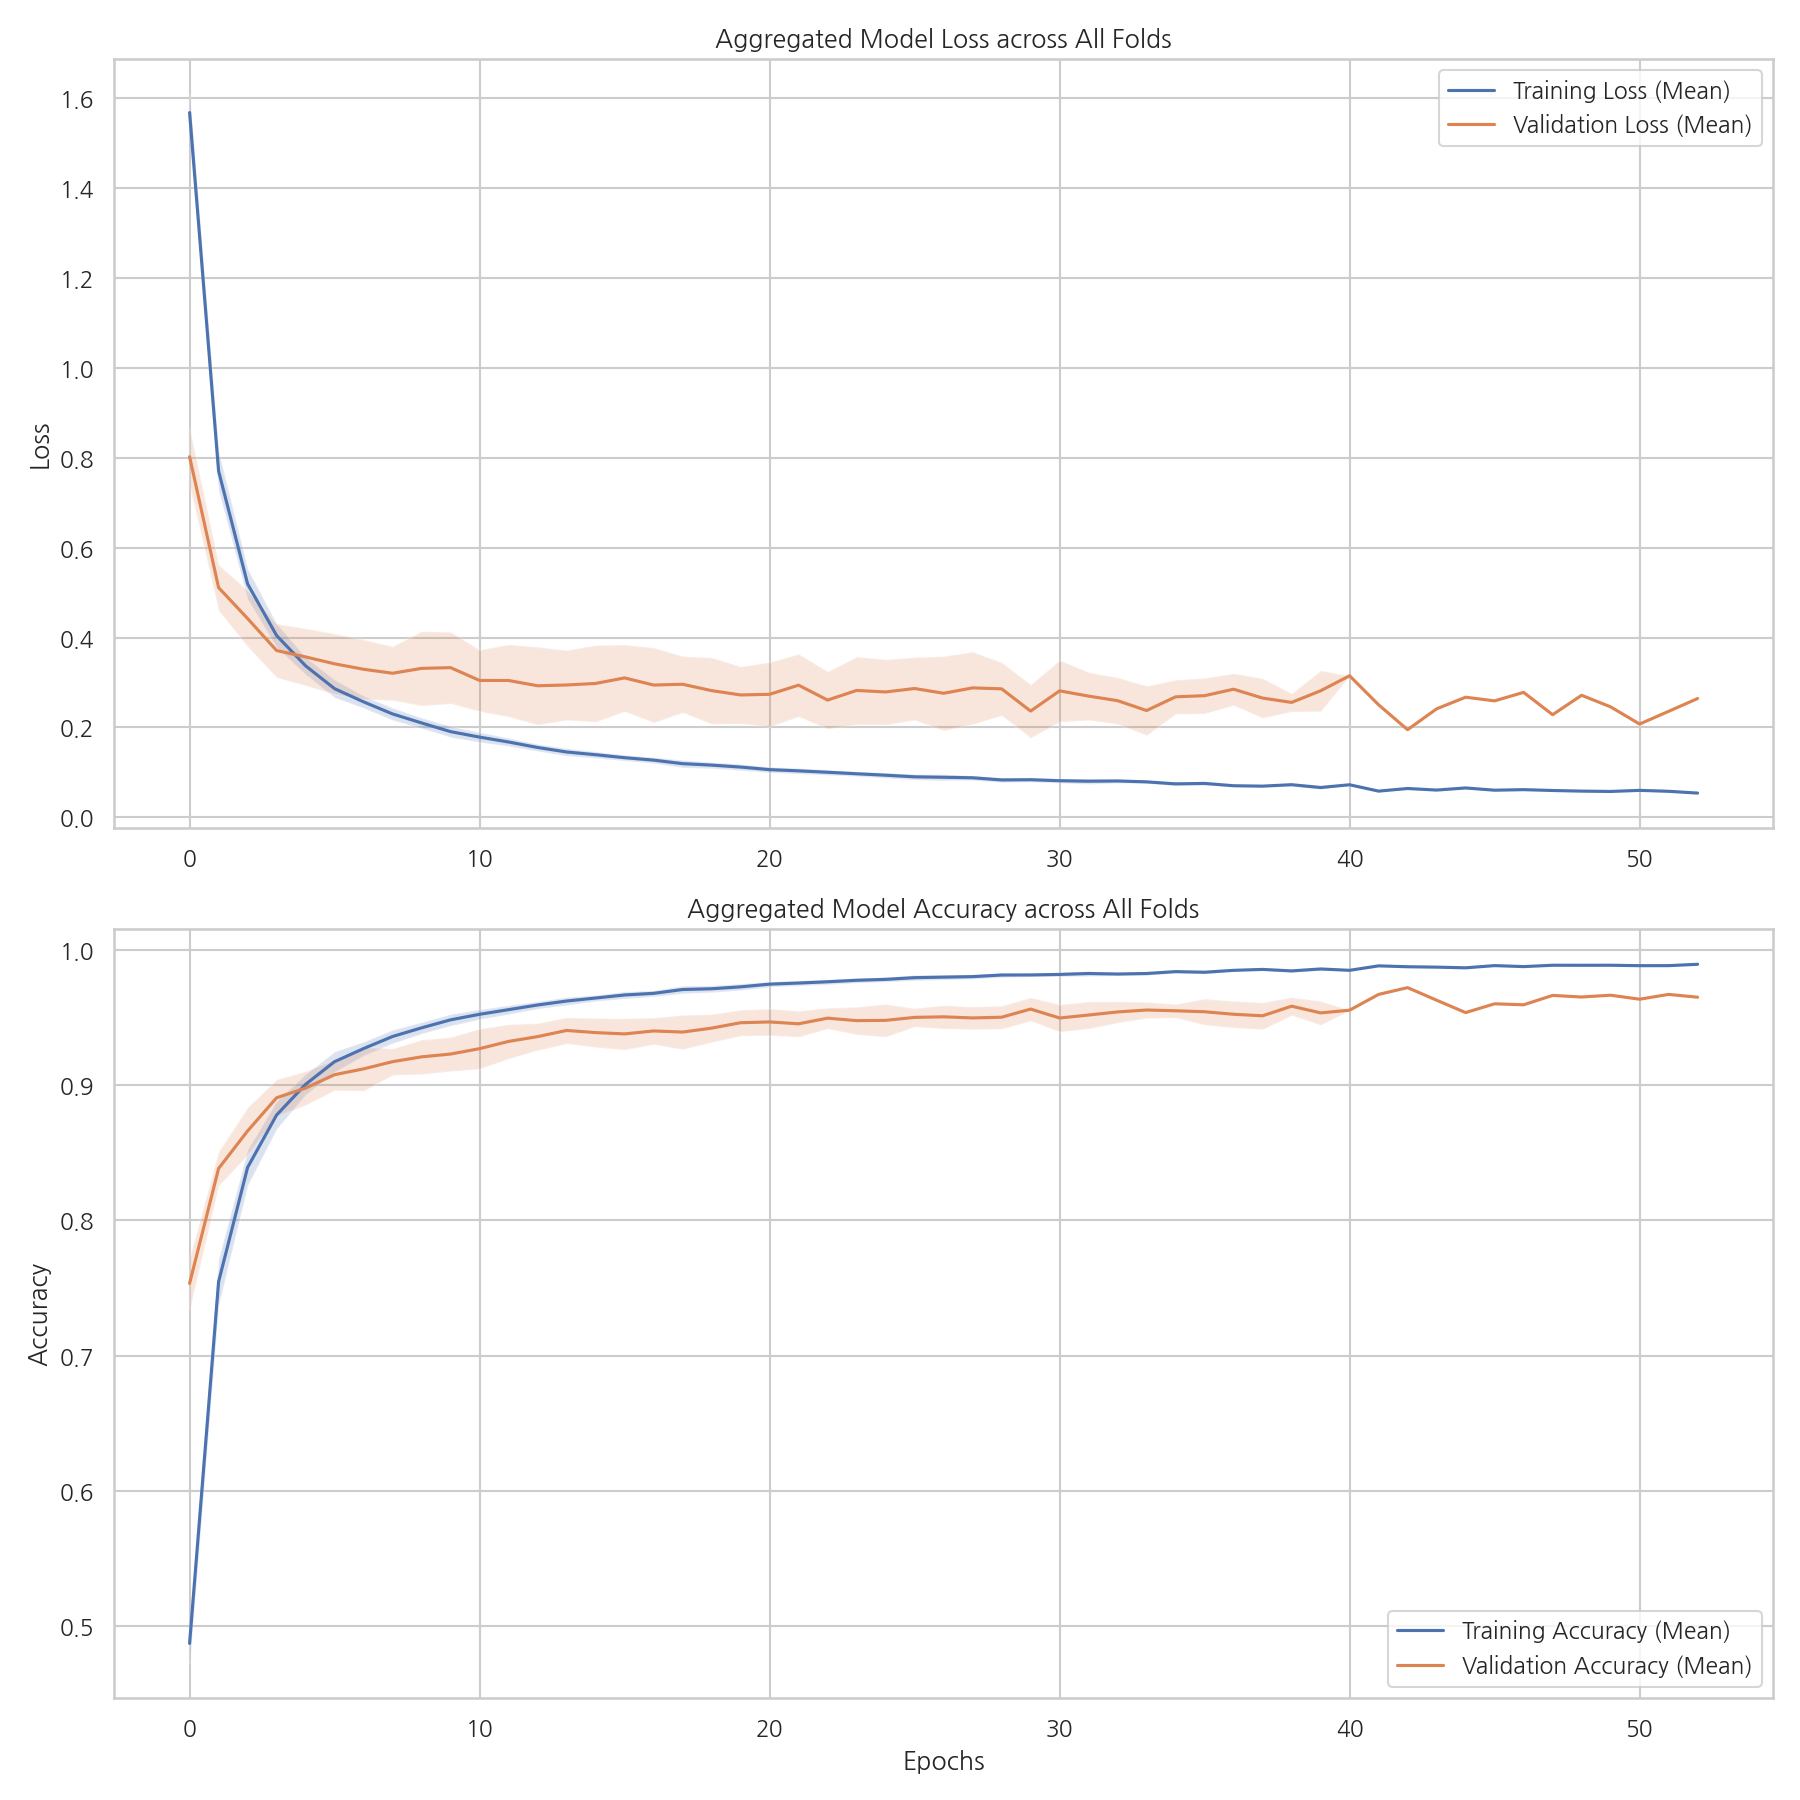

In [37]:
# ==== Imports (필요 모듈) =====================================================
import os, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix
from IPython.display import display, Image
import optuna

# 선택 방식: 'best' | 'rank' | 'number'
SELECT_BY = 'rank'          # <- 여기만 바꾸면 돼요
SELECTED_RANK = 6           # ex) 5위 트라이얼 사용
SELECTED_TRIAL_NUMBER = 5   # ex) trial number가 6인 트라이얼 사용

# 스터디에서 전체 trial 테이블 불러오고, 완료된 것만 정렬
df = study.trials_dataframe(attrs=(
    "number","value","state","params","datetime_start","datetime_complete"
))
df = df[df["state"] == "COMPLETE"].copy()
df = df.sort_values("value", ascending=False).reset_index(drop=True)

# 행 선택
if SELECT_BY == 'best':
    row = df.iloc[0]
elif SELECT_BY == 'rank':
    if not (1 <= SELECTED_RANK <= len(df)):
        raise ValueError(f"SELECTED_RANK가 범위를 벗어났습니다: 1..{len(df)}")
    row = df.iloc[SELECTED_RANK - 1]
elif SELECT_BY == 'number':
    if SELECTED_TRIAL_NUMBER not in df["number"].values:
        raise ValueError(f"trial number {SELECTED_TRIAL_NUMBER} 를 찾을 수 없습니다.")
    row = df[df["number"] == SELECTED_TRIAL_NUMBER].iloc[0]
else:
    raise ValueError("SELECT_BY must be one of: 'best' | 'rank' | 'number'")

# params_* 컬럼만 추출 → 딕셔너리로 변환
param_cols = [c for c in df.columns if c.startswith("params_")]

best_params_from_optuna = {}
for c in param_cols:
    key = c.replace("params_", "")   # 예: 'params_cf_filters' -> 'cf_filters'
    val = row[c]

    # 타입 캐스팅 (정수 하이퍼파라미터 목록)
    int_keys = {
        "WINDOW_SIZE", "STRIDE", "batch_size",
        "gru1_units", "gru2_units", "dense_units",
        "cf_filters", "cf_kernel", "cf_pool"
    }
    try:
        if key in int_keys:
            best_params_from_optuna[key] = int(val)
        else:
            best_params_from_optuna[key] = float(val)
    except Exception:
        # 숫자로 변환 불가(희귀케이스)는 원값 넣기
        best_params_from_optuna[key] = val

print("✅ 선택된 트라이얼 파라미터로 진행합니다.")
print("   SELECT_BY =", SELECT_BY, "| trial number =", int(row["number"]), "| rank =", (df.index[df["number"] == row["number"]][0] + 1))
print("   F1(value) =", float(row["value"]))

# ==== 2) 최종 설정 구성 (키 안전 + Optuna 결과 반영) ==========================
final_optimized_config = copy.deepcopy(best_config_base)  # base에는 best_architecture/feature/temporal 반영되어 있음
final_optimized_config.setdefault('paths', {})
final_optimized_config.setdefault('settings', {})
final_optimized_config.setdefault('feature_extraction', {})
final_optimized_config.setdefault('model_arch', {})
final_optimized_config['model_arch'].setdefault('conv_frontend', {})
final_optimized_config.setdefault('training', {})

# 출력 디렉토리 및 시각화 저장 설정
final_optimized_config['paths']['OUTPUT_DIR'] = 'outputs/step4_final_loso'
final_optimized_config['settings']['SAVE_VISUALIZATIONS'] = True
os.makedirs(final_optimized_config['paths']['OUTPUT_DIR'], exist_ok=True)

# Optuna 결과 적용
fe_updates = {k: v for k, v in best_params_from_optuna.items() if k in ['WINDOW_SIZE', 'STRIDE']}
ma_updates = {k: v for k, v in best_params_from_optuna.items() if k in ['gru1_units', 'gru2_units', 'dense_units', 'dropout_rate', 'l2']}
cf_updates = {k.replace('cf_', ''): v for k, v in best_params_from_optuna.items() if k.startswith('cf_')}
tr_updates = {k: v for k, v in best_params_from_optuna.items() if k in ['learning_rate', 'batch_size']}

final_optimized_config['feature_extraction'].update(fe_updates)
final_optimized_config['model_arch'].update(ma_updates)
final_optimized_config['model_arch']['conv_frontend'].update(cf_updates)
final_optimized_config['training'].update(tr_updates)

# ==== 2-1) FEATURES_PATH 자동 채우기 (KeyError 해결) =========================
# - pipeline.run_pipeline에서 cfg['paths']['FEATURES_PATH']를 요구
# - 없거나 경로가 유효하지 않으면 runner.get_or_create_features로 생성/가져오기
features_path = final_optimized_config['paths'].get('FEATURES_PATH')
if not features_path or not os.path.exists(features_path):
    try:
        # 우선 최종 config로 시도
        features_path = runner.get_or_create_features(final_optimized_config)
    except Exception:
        # 실패 시 원래 MANUAL_CONFIG 기준으로 fallback
        features_path = runner.get_or_create_features(config.MANUAL_CONFIG)
    if not features_path or not os.path.exists(features_path):
        raise FileNotFoundError("특징 파일 생성/탐색에 실패했습니다. get_or_create_features를 확인하세요.")
    final_optimized_config['paths']['FEATURES_PATH'] = features_path

# ==== 3) 최종 LOSO 파이프라인 실행 ==========================================
print("최종 최적화된 설정으로 전체 LOSO 교차 검증을 시작합니다. 시간이 많이 소요됩니다...")
pipeline.run_pipeline(final_optimized_config)
print("최종 LOSO 교차 검증 완료.")

# ==== 4) 베이스라인/최종 결과 로드 + fold 정합 ================================
baseline_output_dir = 'outputs/step1_loso_test'
optimized_output_dir = final_optimized_config['paths']['OUTPUT_DIR']
baseline_report_path = os.path.join(baseline_output_dir, 'models', 'final_loso_cv_report.csv')
optimized_report_path = os.path.join(optimized_output_dir, 'models', 'final_loso_cv_report.csv')

baseline_df = pd.read_csv(baseline_report_path)
optimized_df = pd.read_csv(optimized_report_path)

b_macro = baseline_df[baseline_df['Unnamed: 0'] == 'macro avg'][['fold','f1-score']].rename(columns={'f1-score':'baseline_f1'})
o_macro = optimized_df[optimized_df['Unnamed: 0'] == 'macro avg'][['fold','f1-score']].rename(columns={'f1-score':'optimized_f1'})

# fold 타입/정렬 통일
b_macro['fold'] = b_macro['fold'].astype(str)
o_macro['fold'] = o_macro['fold'].astype(str)

paired = pd.merge(b_macro, o_macro, on='fold', how='inner').sort_values('fold')
paired['baseline_f1'] = pd.to_numeric(paired['baseline_f1'], errors='coerce')
paired['optimized_f1'] = pd.to_numeric(paired['optimized_f1'], errors='coerce')
paired = paired.dropna(subset=['baseline_f1','optimized_f1']).reset_index(drop=True)

# 정합 경고
missing_in_opt = set(b_macro['fold']) - set(o_macro['fold'])
missing_in_base = set(o_macro['fold']) - set(b_macro['fold'])
if missing_in_opt:
    print("[경고] 최적화 결과에 없는 fold:", sorted(missing_in_opt))
if missing_in_base:
    print("[경고] 베이스라인에 없는 fold:", sorted(missing_in_base))

baseline_scores = paired['baseline_f1'].values
optimized_scores = paired['optimized_f1'].values

# ==== 5) 통계적 유의성 검증 (대응 t-test + Wilcoxon + 효과크기 + CI) ==========
t_stat, p_value = stats.ttest_rel(baseline_scores, optimized_scores)
try:
    w_stat, w_p = stats.wilcoxon(baseline_scores, optimized_scores, zero_method='wilcox', correction=False)
except ValueError:
    w_stat, w_p = (np.nan, np.nan)

diff = paired['optimized_f1'] - paired['baseline_f1']
n = len(diff)
mean_diff = diff.mean()
sd_diff = diff.std(ddof=1)
cohens_dz = mean_diff / sd_diff if sd_diff > 0 else np.nan

# 부트스트랩 95% CI (평균 차이)
rng = np.random.default_rng(42)
boot = [rng.choice(diff.values, size=n, replace=True).mean() for _ in range(10000)]
ci_low, ci_high = np.percentile(boot, [2.5, 97.5])

print("\n===== 성능 비교 결과 =====")
print(f"Fold 수: {n}")
print(f"베이스라인 평균 F1: {baseline_scores.mean():.4f} (표준편차: {baseline_scores.std(ddof=1):.4f})")
print(f"최종 모델 평균 F1: {optimized_scores.mean():.4f} (표준편차: {optimized_scores.std(ddof=1):.4f})")
print(f"\n대응표본 t-test: t = {t_stat:.4f}, p = {p_value:.6f}")
if not np.isnan(w_stat):
    print(f"Wilcoxon signed-rank: W = {w_stat:.4f}, p = {w_p:.6f}")
print(f"\n효과크기(Cohen's dz): {cohens_dz:.3f}")
print(f"평균 차이(Optimized - Baseline): {mean_diff:.4f}")
print(f"부트스트랩 95% CI (평균 차이): [{ci_low:.4f}, {ci_high:.4f}]")

if p_value < 0.05:
    print("결론(t-test): 두 모델 간 성능 차이는 통계적으로 유의합니다. ✅")
else:
    print("결론(t-test): 두 모델 간 성능 차이는 통계적으로 유의하지 않습니다. ➖")

# ==== 6) 성능 비교 시각화 (Box + 연결선) =====================================
comparison_data = pd.DataFrame({
    'Fold': paired['fold'],
    'Baseline': paired['baseline_f1'],
    'Optimized': paired['optimized_f1']
})
melted = comparison_data.melt(id_vars='Fold', var_name='Model', value_name='F1 Score')

# 박스 + 스트립
plt.figure(figsize=(10,7))
sns.boxplot(x='Model', y='F1 Score', data=melted)
sns.stripplot(x='Model', y='F1 Score', data=melted, color=".25", alpha=0.6)
plt.title('베이스라인 vs 최종 최적화 모델 성능 비교')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 연결 플롯(폴드별 변화)
plt.figure(figsize=(10,7))
for _, row in comparison_data.iterrows():
    plt.plot(['Baseline','Optimized'], [row['Baseline'], row['Optimized']], marker='o', alpha=0.5)
plt.ylabel('F1 Score')
plt.title('Fold별 성능 변화(연결 플롯)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ==== 7) 혼동 행렬 비교 (전체 fold 합산) ======================================
def get_total_confusion_matrix(output_dir, class_names):
    y_true_all, y_pred_all = [], []
    models_dir = os.path.join(output_dir, 'models')
    if not os.path.isdir(models_dir):
        return None
    for fold_dir in os.listdir(models_dir):
        if fold_dir.startswith('fold_'):
            pred_path = os.path.join(models_dir, fold_dir, 'raw_predictions.npz')
            if os.path.exists(pred_path):
                with np.load(pred_path, allow_pickle=True) as data:
                    y_true_all.extend(data['y_true'])
                    y_pred_all.extend(data['y_pred'])
    if not y_true_all:
        return None
    cm = confusion_matrix(y_true_all, y_pred_all, labels=np.arange(len(class_names)))
    return cm

with np.load(runner.get_or_create_features(config.MANUAL_CONFIG), allow_pickle=True) as d:
    class_names = d['class_names']

cm_baseline = get_total_confusion_matrix(baseline_output_dir, class_names)
cm_optimized = get_total_confusion_matrix(optimized_output_dir, class_names)

if cm_baseline is not None and cm_optimized is not None:
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_title('베이스라인 모델 혼동 행렬'); axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
    sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_title('최종 최적화 모델 혼동 행렬'); axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
    plt.tight_layout(); plt.show()
else:
    print("혼동 행렬 파일(raw_predictions.npz)을 찾지 못해 비교를 건너뜁니다.")

# ==== 8) 최종 모델 학습 곡선(집계 이미지) =====================================
print("\n===== 최종 모델 종합 학습 곡선 (모든 Fold 평균) =====")
agg_history_plot_path = os.path.join(optimized_output_dir, 'models', 'aggregated_training_history.png')
if os.path.exists(agg_history_plot_path):
    display(Image(filename=agg_history_plot_path))
else:
    print("종합 학습 곡선 이미지 파일을 찾을 수 없습니다.")


📦 최고 성능 Fold 모델 선택·복사 (배포용 싱글 모델 준비)

step4_final_loso 결과에서 Macro F1이 가장 높은 Fold를 찾아,
해당 Fold의 학습된 모델 파일과 주요 아티팩트를 step5_single_from_bestfold로 복사합니다.
(추가 학습 없음)

🔧 절차

리포트 로드: final_loso_cv_report.csv에서 macro avg 행만 추출

최고 Fold 선택: fold별 f1-score 평균을 기준으로 최상위 선택

모델 복사: best_model.keras(우선) → 없으면 .h5 등 후보 순회

아티팩트 복사(선택): history.csv, training_history.png, raw_predictions.npz, classification_report.csv

클래스 이름 저장(선택): class_names.txt로 내보내 재현성 확보

🛡️ 안전장치

norm_fold_id()로 폴더명 'fold_7' 형식 통일 → fold_fold_7 같은 중복 접두 오류 방지

경로/파일 존재 여부 확인 후 친절한 오류 메시지 출력

In [ ]:
# === step4_final_loso에서 최고 성능 fold 모델 선택·복사 (학습 X) ===
import os
import shutil
import pandas as pd
import numpy as np

# --- 유틸: fold 표기 정규화 ---
def norm_fold_id(fid):
    s = str(fid)
    return s if s.startswith("fold_") else f"fold_{s}"

# 0) 입력/출력 경로
step4_dir = 'outputs/step4_final_loso'
report_path = os.path.join(step4_dir, 'models', 'final_loso_cv_report.csv')
deploy_dir = 'outputs/step5_single_from_bestfold'
os.makedirs(deploy_dir, exist_ok=True)

# 1) step4 결과 리포트에서 최고 성능 fold 찾기 (macro avg F1 기준)
df = pd.read_csv(report_path)
macro = df[df['Unnamed: 0'] == 'macro avg'].copy()

# fold/점수 정리
macro['fold'] = macro['fold'].astype(str)
macro['f1-score'] = pd.to_numeric(macro['f1-score'], errors='coerce')

# fold별 macro F1이 여러 행이면 평균
best = (
    macro.groupby('fold', as_index=False)['f1-score']
         .mean()
         .sort_values('f1-score', ascending=False)
         .iloc[0]
)

best_fold_raw = best['fold']                 # 예: '7' 또는 'fold_7'
best_fold = norm_fold_id(best_fold_raw)      # 'fold_7' 형식으로 통일
best_f1 = float(best['f1-score'])

print(f"[선택] 최고 성능 Fold = {best_fold}  |  Macro F1 = {best_f1:.4f}")

# 2) 해당 fold의 모델 파일 찾기
fold_model_dir = os.path.join(step4_dir, 'models', best_fold)
candidates = ['best_model.keras', 'best_model.h5', 'model.keras', 'model.h5']

src_model_path = next((os.path.join(fold_model_dir, name)
                       for name in candidates
                       if os.path.exists(os.path.join(fold_model_dir, name))), None)

if src_model_path is None:
    raise FileNotFoundError(
        "모델 파일을 찾지 못했습니다. 다음 중 하나가 존재해야 합니다: "
        f"{', '.join(candidates)}\n검색 경로: {fold_model_dir}"
    )

# 3) 배포 폴더로 복사
dst_model_path = os.path.join(deploy_dir, os.path.basename(src_model_path))
shutil.copy2(src_model_path, dst_model_path)
print(f"[복사] {src_model_path}  →  {dst_model_path}")

# 4) (선택) raw_predictions/리포트/히스토리 등 유용 아티팩트 복사
extra_files = [
    'history.csv',
    'training_history.png',
    'raw_predictions.npz',
    'classification_report.csv'
]
copied = []
for fname in extra_files:
    p = os.path.join(fold_model_dir, fname)
    if os.path.exists(p):
        dst = os.path.join(deploy_dir, f"{best_fold}_{fname}")
        shutil.copy2(p, dst)
        copied.append(fname)

if copied:
    print("[아티팩트 복사]", ", ".join(copied))
else:
    print("[알림] 복사할 추가 아티팩트가 없습니다.")

# 5) (선택) 클래스 이름 저장 시도
try:
    # final_optimized_config/runner가 세션에 있다고 가정
    features_path = None
    if 'final_optimized_config' in globals():
        features_path = final_optimized_config['paths'].get('FEATURES_PATH')

    if not features_path or not os.path.exists(features_path):
        # 동일 설정으로 재생성/탐색
        features_path = runner.get_or_create_features(final_optimized_config)

    class_names_txt = os.path.join(deploy_dir, 'class_names.txt')
    with np.load(features_path, allow_pickle=True) as d:
        class_names = d['class_names']

    with open(class_names_txt, 'w', encoding='utf-8') as f:
        for c in class_names:
            f.write(str(c) + '\n')

    print(f"[클래스 저장] {class_names_txt}  (총 {len(class_names)}개)")
except Exception as e:
    print(f"[경고] class_names 저장을 건너뜁니다: {e}")

print("\n[완료] step4_final_loso의 최고 성능 fold 모델을 단일 배포용으로 준비했습니다.")
print(f" - 배포 폴더: {deploy_dir}")
print(f" - 모델 파일: {os.path.basename(dst_model_path)}")


[선택] 최고 성능 Fold = 26  |  Macro F1 = 0.9929
[복사] outputs/step4_final_loso\models\fold_26\best_model.keras  →  outputs/step5_single_from_bestfold\best_model.keras
[아티팩트 복사] history.csv, training_history.png, raw_predictions.npz, classification_report.csv
[클래스 저장] outputs/step5_single_from_bestfold\class_names.txt  (총 13개)

[완료] step4_final_loso의 최고 성능 fold 모델을 단일 배포용으로 준비했습니다.
 - 배포 폴더: outputs/step5_single_from_bestfold
 - 모델 파일: best_model.keras


📦 TFLite 내보내기 (GRU 호환성까지 고려한 탄력 변환)

이 스크립트는 Keras 모델을 3단계 전략으로 TFLite로 변환합니다.

BUILTINS만으로 변환 → 2) SELECT_TF_OPS 허용 → 3) GRU를 unroll=True로 재구성 후 BUILTINS 재시도.
GRU/텐서리스트 호환 문제로 TFLite 변환이 실패하는 경우까지 자동 복구 경로를 제공합니다.

🔧 사용법

__main__ 하단의 model_path, export_dir만 환경에 맞게 수정 후 실행

(선택) INT8 양자화를 원하면 _safe_convert_tflite의 주석 처리된 구간 활성화 + representative_dataset 제공

🧠 구현 포인트

SELECT_TF_OPS: 변환은 성공해도 모바일 배포 시 바이너리/런타임 의존성이 커질 수 있음

unroll=True 재구성: 순환 연산을 전개하여 TFLite BUILTINS 호환성 개선

가중치 이식: 동일 레이어명 기준으로 가능한 범위에서 가중치 이식

⚠️ 주의

원 모델 구조가 복잡한 경우(커스텀 레이어 등) unroll 재구성으로 완벽한 동등성이 보장되지는 않습니다.

변환 후에는 샘플 입력으로 추론 값 검증을 권장합니다. (예: 상위 N개 클래스/로짓 유사성 확인)

In [ ]:
import os
import tensorflow as tf

def _safe_convert_tflite(
    keras_model,
    tflite_out_path: str,
    use_select_tf_ops: bool = False,
    representative_dataset=None,
) -> str:
    """
    Keras 모델을 TFLite로 안전하게 변환하여 저장합니다.

    Args:
        keras_model: tf.keras.Model 인스턴스
        tflite_out_path: 저장할 .tflite 파일 경로
        use_select_tf_ops: True면 SELECT_TF_OPS 허용
        representative_dataset: INT8 양자화를 위한 대표 데이터셋 함수(옵션)

    Returns:
        저장된 .tflite 파일 경로
    """
    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)

    # (옵션) 양자화 예시
    # converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # if representative_dataset is not None:
    #     converter.representative_dataset = representative_dataset
    #     converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    #     converter.inference_input_type = tf.int8
    #     converter.inference_output_type = tf.int8

    if use_select_tf_ops:
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,
            tf.lite.OpsSet.SELECT_TF_OPS,
        ]
        # 일부 환경에서 TensorList 하향 변환 방지
        try:
            converter._experimental_lower_tensor_list_ops = False  # pylint: disable=protected-access
        except Exception:
            pass

    tflite_model = converter.convert()
    os.makedirs(os.path.dirname(tflite_out_path), exist_ok=True)
    with open(tflite_out_path, "wb") as f:
        f.write(tflite_model)
    return tflite_out_path


def _rebuild_with_unroll_and_load_weights(original_model: tf.keras.Model, input_shape) -> tf.keras.Model:
    """
    GRU 레이어를 unroll=True로 재구성한 새 모델을 만들고,
    가능한 동일 이름 레이어의 가중치를 이식합니다.

    Notes:
        - 원 모델의 Conv 프런트엔드를 최대한 간단히 재현합니다.
        - GRU 스택은 동일 유닛/return_sequences 구성으로 unroll=True로 재생성합니다.
        - Dense/Dropout/Output은 구조를 추정하여 재구성합니다.
    """
    from tensorflow.keras import layers, Model

    inp = layers.Input(shape=input_shape[1:], dtype=tf.float32, name="input_layer")
    x = layers.Rescaling(1.0, dtype="float32", name="cast_to_float32")(inp)
    x = layers.GaussianNoise(0.01)(x)

    # --- Conv 프론트엔드 (있으면 간단 재현) ---
    def _maybe_conv_frontend(x_in, m: tf.keras.Model):
        has_conv = any(isinstance(lyr, (layers.Conv1D, layers.SeparableConv1D)) for lyr in m.layers)
        if not has_conv:
            return x_in
        x_out = x_in
        for lyr in m.layers:
            if isinstance(lyr, layers.SeparableConv1D):
                x_out = layers.SeparableConv1D(
                    filters=lyr.filters,
                    kernel_size=lyr.kernel_size[0],
                    strides=lyr.strides[0],
                    padding=lyr.padding,
                    activation="relu",
                    depthwise_regularizer=lyr.depthwise_regularizer,
                    pointwise_regularizer=lyr.pointwise_regularizer,
                    name=lyr.name,
                )(x_out)
            elif isinstance(lyr, layers.Conv1D):
                x_out = layers.Conv1D(
                    filters=lyr.filters,
                    kernel_size=lyr.kernel_size[0],
                    strides=lyr.strides[0],
                    padding=lyr.padding,
                    activation="relu",
                    kernel_regularizer=lyr.kernel_regularizer,
                    name=lyr.name,
                )(x_out)
            elif isinstance(lyr, layers.MaxPooling1D):
                x_out = layers.MaxPooling1D(pool_size=lyr.pool_size[0], name=lyr.name)(x_out)
            elif isinstance(lyr, layers.LayerNormalization):
                x_out = layers.LayerNormalization(name=lyr.name)(x_out)
            elif isinstance(lyr, layers.Dropout):
                x_out = layers.Dropout(lyr.rate, name=lyr.name)(x_out)
        return x_out

    x = _maybe_conv_frontend(x, original_model)

    # --- GRU 스택: unroll=True로 재구성 ---
    gru_cfg = []
    for lyr in original_model.layers:
        if isinstance(lyr, tf.keras.layers.GRU):
            gru_cfg.append(
                dict(
                    units=lyr.units,
                    return_sequences=lyr.return_sequences,
                    dropout=lyr.dropout,
                    recurrent_dropout=lyr.recurrent_dropout,
                    kernel_regularizer=lyr.kernel_regularizer,
                    name=lyr.name,
                )
            )

    for cfg in gru_cfg:
        x = tf.keras.layers.GRU(
            units=cfg["units"],
            return_sequences=cfg["return_sequences"],
            dropout=cfg["dropout"],
            recurrent_dropout=cfg["recurrent_dropout"],
            kernel_regularizer=cfg["kernel_regularizer"],
            unroll=True,
            name=cfg["name"],
        )(x)

    x = tf.keras.layers.GlobalAveragePooling1D(name="rebuild_gap")(x)

    # --- Dense/Dropout/Output 재현 ---
    dense_units = None
    dropout_rate = 0.0
    n_classes = original_model.output_shape[-1]

    for l in original_model.layers:
        if isinstance(l, tf.keras.layers.Dense) and getattr(l.activation, "__name__", "") == "relu":
            dense_units = l.units
        if isinstance(l, tf.keras.layers.Dropout):
            dropout_rate = l.rate

    dense_units = dense_units or 64

    x = tf.keras.layers.Dense(dense_units, activation="relu", name="rebuild_dense")(x)
    if dropout_rate and dropout_rate > 1e-6:
        x = tf.keras.layers.Dropout(dropout_rate, name="rebuild_dropout_final")(x)
    out = tf.keras.layers.Dense(n_classes, activation="softmax", dtype=tf.float32, name="pred")(x)

    new_model = Model(inp, out, name="rebuilt_unrolled_model")

    # 동일 이름 레이어 가중치 이식 (가능한 범위)
    for l_old in original_model.layers:
        try:
            l_new = new_model.get_layer(l_old.name)
            l_new.set_weights(l_old.get_weights())
        except Exception:
            pass

    print("[INFO] unroll=True 모델에 가중치 이식 완료(가능한 범위).")
    return new_model


def export_tflite_resilient(model_path: str, export_dir: str) -> str:
    """
    3단계 전략으로 Keras 모델을 TFLite로 변환합니다.
      1) BUILTINS만 사용
      2) SELECT_TF_OPS 허용
      3) GRU를 unroll=True로 재구성한 뒤 BUILTINS로 재시도
    """
    os.makedirs(export_dir, exist_ok=True)
    tflite_path = os.path.join(export_dir, "final_model.tflite")

    model = tf.keras.models.load_model(model_path)

    # 1) BUILTINS만으로 시도
    try:
        _safe_convert_tflite(model, tflite_path, use_select_tf_ops=False)
        print(f"[OK] TFLite 변환 성공(기본 BUILTINS): {tflite_path}")
        return tflite_path
    except Exception as e1:
        print(f"[실패] 기본 BUILTINS 변환: {e1}")

    # 2) SELECT_TF_OPS 허용
    try:
        _safe_convert_tflite(model, tflite_path, use_select_tf_ops=True)
        print(f"[OK] TFLite 변환 성공(SELECT_TF_OPS): {tflite_path}")
        return tflite_path
    except Exception as e2:
        print(f"[실패] SELECT_TF_OPS 변환: {e2}")

    # 3) GRU unroll=True 재구성 후 BUILTINS로 시도
    try:
        input_shape = model.inputs[0].shape
        unrolled = _rebuild_with_unroll_and_load_weights(model, input_shape)
        _safe_convert_tflite(unrolled, tflite_path, use_select_tf_ops=False)
        print(f"[OK] TFLite 변환 성공(unroll=True + BUILTINS): {tflite_path}")
        return tflite_path
    except Exception as e3:
        print(f"[실패] unroll=True 변환: {e3}")
        raise RuntimeError(
            "TFLite 변환에 최종 실패했습니다. GRU 구성을 더 단순화하거나 LSTM/Conv-only로 검토하세요."
        )


if __name__ == "__main__":
    # ↓↓↓ 환경에 맞게 수정 ↓↓↓
    model_path = r"outputs/step4_final_loso/models/fold_26/best_model.keras"
    export_dir = r"outputs/step4_final_loso/exports"
    # ↑↑↑ 환경에 맞게 수정 ↑↑↑

    print(f"[선택] 변환 대상 모델: {model_path}")
    out_path = export_tflite_resilient(model_path, export_dir)
    print("[완료] 최종 TFLite 경로:", out_path)



[선택] 변환 대상 모델: outputs/step4_final_loso/models/fold_26/best_model.keras
INFO:tensorflow:Assets written to: C:\Users\ppenn\AppData\Local\Temp\tmpsfrn75r2\assets


INFO:tensorflow:Assets written to: C:\Users\ppenn\AppData\Local\Temp\tmpsfrn75r2\assets


Saved artifact at 'C:\Users\ppenn\AppData\Local\Temp\tmpsfrn75r2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 108), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 13), dtype=tf.float32, name=None)
Captures:
  2084970121168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2084976779760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2084976784688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2084976968272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2084976969856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2084976973552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2084976975136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2084976976016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2084976977072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2084976976192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  208497697

INFO:tensorflow:Assets written to: C:\Users\ppenn\AppData\Local\Temp\tmp5q5jh2wc\assets


Saved artifact at 'C:\Users\ppenn\AppData\Local\Temp\tmp5q5jh2wc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 108), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 13), dtype=tf.float32, name=None)
Captures:
  2084970121168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2084976779760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2084976784688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2084976968272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2084976969856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2084976973552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2084976975136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2084976976016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2084976977072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2084976976192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  208497697